In [1]:
import torch
print(torch.__version__)

0.4.1.post2


In [2]:
import cv2 
from fastai.imports import *
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [3]:
PATH = '/home/lc3352/Desktop/Kaggle/'
TRAIN = '/home/lc3352/Desktop/Kaggle/input/train/'
TEST = '/home/lc3352/Desktop/Kaggle/input/test/'
LABELS = '/home/lc3352/Desktop/Kaggle/input/train.csv'
SAMPLE = '/home/lc3352/Desktop/Kaggle/input/sample_submission.csv'

In [4]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [5]:
nw = 2   #number of workers for data loader
arch = resnet50 #specify target architecture

In [6]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [7]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [8]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [9]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [10]:
bs = 16
sz = 256
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 28]))

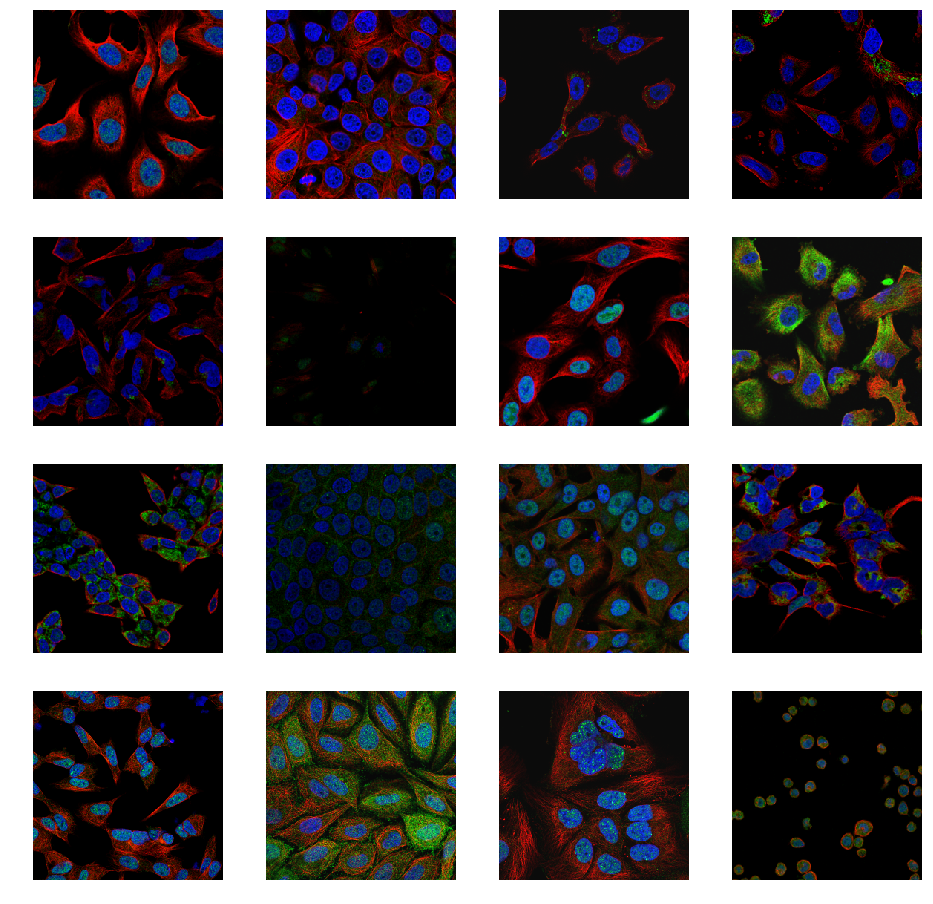

In [11]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [12]:
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in iter(md.trn_dl):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std

(array([0.08714, 0.05988, 0.06543, 0.08919]),
 array([0.13067, 0.09832, 0.14882, 0.13308]))

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [14]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [15]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        w = layers[0].weight
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

In [16]:
sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/lc3352/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 26060840.10it/s]
/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [17]:
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

  0%|          | 1/436 [00:01<12:50,  1.77s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<09:29,  1.31s/it, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:02<08:04,  1.12s/it, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:02<06:10,  1.17it/s, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:03<06:24,  1.12it/s, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<04:58,  1.44it/s, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:05<05:29,  1.30it/s, loss=11.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:05<04:19,  1.65it/s, loss=11]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:06<05:05,  1.40it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:06<04:04,  1.75it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:07<04:50,  1.46it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:07<03:52,  1.83it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:08<04:41,  1.50it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:08<03:46,  1.86it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:09<04:36,  1.52it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:10<03:43,  1.88it/s, loss=11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:10<04:35,  1.52it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:11<03:43,  1.87it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:12<04:38,  1.50it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:12<03:43,  1.86it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:13<05:30,  1.25it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:14<04:19,  1.59it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:15<04:59,  1.38it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:15<03:57,  1.73it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:16<04:42,  1.45it/s, loss=10.9]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:16<03:46,  1.81it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:17<04:34,  1.49it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:17<03:40,  1.85it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:18<04:26,  1.52it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:18<03:35,  1.88it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:19<04:17,  1.57it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:20<03:40,  1.83it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:20<04:18,  1.56it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:21<03:43,  1.80it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:22<04:19,  1.55it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:22<03:33,  1.87it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:23<04:16,  1.56it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:23<03:27,  1.92it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:24<04:20,  1.53it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:24<03:30,  1.88it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:26<05:07,  1.29it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:26<04:01,  1.63it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:27<04:35,  1.43it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:27<03:40,  1.78it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:28<04:26,  1.47it/s, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:28<03:36,  1.80it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:29<04:23,  1.48it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:29<03:31,  1.84it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:30<04:30,  1.43it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:31<03:35,  1.79it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:32<04:15,  1.51it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:32<03:25,  1.86it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:33<04:12,  1.52it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:33<03:24,  1.87it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:34<04:13,  1.50it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:34<03:24,  1.86it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:35<04:17,  1.47it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:35<03:26,  1.83it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:36<04:13,  1.49it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:37<03:23,  1.85it/s, loss=10.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:38<04:50,  1.29it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:38<03:50,  1.62it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [00:39<04:27,  1.39it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [00:39<03:33,  1.74it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [00:40<04:19,  1.43it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [00:41<03:27,  1.78it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [00:42<04:10,  1.47it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [00:42<03:21,  1.82it/s, loss=10.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [00:43<03:59,  1.53it/s, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [00:43<03:13,  1.90it/s, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [00:44<04:09,  1.46it/s, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [00:44<03:20,  1.81it/s, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [00:45<04:00,  1.51it/s, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [00:45<03:14,  1.86it/s, loss=10.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [00:46<04:01,  1.49it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [00:47<03:15,  1.84it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [00:48<03:57,  1.51it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [00:48<03:11,  1.87it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [00:49<03:56,  1.51it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [00:49<03:11,  1.86it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [00:50<04:37,  1.28it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [00:51<03:37,  1.63it/s, loss=10.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [00:52<04:06,  1.43it/s, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [00:52<03:16,  1.79it/s, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [00:53<03:58,  1.47it/s, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [00:53<03:10,  1.83it/s, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [00:54<03:57,  1.47it/s, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [00:54<03:11,  1.82it/s, loss=10.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [00:55<03:54,  1.48it/s, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [00:55<03:07,  1.84it/s, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [00:56<03:49,  1.51it/s, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [00:57<03:04,  1.87it/s, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [00:58<03:46,  1.51it/s, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [00:58<03:02,  1.87it/s, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [00:59<03:43,  1.53it/s, loss=10.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [00:59<03:00,  1.88it/s, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:00<03:40,  1.54it/s, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:00<02:58,  1.90it/s, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:01<03:42,  1.52it/s, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:01<02:58,  1.88it/s, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:03<04:19,  1.29it/s, loss=10.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:03<03:26,  1.62it/s, loss=10]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:04<04:02,  1.37it/s, loss=10]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:04<03:13,  1.72it/s, loss=10]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:05<03:41,  1.49it/s, loss=9.99]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:05<02:57,  1.85it/s, loss=9.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:06<03:36,  1.52it/s, loss=9.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:06<02:55,  1.87it/s, loss=9.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:07<03:45,  1.45it/s, loss=9.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:08<03:02,  1.79it/s, loss=9.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:09<03:44,  1.45it/s, loss=9.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:09<03:04,  1.76it/s, loss=9.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:10<03:44,  1.44it/s, loss=9.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:10<03:01,  1.77it/s, loss=9.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:11<03:47,  1.41it/s, loss=9.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:12<03:01,  1.76it/s, loss=9.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:13<03:50,  1.39it/s, loss=9.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:13<03:03,  1.73it/s, loss=9.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:14<03:48,  1.39it/s, loss=9.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:14<03:02,  1.73it/s, loss=9.6] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [01:16<04:29,  1.17it/s, loss=9.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [01:16<03:30,  1.49it/s, loss=9.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [01:17<04:03,  1.29it/s, loss=9.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [01:17<03:12,  1.62it/s, loss=9.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [01:18<03:44,  1.38it/s, loss=9.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [01:18<02:58,  1.74it/s, loss=9.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [01:19<03:20,  1.54it/s, loss=9.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [01:19<02:41,  1.91it/s, loss=9.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [01:20<03:14,  1.57it/s, loss=9.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [01:21<02:37,  1.95it/s, loss=9.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [01:21<03:11,  1.59it/s, loss=9.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [01:22<02:47,  1.81it/s, loss=9.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [01:23<03:12,  1.57it/s, loss=9.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [01:23<02:50,  1.77it/s, loss=9.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [01:24<03:09,  1.59it/s, loss=9.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [01:24<02:52,  1.74it/s, loss=8.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [01:25<03:04,  1.62it/s, loss=8.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [01:25<02:51,  1.74it/s, loss=8.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [01:26<03:00,  1.65it/s, loss=8.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [01:27<02:49,  1.75it/s, loss=8.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [01:28<03:56,  1.25it/s, loss=8.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [01:28<03:05,  1.58it/s, loss=8.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [01:29<03:34,  1.37it/s, loss=8.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [01:29<02:51,  1.70it/s, loss=8.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [01:30<03:17,  1.47it/s, loss=8.5] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [01:31<02:38,  1.83it/s, loss=8.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [01:32<03:15,  1.48it/s, loss=8.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [01:32<02:37,  1.83it/s, loss=8.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [01:33<03:07,  1.53it/s, loss=8.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [01:33<02:30,  1.89it/s, loss=8.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [01:34<03:06,  1.53it/s, loss=8.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [01:34<02:30,  1.89it/s, loss=7.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [01:35<03:06,  1.52it/s, loss=7.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [01:35<02:30,  1.87it/s, loss=7.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [01:36<03:00,  1.55it/s, loss=7.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [01:36<02:26,  1.92it/s, loss=7.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [01:37<02:55,  1.59it/s, loss=7.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [01:38<02:22,  1.96it/s, loss=7.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [01:39<03:05,  1.49it/s, loss=7.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [01:39<02:28,  1.85it/s, loss=7.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [01:40<03:41,  1.24it/s, loss=7.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [01:41<02:53,  1.58it/s, loss=7.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [01:41<03:15,  1.40it/s, loss=6.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [01:42<02:35,  1.75it/s, loss=6.86]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [01:43<03:00,  1.50it/s, loss=6.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [01:43<02:26,  1.84it/s, loss=6.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [01:44<02:56,  1.52it/s, loss=6.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [01:44<02:25,  1.85it/s, loss=6.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [01:45<02:55,  1.53it/s, loss=6.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [01:45<02:24,  1.84it/s, loss=6.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [01:46<02:54,  1.52it/s, loss=6.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [01:46<02:21,  1.86it/s, loss=6.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [01:47<02:47,  1.57it/s, loss=6]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [01:48<02:20,  1.87it/s, loss=5.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [01:48<02:49,  1.54it/s, loss=5.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [01:49<02:19,  1.86it/s, loss=5.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [01:50<02:47,  1.55it/s, loss=5.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [01:50<02:15,  1.90it/s, loss=5.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [01:51<02:45,  1.55it/s, loss=5.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [01:51<02:13,  1.92it/s, loss=5.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [01:52<03:16,  1.30it/s, loss=5.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [01:53<02:34,  1.64it/s, loss=5.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [01:54<03:01,  1.39it/s, loss=5.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [01:54<02:24,  1.75it/s, loss=5.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [01:55<02:49,  1.48it/s, loss=5.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [01:55<02:17,  1.81it/s, loss=5]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [01:56<02:47,  1.48it/s, loss=4.93]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [01:56<02:16,  1.82it/s, loss=4.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [01:57<02:45,  1.49it/s, loss=4.8] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [01:57<02:13,  1.84it/s, loss=4.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [01:58<02:36,  1.56it/s, loss=4.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [01:59<02:07,  1.91it/s, loss=4.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [01:59<02:33,  1.58it/s, loss=4.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [02:00<02:05,  1.92it/s, loss=4.5] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [02:01<02:30,  1.60it/s, loss=4.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [02:01<02:02,  1.96it/s, loss=4.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [02:02<02:32,  1.57it/s, loss=4.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [02:02<02:03,  1.93it/s, loss=4.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [02:03<02:32,  1.55it/s, loss=4.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [02:03<02:02,  1.92it/s, loss=4.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [02:04<03:01,  1.29it/s, loss=4.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [02:05<02:24,  1.62it/s, loss=4.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [02:06<02:42,  1.43it/s, loss=4.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [02:06<02:09,  1.79it/s, loss=3.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [02:07<02:34,  1.49it/s, loss=3.92]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [02:07<02:04,  1.84it/s, loss=3.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [02:08<02:30,  1.52it/s, loss=3.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [02:08<02:01,  1.88it/s, loss=3.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [02:09<02:26,  1.55it/s, loss=3.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [02:09<01:59,  1.90it/s, loss=3.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [02:10<02:22,  1.57it/s, loss=3.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [02:10<01:55,  1.94it/s, loss=3.6] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [02:11<02:22,  1.57it/s, loss=3.56]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [02:12<01:55,  1.93it/s, loss=3.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [02:13<02:23,  1.54it/s, loss=3.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [02:13<01:55,  1.91it/s, loss=3.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [02:14<02:23,  1.52it/s, loss=3.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [02:14<01:56,  1.88it/s, loss=3.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [02:15<02:21,  1.54it/s, loss=3.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [02:15<01:53,  1.90it/s, loss=3.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [02:17<02:44,  1.30it/s, loss=3.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [02:17<02:10,  1.64it/s, loss=3.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [02:18<02:30,  1.41it/s, loss=3.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [02:18<01:59,  1.77it/s, loss=3.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [02:19<02:23,  1.47it/s, loss=3.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [02:19<01:55,  1.82it/s, loss=3.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [02:20<02:18,  1.51it/s, loss=3.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [02:20<01:51,  1.87it/s, loss=3.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [02:21<02:16,  1.52it/s, loss=3.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [02:21<01:49,  1.87it/s, loss=3]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [02:22<02:13,  1.53it/s, loss=2.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [02:23<01:47,  1.89it/s, loss=2.95]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [02:24<02:10,  1.56it/s, loss=2.93]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [02:24<01:45,  1.92it/s, loss=2.9] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [02:25<02:10,  1.54it/s, loss=2.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [02:25<01:47,  1.87it/s, loss=2.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [02:26<02:07,  1.57it/s, loss=2.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [02:26<01:48,  1.82it/s, loss=2.8] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [02:27<02:07,  1.54it/s, loss=2.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [02:27<01:48,  1.81it/s, loss=2.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [02:29<02:39,  1.22it/s, loss=2.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [02:29<02:04,  1.56it/s, loss=2.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [02:30<02:19,  1.39it/s, loss=2.7] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [02:30<01:50,  1.74it/s, loss=2.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [02:31<02:15,  1.41it/s, loss=2.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [02:32<01:47,  1.77it/s, loss=2.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [02:32<02:09,  1.46it/s, loss=2.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [02:33<01:43,  1.82it/s, loss=2.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [02:34<02:07,  1.47it/s, loss=2.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [02:34<01:41,  1.83it/s, loss=2.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [02:35<02:01,  1.53it/s, loss=2.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [02:35<01:38,  1.87it/s, loss=2.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [02:36<02:00,  1.52it/s, loss=2.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [02:36<01:37,  1.87it/s, loss=2.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [02:37<01:57,  1.53it/s, loss=2.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [02:37<01:34,  1.90it/s, loss=2.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [02:38<01:57,  1.52it/s, loss=2.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [02:39<01:34,  1.88it/s, loss=2.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [02:40<01:55,  1.53it/s, loss=2.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [02:40<01:32,  1.90it/s, loss=2.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [02:41<02:17,  1.27it/s, loss=2.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [02:41<01:48,  1.60it/s, loss=2.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [02:42<02:04,  1.39it/s, loss=2.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [02:43<01:39,  1.73it/s, loss=2.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [02:44<01:54,  1.49it/s, loss=2.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [02:44<01:32,  1.84it/s, loss=2.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [02:45<01:49,  1.55it/s, loss=2.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [02:45<01:28,  1.90it/s, loss=2.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [02:46<01:50,  1.51it/s, loss=2.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [02:46<01:29,  1.86it/s, loss=2.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [02:47<01:47,  1.54it/s, loss=2.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [02:47<01:26,  1.90it/s, loss=2.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [02:48<01:44,  1.56it/s, loss=2.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [02:48<01:24,  1.93it/s, loss=2.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [02:49<01:40,  1.61it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [02:50<01:20,  1.98it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [02:50<01:39,  1.59it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [02:51<01:20,  1.97it/s, loss=2.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [02:52<01:38,  1.59it/s, loss=2.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [02:52<01:19,  1.96it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [02:53<01:57,  1.31it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [02:53<01:32,  1.66it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [02:54<01:47,  1.43it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [02:55<01:25,  1.78it/s, loss=2.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [02:56<01:42,  1.47it/s, loss=2.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [02:56<01:21,  1.84it/s, loss=2.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [02:57<01:40,  1.49it/s, loss=2.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [02:57<01:20,  1.84it/s, loss=2.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [02:58<01:38,  1.50it/s, loss=2.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [02:58<01:18,  1.85it/s, loss=2.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [02:59<01:35,  1.52it/s, loss=2.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [02:59<01:16,  1.87it/s, loss=2.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [03:00<01:34,  1.52it/s, loss=2.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [03:01<01:16,  1.87it/s, loss=2.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [03:01<01:30,  1.55it/s, loss=2.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [03:02<01:13,  1.92it/s, loss=2.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [03:03<01:29,  1.54it/s, loss=2.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [03:03<01:12,  1.91it/s, loss=2.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [03:04<01:29,  1.53it/s, loss=2.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [03:04<01:11,  1.90it/s, loss=2.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [03:05<01:45,  1.28it/s, loss=2.7] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [03:06<01:22,  1.62it/s, loss=2.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [03:07<01:33,  1.43it/s, loss=2.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [03:07<01:13,  1.78it/s, loss=2.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [03:08<01:28,  1.48it/s, loss=2.92]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [03:08<01:10,  1.85it/s, loss=2.95]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [03:09<01:26,  1.49it/s, loss=3.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [03:09<01:09,  1.85it/s, loss=3.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [03:10<01:24,  1.50it/s, loss=3.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [03:10<01:07,  1.87it/s, loss=3.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [03:11<01:24,  1.48it/s, loss=3.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [03:12<01:07,  1.85it/s, loss=3.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [03:13<01:22,  1.49it/s, loss=3.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [03:13<01:06,  1.84it/s, loss=3.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [03:14<01:19,  1.52it/s, loss=3.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [03:14<01:03,  1.88it/s, loss=3.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [03:15<01:17,  1.54it/s, loss=4.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [03:15<01:02,  1.90it/s, loss=4.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [03:16<01:14,  1.57it/s, loss=4.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [03:16<00:59,  1.94it/s, loss=4.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [03:18<01:28,  1.30it/s, loss=4.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [03:18<01:09,  1.64it/s, loss=4.9] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [03:19<01:19,  1.42it/s, loss=5.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [03:19<01:02,  1.78it/s, loss=5.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [03:20<01:14,  1.48it/s, loss=5.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [03:20<00:59,  1.84it/s, loss=5.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [03:21<01:12,  1.51it/s, loss=6.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [03:21<00:58,  1.86it/s, loss=6.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [03:22<01:09,  1.53it/s, loss=6.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [03:23<00:56,  1.89it/s, loss=7.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [03:23<01:06,  1.58it/s, loss=7.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [03:24<00:54,  1.91it/s, loss=7.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [03:25<01:06,  1.54it/s, loss=8.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [03:25<00:53,  1.90it/s, loss=8.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [03:26<00:53,  1.90it/s, loss=9.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


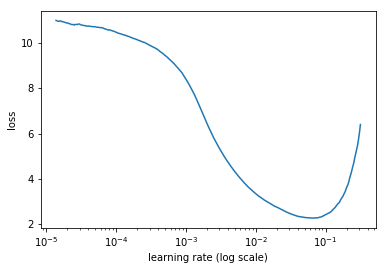

In [18]:
learner.lr_find()
learner.sched.plot()

In [19]:
lr = 2e-2
learner.fit(lr,1)

  0%|          | 1/436 [00:01<10:27,  1.44s/it, loss=11.2]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:01<07:48,  1.08s/it, loss=11.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:02<07:28,  1.04s/it, loss=10.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:02<05:43,  1.26it/s, loss=9.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:03<06:01,  1.19it/s, loss=8.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<04:43,  1.52it/s, loss=7.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:04<05:19,  1.34it/s, loss=6.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:05<04:13,  1.69it/s, loss=6.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:06<04:57,  1.44it/s, loss=5.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:06<03:58,  1.79it/s, loss=5.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:07<04:45,  1.49it/s, loss=5.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:07<03:50,  1.84it/s, loss=4.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:08<04:38,  1.52it/s, loss=4.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:08<03:44,  1.88it/s, loss=4.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:09<04:29,  1.56it/s, loss=4.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:09<03:37,  1.93it/s, loss=4.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:10<04:24,  1.58it/s, loss=4.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:10<03:34,  1.95it/s, loss=3.9] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:11<04:31,  1.54it/s, loss=3.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:12<03:39,  1.90it/s, loss=3.7] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:13<05:24,  1.28it/s, loss=3.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:13<04:17,  1.61it/s, loss=3.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:14<04:48,  1.43it/s, loss=3.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:14<03:50,  1.79it/s, loss=3.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:15<04:37,  1.48it/s, loss=3.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:16<03:42,  1.85it/s, loss=3.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:16<04:23,  1.55it/s, loss=3.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:17<03:32,  1.92it/s, loss=3.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:18<04:24,  1.54it/s, loss=3.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:18<03:33,  1.90it/s, loss=3.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:19<04:20,  1.55it/s, loss=2.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:19<03:29,  1.92it/s, loss=2.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:20<04:22,  1.54it/s, loss=2.86]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:20<03:31,  1.90it/s, loss=2.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:21<04:11,  1.59it/s, loss=2.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:21<03:29,  1.91it/s, loss=2.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:22<04:22,  1.52it/s, loss=2.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:23<03:32,  1.88it/s, loss=2.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:24<04:16,  1.55it/s, loss=2.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:24<03:31,  1.88it/s, loss=2.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:25<05:07,  1.28it/s, loss=2.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:25<04:02,  1.62it/s, loss=2.5] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:26<04:41,  1.39it/s, loss=2.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:27<03:43,  1.75it/s, loss=2.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:27<04:14,  1.53it/s, loss=2.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:28<03:25,  1.90it/s, loss=2.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:29<04:13,  1.54it/s, loss=2.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:29<03:25,  1.89it/s, loss=2.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:30<04:11,  1.54it/s, loss=2.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:30<03:22,  1.91it/s, loss=2.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:31<04:12,  1.53it/s, loss=2.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:31<03:23,  1.89it/s, loss=2.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:32<04:11,  1.52it/s, loss=2.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:32<03:24,  1.87it/s, loss=2.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:33<04:11,  1.52it/s, loss=2.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:34<03:23,  1.87it/s, loss=2.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:34<04:01,  1.57it/s, loss=2.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:35<03:15,  1.94it/s, loss=2.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:36<04:00,  1.57it/s, loss=2.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:36<03:13,  1.95it/s, loss=2.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:37<04:50,  1.29it/s, loss=2.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:37<03:48,  1.63it/s, loss=2.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [00:38<04:20,  1.43it/s, loss=2]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [00:39<03:29,  1.77it/s, loss=1.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [00:40<04:12,  1.47it/s, loss=1.96]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [00:40<03:22,  1.83it/s, loss=1.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [00:41<04:06,  1.50it/s, loss=1.93]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [00:41<03:17,  1.86it/s, loss=1.92]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [00:42<04:04,  1.50it/s, loss=1.9] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [00:42<03:16,  1.86it/s, loss=1.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [00:43<04:03,  1.50it/s, loss=1.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [00:43<03:16,  1.85it/s, loss=1.86]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [00:44<04:17,  1.41it/s, loss=1.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [00:45<03:26,  1.76it/s, loss=1.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [00:46<04:20,  1.39it/s, loss=1.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [00:46<03:28,  1.73it/s, loss=1.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [00:47<04:14,  1.41it/s, loss=1.8] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [00:47<03:23,  1.76it/s, loss=1.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [00:48<04:11,  1.42it/s, loss=1.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [00:49<03:20,  1.78it/s, loss=1.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [00:50<04:48,  1.23it/s, loss=1.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [00:50<03:46,  1.56it/s, loss=1.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [00:51<04:12,  1.40it/s, loss=1.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [00:51<03:20,  1.75it/s, loss=1.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [00:52<04:00,  1.46it/s, loss=1.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [00:53<03:13,  1.81it/s, loss=1.7] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [00:53<03:46,  1.54it/s, loss=1.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [00:54<03:03,  1.90it/s, loss=1.68]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [00:55<03:45,  1.54it/s, loss=1.67]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [00:55<03:02,  1.90it/s, loss=1.66]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [00:56<03:44,  1.54it/s, loss=1.65]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [00:56<03:01,  1.90it/s, loss=1.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [00:57<03:44,  1.53it/s, loss=1.64]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [00:57<03:09,  1.80it/s, loss=1.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [00:58<03:37,  1.57it/s, loss=1.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [00:58<03:04,  1.84it/s, loss=1.62]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [00:59<03:31,  1.60it/s, loss=1.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:00<03:01,  1.86it/s, loss=1.61]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:00<03:34,  1.57it/s, loss=1.6] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:01<03:04,  1.83it/s, loss=1.6]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:02<04:27,  1.25it/s, loss=1.59]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:02<03:29,  1.59it/s, loss=1.58]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:03<04:01,  1.38it/s, loss=1.58]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:04<03:13,  1.72it/s, loss=1.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:04<03:43,  1.48it/s, loss=1.57]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:05<03:00,  1.83it/s, loss=1.56]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:06<03:34,  1.53it/s, loss=1.56]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:06<02:54,  1.88it/s, loss=1.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:07<03:32,  1.54it/s, loss=1.55]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:07<02:53,  1.88it/s, loss=1.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:08<03:30,  1.54it/s, loss=1.54]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:08<02:50,  1.90it/s, loss=1.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:09<03:24,  1.58it/s, loss=1.53]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:09<02:46,  1.93it/s, loss=1.52]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:10<03:27,  1.55it/s, loss=1.52]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:11<02:48,  1.90it/s, loss=1.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:11<03:25,  1.55it/s, loss=1.51]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:12<02:45,  1.92it/s, loss=1.5] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:13<03:22,  1.56it/s, loss=1.5]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:13<02:43,  1.94it/s, loss=1.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [01:14<04:01,  1.30it/s, loss=1.49]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [01:14<03:11,  1.64it/s, loss=1.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [01:15<03:39,  1.42it/s, loss=1.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [01:16<02:55,  1.77it/s, loss=1.48]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [01:16<03:24,  1.52it/s, loss=1.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [01:17<02:45,  1.87it/s, loss=1.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [01:18<03:16,  1.57it/s, loss=1.47]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [01:18<02:38,  1.94it/s, loss=1.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [01:19<03:12,  1.59it/s, loss=1.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [01:19<02:37,  1.94it/s, loss=1.46]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [01:20<03:13,  1.58it/s, loss=1.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [01:20<02:36,  1.94it/s, loss=1.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [01:21<03:13,  1.57it/s, loss=1.45]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [01:21<02:36,  1.93it/s, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [01:22<03:06,  1.61it/s, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [01:22<02:36,  1.92it/s, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [01:23<03:09,  1.58it/s, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [01:24<02:33,  1.94it/s, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [01:24<03:10,  1.56it/s, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [01:25<02:33,  1.93it/s, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [01:26<03:47,  1.30it/s, loss=1.43]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [01:26<03:00,  1.63it/s, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [01:27<03:25,  1.43it/s, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [01:27<02:44,  1.78it/s, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [01:28<03:12,  1.51it/s, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [01:29<02:34,  1.88it/s, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [01:30<03:08,  1.53it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [01:30<02:32,  1.89it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [01:31<03:03,  1.56it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [01:31<02:28,  1.93it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [01:32<03:04,  1.54it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [01:32<02:28,  1.91it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [01:33<03:01,  1.56it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [01:33<02:26,  1.92it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [01:34<03:05,  1.52it/s, loss=1.41]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [01:34<02:28,  1.88it/s, loss=1.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [01:35<03:03,  1.52it/s, loss=1.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [01:36<02:27,  1.89it/s, loss=1.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [01:37<03:00,  1.54it/s, loss=1.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [01:37<02:26,  1.89it/s, loss=1.4]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [01:38<03:40,  1.24it/s, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [01:39<02:53,  1.58it/s, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [01:39<03:16,  1.39it/s, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [01:40<02:36,  1.74it/s, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [01:41<03:01,  1.49it/s, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [01:41<02:26,  1.85it/s, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [01:42<02:52,  1.55it/s, loss=1.38]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [01:42<02:20,  1.91it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [01:43<02:52,  1.55it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [01:43<02:19,  1.91it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [01:44<02:51,  1.54it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [01:44<02:18,  1.91it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [01:45<02:52,  1.53it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [01:45<02:18,  1.88it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [01:46<02:51,  1.52it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [01:47<02:21,  1.84it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [01:48<02:47,  1.55it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [01:48<02:22,  1.81it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [01:49<02:41,  1.59it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [01:49<02:18,  1.84it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [01:50<03:22,  1.26it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [01:51<02:39,  1.59it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [01:52<03:03,  1.38it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [01:52<02:26,  1.72it/s, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [01:53<02:55,  1.43it/s, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [01:53<02:19,  1.79it/s, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [01:54<02:42,  1.53it/s, loss=1.36]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [01:54<02:11,  1.88it/s, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [01:55<02:39,  1.55it/s, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [01:55<02:08,  1.91it/s, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [01:56<02:41,  1.52it/s, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [01:57<02:10,  1.88it/s, loss=1.35]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [01:58<02:42,  1.49it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [01:58<02:10,  1.86it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [01:59<02:37,  1.53it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [01:59<02:07,  1.88it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [02:00<02:36,  1.53it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [02:00<02:05,  1.89it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [02:01<02:36,  1.52it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [02:01<02:05,  1.89it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [02:03<03:05,  1.27it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [02:03<02:25,  1.61it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [02:04<02:47,  1.39it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [02:04<02:13,  1.74it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [02:05<02:36,  1.48it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [02:05<02:05,  1.83it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [02:06<02:31,  1.51it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [02:06<02:01,  1.87it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [02:07<02:31,  1.50it/s, loss=1.34]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [02:08<02:02,  1.84it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [02:09<02:29,  1.51it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [02:09<02:00,  1.85it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [02:10<02:25,  1.53it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [02:10<01:57,  1.89it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [02:11<02:22,  1.55it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [02:11<01:54,  1.91it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [02:12<02:21,  1.55it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [02:12<01:53,  1.92it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [02:13<02:21,  1.53it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [02:14<01:53,  1.91it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [02:15<02:48,  1.28it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [02:15<02:12,  1.62it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [02:16<02:29,  1.42it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [02:16<01:59,  1.77it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [02:17<02:19,  1.51it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [02:17<01:52,  1.87it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [02:18<02:13,  1.56it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [02:19<01:47,  1.93it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [02:19<02:11,  1.58it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [02:20<01:45,  1.95it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [02:21<02:13,  1.53it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [02:21<01:47,  1.89it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [02:22<02:11,  1.55it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [02:22<01:45,  1.92it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [02:23<02:08,  1.56it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [02:23<01:44,  1.92it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [02:24<02:07,  1.56it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [02:24<01:44,  1.89it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [02:25<02:06,  1.56it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [02:26<01:43,  1.89it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [02:27<02:32,  1.28it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [02:27<02:00,  1.61it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [02:28<02:15,  1.42it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [02:28<01:48,  1.76it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [02:29<02:09,  1.48it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [02:30<01:44,  1.83it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [02:30<02:07,  1.49it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [02:31<01:41,  1.84it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [02:32<02:03,  1.51it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [02:32<01:40,  1.85it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [02:33<01:55,  1.60it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [02:33<01:34,  1.95it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [02:34<01:55,  1.59it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [02:34<01:34,  1.93it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [02:35<01:56,  1.56it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [02:35<01:33,  1.93it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [02:36<01:55,  1.55it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [02:36<01:33,  1.91it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [02:37<01:52,  1.57it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [02:38<01:31,  1.93it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [02:39<02:18,  1.26it/s, loss=1.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [02:39<01:48,  1.60it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [02:40<01:58,  1.46it/s, loss=1.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [02:40<01:34,  1.81it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [02:41<01:51,  1.53it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [02:42<01:29,  1.89it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [02:42<01:50,  1.53it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [02:43<01:28,  1.89it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [02:44<01:48,  1.54it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [02:44<01:27,  1.90it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [02:45<01:44,  1.57it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [02:45<01:27,  1.87it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [02:46<01:41,  1.61it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [02:46<01:27,  1.85it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [02:47<01:38,  1.64it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [02:47<01:27,  1.82it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [02:48<01:39,  1.60it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [02:49<01:26,  1.82it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [02:49<01:43,  1.52it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [02:50<01:30,  1.73it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [02:51<02:14,  1.15it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [02:52<01:44,  1.47it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [02:53<02:02,  1.25it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [02:53<01:36,  1.57it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [02:54<01:54,  1.31it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [02:54<01:30,  1.65it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [02:55<01:51,  1.34it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [02:56<01:28,  1.68it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [02:57<01:46,  1.37it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [02:57<01:24,  1.72it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [02:58<01:45,  1.37it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [02:58<01:24,  1.70it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [02:59<01:41,  1.41it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [02:59<01:21,  1.74it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [03:00<01:36,  1.47it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [03:01<01:16,  1.82it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [03:02<01:32,  1.51it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [03:02<01:13,  1.87it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [03:03<01:27,  1.56it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [03:03<01:10,  1.92it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [03:04<01:44,  1.29it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [03:05<01:22,  1.62it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [03:05<01:32,  1.44it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [03:06<01:13,  1.79it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [03:07<01:27,  1.49it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [03:07<01:10,  1.85it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [03:08<01:25,  1.51it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [03:08<01:08,  1.87it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [03:09<01:22,  1.55it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [03:09<01:05,  1.91it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [03:10<01:21,  1.53it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [03:10<01:05,  1.89it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [03:11<01:20,  1.53it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [03:12<01:04,  1.89it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [03:12<01:17,  1.56it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [03:13<01:02,  1.92it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [03:14<01:15,  1.58it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [03:14<01:00,  1.94it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [03:15<01:16,  1.53it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [03:15<01:01,  1.89it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [03:16<01:29,  1.29it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [03:17<01:10,  1.62it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [03:17<01:17,  1.45it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [03:18<01:02,  1.80it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [03:19<01:12,  1.52it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [03:19<00:59,  1.86it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [03:20<01:11,  1.52it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [03:20<00:58,  1.85it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [03:21<01:09,  1.53it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [03:21<00:57,  1.84it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [03:22<01:08,  1.53it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [03:22<00:54,  1.89it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [03:23<01:06,  1.55it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [03:24<00:53,  1.91it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [03:25<01:05,  1.54it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [03:25<00:52,  1.90it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [03:26<01:05,  1.51it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [03:26<00:52,  1.87it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [03:27<01:01,  1.57it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [03:27<00:51,  1.87it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [03:29<01:14,  1.28it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [03:29<00:57,  1.62it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [03:30<01:06,  1.40it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [03:30<00:52,  1.75it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [03:31<01:03,  1.44it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [03:31<00:50,  1.80it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [03:32<00:57,  1.54it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [03:32<00:46,  1.91it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [03:33<00:55,  1.56it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [03:33<00:44,  1.93it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [03:34<00:56,  1.51it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [03:35<00:44,  1.87it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [03:36<00:55,  1.50it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [03:36<00:43,  1.87it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [03:37<00:55,  1.47it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [03:37<00:43,  1.83it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [03:38<00:51,  1.53it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [03:38<00:41,  1.89it/s, loss=1.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [03:39<00:50,  1.51it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [03:39<00:40,  1.88it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [03:41<00:58,  1.28it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [03:41<00:45,  1.62it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [03:42<00:52,  1.39it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [03:42<00:41,  1.74it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [03:43<00:48,  1.47it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [03:43<00:38,  1.83it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [03:44<00:47,  1.46it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [03:45<00:37,  1.82it/s, loss=1.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [03:45<00:42,  1.59it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [03:46<00:33,  1.95it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [03:47<00:42,  1.52it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [03:47<00:34,  1.86it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [03:48<00:40,  1.56it/s, loss=1.3] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [03:48<00:32,  1.93it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [03:49<00:39,  1.54it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [03:49<00:32,  1.87it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [03:50<00:36,  1.60it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [03:50<00:31,  1.85it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [03:51<00:35,  1.62it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [03:52<00:30,  1.81it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [03:53<00:44,  1.24it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [03:53<00:34,  1.57it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [03:54<00:38,  1.39it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [03:54<00:29,  1.75it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [03:55<00:35,  1.45it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [03:56<00:27,  1.81it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [03:57<00:33,  1.48it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [03:57<00:26,  1.83it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [03:58<00:31,  1.48it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [03:58<00:25,  1.82it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [03:59<00:30,  1.48it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [03:59<00:23,  1.83it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [04:00<00:28,  1.53it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [04:00<00:22,  1.89it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [04:01<00:27,  1.52it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [04:02<00:21,  1.88it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [04:03<00:25,  1.53it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [04:03<00:20,  1.87it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [04:04<00:24,  1.53it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [04:04<00:18,  1.90it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [04:05<00:27,  1.29it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [04:06<00:20,  1.62it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [04:06<00:23,  1.43it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [04:07<00:17,  1.79it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [04:08<00:20,  1.48it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [04:08<00:16,  1.83it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [04:09<00:19,  1.52it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [04:09<00:14,  1.88it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [04:10<00:17,  1.53it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [04:10<00:13,  1.90it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [04:11<00:16,  1.50it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [04:11<00:12,  1.86it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [04:12<00:14,  1.54it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [04:13<00:11,  1.90it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [04:14<00:13,  1.56it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [04:14<00:10,  1.92it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [04:15<00:11,  1.59it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [04:15<00:09,  1.90it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [04:16<00:10,  1.63it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [04:16<00:08,  1.91it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [04:17<00:11,  1.30it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [04:18<00:08,  1.64it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [04:19<00:09,  1.41it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [04:19<00:06,  1.77it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [04:20<00:07,  1.48it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [04:20<00:05,  1.84it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [04:21<00:05,  1.53it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [04:21<00:04,  1.89it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [04:22<00:04,  1.55it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [04:22<00:03,  1.92it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [04:23<00:03,  1.52it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [04:23<00:02,  1.89it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [04:24<00:01,  1.53it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [04:25<00:01,  1.88it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [04:26<00:00,  1.51it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc        
    0      1.286577   1.24422    0.94675   


[1.244220360519036, 0.9467503617168853]

In [20]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [21]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<12:11,  1.68s/it, loss=1.42]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<09:39,  1.34s/it, loss=1.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:02<08:06,  1.12s/it, loss=1.39]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:03<06:48,  1.06it/s, loss=1.44]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:04<06:12,  1.16it/s, loss=1.4] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<05:30,  1.30it/s, loss=1.37]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:05<05:13,  1.37it/s, loss=1.33]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:05<04:48,  1.48it/s, loss=1.32]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:06<04:41,  1.52it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:06<04:25,  1.60it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:07<04:21,  1.63it/s, loss=1.3]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:08<04:11,  1.69it/s, loss=1.31]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:08<04:17,  1.65it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:09<04:08,  1.70it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:09<04:10,  1.68it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:10<04:03,  1.73it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:11<04:06,  1.70it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:11<04:00,  1.74it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:12<04:06,  1.69it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:12<03:59,  1.74it/s, loss=1.29]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:14<06:13,  1.11it/s, loss=1.28]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:14<05:28,  1.26it/s, loss=1.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:15<05:11,  1.33it/s, loss=1.27]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:16<04:44,  1.45it/s, loss=1.26]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:16<04:38,  1.48it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:17<04:22,  1.56it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:17<04:21,  1.57it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:18<04:08,  1.64it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:19<04:15,  1.60it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:19<04:04,  1.66it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:20<04:10,  1.62it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:20<04:00,  1.68it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:21<04:09,  1.62it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:22<03:59,  1.68it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:22<04:02,  1.66it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:23<03:54,  1.71it/s, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:23<03:55,  1.69it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:24<03:49,  1.73it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:25<03:55,  1.68it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:25<03:47,  1.74it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:27<05:51,  1.12it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:27<05:08,  1.28it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:28<04:49,  1.36it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:28<04:25,  1.48it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:29<04:24,  1.48it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:30<04:08,  1.57it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:30<04:02,  1.60it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:31<03:53,  1.66it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:31<03:57,  1.63it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:32<03:48,  1.69it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:33<03:56,  1.63it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:33<03:47,  1.69it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:34<03:47,  1.68it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:34<03:40,  1.73it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:35<03:50,  1.65it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:36<03:42,  1.71it/s, loss=1.25]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:36<03:48,  1.66it/s, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:37<03:41,  1.71it/s, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:37<03:45,  1.67it/s, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:38<03:37,  1.73it/s, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:40<05:37,  1.11it/s, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:40<04:56,  1.26it/s, loss=1.24]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [00:41<04:40,  1.33it/s, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [00:41<04:16,  1.45it/s, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [00:42<04:14,  1.46it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [00:43<03:57,  1.56it/s, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [00:43<03:53,  1.58it/s, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [00:44<03:42,  1.65it/s, loss=1.23]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [00:44<03:48,  1.61it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [00:45<03:39,  1.67it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [00:46<03:43,  1.63it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [00:46<03:35,  1.69it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [00:47<03:41,  1.64it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [00:47<03:33,  1.69it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [00:48<03:36,  1.67it/s, loss=1.22]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [00:48<03:29,  1.72it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [00:49<03:34,  1.68it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [00:50<03:27,  1.73it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [00:50<03:30,  1.70it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [00:51<03:23,  1.75it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [00:52<05:18,  1.12it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [00:53<04:39,  1.27it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [00:54<04:25,  1.33it/s, loss=1.21]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [00:54<04:02,  1.45it/s, loss=1.2] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [00:55<03:58,  1.47it/s, loss=1.2]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [00:55<03:42,  1.57it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [00:56<03:42,  1.57it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [00:57<03:31,  1.64it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [00:57<03:35,  1.61it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [00:58<03:26,  1.68it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [00:58<03:29,  1.64it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [00:59<03:22,  1.70it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [00:59<03:24,  1.67it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [01:00<03:18,  1.72it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:01<03:22,  1.68it/s, loss=1.19]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [01:01<03:16,  1.73it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:02<03:23,  1.67it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:02<03:16,  1.72it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:03<03:20,  1.68it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:04<03:13,  1.74it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:05<05:02,  1.11it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:06<04:25,  1.26it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:06<04:04,  1.36it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:07<03:44,  1.48it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:08<03:42,  1.49it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:08<03:28,  1.58it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:09<03:31,  1.56it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:09<03:20,  1.64it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:10<03:22,  1.62it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:10<03:13,  1.68it/s, loss=1.18]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:11<03:18,  1.64it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:12<03:10,  1.70it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:12<03:18,  1.62it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:13<03:10,  1.69it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:14<03:15,  1.64it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:14<03:08,  1.70it/s, loss=1.17]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:15<03:14,  1.64it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:15<03:07,  1.70it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:16<03:11,  1.66it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:16<03:03,  1.72it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [01:18<04:55,  1.07it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [01:19<04:18,  1.22it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [01:20<04:11,  1.24it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [01:20<03:47,  1.37it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [01:21<03:48,  1.36it/s, loss=1.16]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [01:21<03:31,  1.47it/s, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [01:22<03:36,  1.43it/s, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [01:23<03:22,  1.52it/s, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [01:23<03:29,  1.47it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [01:24<03:16,  1.55it/s, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [01:25<03:29,  1.46it/s, loss=1.15]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [01:25<03:16,  1.55it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [01:26<03:28,  1.45it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [01:27<03:15,  1.55it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [01:27<03:29,  1.44it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [01:28<03:14,  1.54it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [01:29<03:15,  1.53it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [01:29<03:04,  1.62it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [01:30<03:07,  1.59it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [01:30<02:57,  1.67it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [01:32<04:29,  1.09it/s, loss=1.14]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [01:33<03:55,  1.25it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [01:33<03:38,  1.34it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [01:34<03:20,  1.46it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [01:34<03:14,  1.50it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [01:35<03:02,  1.59it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [01:36<03:02,  1.58it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [01:36<02:54,  1.65it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [01:37<02:50,  1.68it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [01:37<02:45,  1.73it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [01:38<02:46,  1.71it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [01:38<02:42,  1.75it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [01:39<02:44,  1.72it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [01:39<02:40,  1.76it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [01:40<02:42,  1.73it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [01:41<02:38,  1.76it/s, loss=1.13]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [01:41<02:39,  1.75it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [01:42<02:36,  1.78it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [01:42<02:41,  1.72it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [01:43<02:36,  1.76it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [01:45<04:07,  1.11it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [01:45<03:37,  1.26it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [01:46<03:18,  1.37it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [01:46<03:02,  1.49it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [01:47<02:52,  1.57it/s, loss=1.12]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [01:47<02:44,  1.64it/s, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [01:48<02:45,  1.63it/s, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [01:48<02:38,  1.69it/s, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [01:49<02:43,  1.63it/s, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [01:50<02:37,  1.69it/s, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [01:50<02:42,  1.64it/s, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [01:51<02:36,  1.69it/s, loss=1.11]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [01:52<02:37,  1.66it/s, loss=1.1] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [01:52<02:32,  1.72it/s, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [01:53<02:35,  1.67it/s, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [01:53<02:30,  1.72it/s, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [01:54<02:34,  1.67it/s, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [01:54<02:30,  1.72it/s, loss=1.1] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [01:55<02:33,  1.67it/s, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [01:56<02:27,  1.73it/s, loss=1.1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [01:57<03:52,  1.10it/s, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [01:58<03:23,  1.25it/s, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [01:58<03:08,  1.34it/s, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [01:59<02:52,  1.46it/s, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [02:00<02:47,  1.50it/s, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [02:00<02:37,  1.59it/s, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [02:01<02:38,  1.57it/s, loss=1.09]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [02:01<02:30,  1.65it/s, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [02:02<02:34,  1.60it/s, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [02:03<02:27,  1.67it/s, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [02:03<02:32,  1.60it/s, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [02:04<02:26,  1.67it/s, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [02:04<02:29,  1.63it/s, loss=1.08]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [02:05<02:23,  1.69it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [02:06<02:24,  1.66it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [02:06<02:19,  1.72it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [02:07<02:24,  1.66it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [02:07<02:19,  1.71it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [02:08<02:23,  1.65it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [02:08<02:17,  1.71it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [02:10<03:29,  1.12it/s, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [02:11<03:04,  1.27it/s, loss=1.07]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [02:11<02:55,  1.33it/s, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [02:12<02:39,  1.45it/s, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [02:12<02:35,  1.49it/s, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [02:13<02:25,  1.58it/s, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [02:14<02:23,  1.60it/s, loss=1.06]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [02:14<02:16,  1.67it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [02:15<02:19,  1.62it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [02:15<02:14,  1.69it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [02:16<02:14,  1.67it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [02:17<02:10,  1.72it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [02:17<02:14,  1.66it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [02:18<02:09,  1.71it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [02:18<02:14,  1.65it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [02:19<02:09,  1.70it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [02:20<02:09,  1.69it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [02:20<02:05,  1.73it/s, loss=1.05]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [02:21<02:08,  1.69it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [02:21<02:04,  1.74it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [02:23<03:16,  1.10it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [02:23<02:51,  1.25it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [02:24<02:39,  1.33it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [02:25<02:25,  1.46it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [02:25<02:21,  1.49it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [02:26<02:12,  1.58it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [02:26<02:13,  1.57it/s, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [02:27<02:06,  1.64it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [02:28<02:05,  1.66it/s, loss=1.04]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [02:28<02:00,  1.71it/s, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [02:29<01:59,  1.72it/s, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [02:29<01:56,  1.75it/s, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [02:30<01:59,  1.70it/s, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [02:30<01:55,  1.75it/s, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [02:31<01:55,  1.74it/s, loss=1.03]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [02:32<01:53,  1.77it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [02:32<01:56,  1.70it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [02:33<01:53,  1.75it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [02:33<01:54,  1.72it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [02:34<01:50,  1.77it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [02:36<02:53,  1.12it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [02:36<02:32,  1.28it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [02:37<02:24,  1.34it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [02:37<02:11,  1.46it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [02:38<02:11,  1.45it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [02:38<02:02,  1.55it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [02:39<01:56,  1.62it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [02:40<01:51,  1.68it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [02:40<01:50,  1.69it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [02:41<01:47,  1.73it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [02:41<01:48,  1.70it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [02:42<01:45,  1.74it/s, loss=1.02]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [02:42<01:46,  1.73it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [02:43<01:43,  1.76it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [02:44<01:44,  1.73it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [02:44<01:42,  1.76it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [02:45<01:42,  1.74it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [02:45<01:40,  1.77it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [02:46<01:42,  1.73it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [02:46<01:39,  1.77it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [02:48<02:34,  1.13it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [02:49<02:15,  1.28it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [02:49<02:06,  1.37it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [02:50<01:55,  1.49it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [02:50<01:52,  1.52it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [02:51<01:45,  1.61it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [02:52<01:44,  1.62it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [02:52<01:39,  1.68it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [02:53<01:39,  1.68it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [02:53<01:36,  1.73it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [02:54<01:36,  1.72it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [02:54<01:33,  1.75it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [02:55<01:35,  1.71it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [02:55<01:32,  1.75it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [02:56<01:33,  1.72it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [02:57<01:30,  1.76it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [02:57<01:32,  1.72it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [02:58<01:31,  1.73it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [02:58<01:30,  1.73it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [02:59<01:30,  1.72it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [03:01<02:20,  1.10it/s, loss=1.01]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [03:01<02:02,  1.25it/s, loss=1]   

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [03:02<01:55,  1.33it/s, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [03:02<01:44,  1.45it/s, loss=1]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [03:03<01:43,  1.45it/s, loss=0.996]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [03:04<01:36,  1.55it/s, loss=0.995]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [03:04<01:37,  1.53it/s, loss=0.994]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [03:05<01:31,  1.61it/s, loss=0.995]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [03:05<01:31,  1.60it/s, loss=0.993]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [03:06<01:27,  1.67it/s, loss=0.996]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [03:07<01:30,  1.59it/s, loss=0.993]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [03:07<01:26,  1.66it/s, loss=0.992]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [03:08<01:26,  1.65it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [03:08<01:23,  1.71it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [03:09<01:25,  1.66it/s, loss=0.988]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [03:10<01:22,  1.70it/s, loss=0.987]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [03:10<01:21,  1.71it/s, loss=0.985]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [03:11<01:19,  1.74it/s, loss=0.984]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [03:11<01:19,  1.73it/s, loss=0.986]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [03:12<01:16,  1.78it/s, loss=0.981]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [03:13<01:59,  1.13it/s, loss=0.984]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [03:14<01:44,  1.28it/s, loss=0.982]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [03:15<01:36,  1.38it/s, loss=0.983]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [03:15<01:28,  1.49it/s, loss=0.984]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [03:16<01:24,  1.55it/s, loss=0.987]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [03:16<01:20,  1.62it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [03:17<01:17,  1.65it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [03:17<01:14,  1.71it/s, loss=0.988]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [03:18<01:14,  1.71it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [03:18<01:12,  1.74it/s, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [03:19<01:12,  1.72it/s, loss=0.99]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [03:20<01:10,  1.76it/s, loss=0.99]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [03:20<01:10,  1.74it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [03:21<01:08,  1.77it/s, loss=0.987]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [03:21<01:10,  1.73it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [03:22<01:08,  1.76it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [03:23<01:08,  1.73it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [03:23<01:08,  1.72it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [03:24<01:09,  1.70it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [03:24<01:07,  1.72it/s, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [03:26<01:43,  1.11it/s, loss=0.988]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [03:26<01:30,  1.26it/s, loss=0.988]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [03:27<01:26,  1.31it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [03:28<01:17,  1.44it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [03:28<01:15,  1.47it/s, loss=0.994]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [03:29<01:10,  1.57it/s, loss=0.995]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [03:30<01:10,  1.55it/s, loss=0.996]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [03:30<01:06,  1.63it/s, loss=0.993]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [03:31<01:07,  1.60it/s, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [03:31<01:03,  1.67it/s, loss=0.989]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [03:32<01:04,  1.62it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [03:32<01:01,  1.69it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [03:33<01:03,  1.63it/s, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [03:34<01:00,  1.68it/s, loss=0.99]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [03:34<01:01,  1.65it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [03:35<00:58,  1.71it/s, loss=0.992]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [03:35<00:58,  1.70it/s, loss=0.991]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [03:36<00:56,  1.75it/s, loss=0.99] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [03:37<00:56,  1.72it/s, loss=0.988]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [03:37<00:54,  1.76it/s, loss=0.988]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [03:39<01:25,  1.11it/s, loss=0.987]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [03:39<01:14,  1.26it/s, loss=0.986]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [03:40<01:08,  1.36it/s, loss=0.986]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [03:40<01:02,  1.48it/s, loss=0.984]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [03:41<00:59,  1.52it/s, loss=0.98] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [03:42<00:56,  1.60it/s, loss=0.98]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [03:42<00:55,  1.59it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [03:43<00:53,  1.66it/s, loss=0.98] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [03:43<00:53,  1.63it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [03:44<00:50,  1.69it/s, loss=0.981]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [03:45<00:52,  1.62it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [03:45<00:49,  1.68it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [03:46<00:50,  1.64it/s, loss=0.977]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [03:46<00:48,  1.70it/s, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [03:47<00:49,  1.63it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [03:48<00:47,  1.69it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [03:48<00:48,  1.63it/s, loss=0.98] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [03:49<00:46,  1.69it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [03:49<00:47,  1.64it/s, loss=0.98] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [03:50<00:44,  1.70it/s, loss=0.981]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [03:52<01:08,  1.09it/s, loss=0.979]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [03:52<00:59,  1.24it/s, loss=0.98] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [03:53<00:53,  1.35it/s, loss=0.978]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [03:53<00:48,  1.47it/s, loss=0.978]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [03:54<00:47,  1.48it/s, loss=0.977]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [03:55<00:44,  1.58it/s, loss=0.975]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [03:55<00:44,  1.56it/s, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [03:56<00:41,  1.64it/s, loss=0.975]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [03:56<00:41,  1.62it/s, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [03:57<00:39,  1.68it/s, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [03:58<00:39,  1.63it/s, loss=0.975]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [03:58<00:37,  1.69it/s, loss=0.975]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [03:59<00:38,  1.65it/s, loss=0.977]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [03:59<00:36,  1.71it/s, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [04:00<00:36,  1.66it/s, loss=0.976]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [04:01<00:35,  1.71it/s, loss=0.973]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [04:01<00:35,  1.66it/s, loss=0.97] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [04:02<00:33,  1.71it/s, loss=0.965]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [04:02<00:34,  1.66it/s, loss=0.965]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [04:03<00:32,  1.72it/s, loss=0.962]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [04:05<00:49,  1.10it/s, loss=0.959]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [04:05<00:43,  1.25it/s, loss=0.959]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [04:06<00:39,  1.34it/s, loss=0.958]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [04:06<00:35,  1.46it/s, loss=0.957]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [04:07<00:33,  1.52it/s, loss=0.955]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [04:07<00:31,  1.60it/s, loss=0.958]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [04:08<00:29,  1.64it/s, loss=0.957]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [04:09<00:28,  1.70it/s, loss=0.955]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [04:09<00:27,  1.68it/s, loss=0.958]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [04:10<00:26,  1.73it/s, loss=0.957]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [04:10<00:26,  1.71it/s, loss=0.956]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [04:11<00:25,  1.75it/s, loss=0.957]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [04:11<00:25,  1.71it/s, loss=0.956]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [04:12<00:24,  1.74it/s, loss=0.952]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [04:13<00:25,  1.63it/s, loss=0.952]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [04:13<00:23,  1.68it/s, loss=0.952]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [04:14<00:25,  1.56it/s, loss=0.95] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [04:15<00:23,  1.62it/s, loss=0.955]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [04:15<00:24,  1.52it/s, loss=0.956]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [04:16<00:22,  1.60it/s, loss=0.954]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [04:18<00:33,  1.04it/s, loss=0.953]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [04:18<00:28,  1.20it/s, loss=0.951]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [04:19<00:25,  1.30it/s, loss=0.95] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [04:19<00:22,  1.42it/s, loss=0.948]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [04:20<00:21,  1.46it/s, loss=0.948]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [04:20<00:19,  1.56it/s, loss=0.949]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [04:21<00:18,  1.55it/s, loss=0.948]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [04:22<00:17,  1.63it/s, loss=0.948]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [04:22<00:17,  1.56it/s, loss=0.945]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [04:23<00:15,  1.64it/s, loss=0.946]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [04:24<00:15,  1.62it/s, loss=0.946]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [04:24<00:14,  1.68it/s, loss=0.944]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [04:25<00:14,  1.63it/s, loss=0.944]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [04:25<00:13,  1.69it/s, loss=0.944]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [04:26<00:13,  1.60it/s, loss=0.941]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [04:27<00:11,  1.67it/s, loss=0.939]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [04:27<00:11,  1.67it/s, loss=0.939]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [04:28<00:10,  1.72it/s, loss=0.942]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [04:28<00:10,  1.70it/s, loss=0.941]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [04:29<00:09,  1.75it/s, loss=0.942]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [04:30<00:13,  1.11it/s, loss=0.942]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [04:31<00:11,  1.26it/s, loss=0.939]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [04:32<00:09,  1.33it/s, loss=0.937]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [04:32<00:08,  1.45it/s, loss=0.94] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [04:33<00:07,  1.47it/s, loss=0.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [04:33<00:06,  1.57it/s, loss=0.942]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [04:34<00:05,  1.56it/s, loss=0.94] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [04:35<00:04,  1.64it/s, loss=0.94]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [04:35<00:04,  1.58it/s, loss=0.943]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [04:36<00:03,  1.65it/s, loss=0.944]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [04:36<00:03,  1.60it/s, loss=0.945]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [04:37<00:02,  1.67it/s, loss=0.948]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [04:38<00:01,  1.62it/s, loss=0.948]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [04:38<00:01,  1.69it/s, loss=0.949]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [04:39<00:00,  1.64it/s, loss=0.946]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                         
    0      0.944135   0.907722   0.958713  
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<12:13,  1.69s/it, loss=0.943]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<09:41,  1.34s/it, loss=0.945]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:02<08:13,  1.14s/it, loss=0.947]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:03<06:53,  1.04it/s, loss=0.944]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:04<06:17,  1.14it/s, loss=0.943]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<05:33,  1.29it/s, loss=0.94] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:05<05:16,  1.35it/s, loss=0.938]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:05<04:50,  1.48it/s, loss=0.936]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:06<04:49,  1.48it/s, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:07<04:31,  1.57it/s, loss=0.937]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:07<04:26,  1.59it/s, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:08<04:15,  1.66it/s, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:08<04:14,  1.66it/s, loss=0.933]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:09<04:06,  1.71it/s, loss=0.932]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:09<04:08,  1.69it/s, loss=0.935]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:10<04:02,  1.74it/s, loss=0.936]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:11<04:04,  1.71it/s, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:11<03:58,  1.76it/s, loss=0.935]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:12<04:06,  1.69it/s, loss=0.933]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:12<03:58,  1.75it/s, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:14<06:13,  1.11it/s, loss=0.934]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:15<05:27,  1.27it/s, loss=0.933]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:15<05:04,  1.36it/s, loss=0.931]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:16<04:39,  1.48it/s, loss=0.928]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:16<04:36,  1.48it/s, loss=0.925]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:17<04:20,  1.57it/s, loss=0.922]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:18<04:32,  1.50it/s, loss=0.92] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:18<04:17,  1.59it/s, loss=0.917]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:19<04:14,  1.60it/s, loss=0.913]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:19<04:03,  1.67it/s, loss=0.916]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:20<04:09,  1.62it/s, loss=0.915]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:21<04:00,  1.68it/s, loss=0.914]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:21<04:08,  1.62it/s, loss=0.914]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:22<03:59,  1.68it/s, loss=0.912]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:22<04:02,  1.65it/s, loss=0.913]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:23<03:54,  1.70it/s, loss=0.913]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:23<03:56,  1.69it/s, loss=0.915]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:24<03:49,  1.73it/s, loss=0.917]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:25<03:49,  1.73it/s, loss=0.917]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:25<03:43,  1.77it/s, loss=0.918]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:27<05:54,  1.11it/s, loss=0.918]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:27<05:11,  1.26it/s, loss=0.916]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:28<04:54,  1.33it/s, loss=0.918]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:29<04:29,  1.45it/s, loss=0.918]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:29<04:24,  1.48it/s, loss=0.917]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:30<04:07,  1.57it/s, loss=0.915]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:30<04:13,  1.54it/s, loss=0.919]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:31<03:59,  1.62it/s, loss=0.917]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:32<04:04,  1.58it/s, loss=0.914]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:32<03:53,  1.65it/s, loss=0.915]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:33<04:00,  1.60it/s, loss=0.913]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:33<03:49,  1.67it/s, loss=0.913]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:34<03:56,  1.62it/s, loss=0.91] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:35<03:46,  1.68it/s, loss=0.91]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:35<03:57,  1.60it/s, loss=0.909]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:36<03:47,  1.67it/s, loss=0.91] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:36<03:52,  1.63it/s, loss=0.907]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:37<03:43,  1.69it/s, loss=0.908]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:38<04:00,  1.57it/s, loss=0.91] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:38<03:48,  1.65it/s, loss=0.908]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:40<05:49,  1.07it/s, loss=0.907]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:41<05:04,  1.23it/s, loss=0.908]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [00:41<04:46,  1.30it/s, loss=0.905]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [00:42<04:19,  1.43it/s, loss=0.904]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [00:42<04:20,  1.43it/s, loss=0.902]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [00:43<04:01,  1.53it/s, loss=0.904]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [00:44<04:04,  1.51it/s, loss=0.903]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [00:44<03:50,  1.60it/s, loss=0.902]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [00:45<03:51,  1.59it/s, loss=0.901]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [00:45<03:40,  1.66it/s, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [00:46<03:45,  1.62it/s, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [00:47<03:36,  1.68it/s, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [00:47<03:42,  1.63it/s, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [00:48<03:33,  1.69it/s, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [00:48<03:42,  1.62it/s, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [00:49<03:33,  1.69it/s, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [00:50<03:40,  1.63it/s, loss=0.9]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [00:50<03:31,  1.69it/s, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [00:51<03:38,  1.63it/s, loss=0.899]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [00:51<03:29,  1.70it/s, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [00:53<05:23,  1.10it/s, loss=0.898]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [00:54<04:43,  1.25it/s, loss=0.896]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [00:54<04:22,  1.35it/s, loss=0.895]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [00:55<03:59,  1.47it/s, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [00:55<03:55,  1.49it/s, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [00:56<03:40,  1.59it/s, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [00:57<03:46,  1.54it/s, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [00:57<03:35,  1.62it/s, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [00:58<03:38,  1.59it/s, loss=0.892]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [00:58<03:29,  1.66it/s, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [00:59<03:33,  1.62it/s, loss=0.889]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [01:00<03:24,  1.68it/s, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [01:00<03:31,  1.62it/s, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [01:01<03:22,  1.69it/s, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:01<03:30,  1.62it/s, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [01:02<03:21,  1.68it/s, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:03<03:27,  1.63it/s, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:03<03:19,  1.69it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:04<03:23,  1.66it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:04<03:15,  1.72it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:06<05:03,  1.10it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:07<04:25,  1.26it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:07<04:12,  1.32it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:08<03:50,  1.44it/s, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:08<03:45,  1.47it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:09<03:31,  1.56it/s, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:10<03:29,  1.57it/s, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:10<03:19,  1.64it/s, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:11<03:22,  1.61it/s, loss=0.889]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:11<03:14,  1.68it/s, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:12<03:11,  1.70it/s, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:12<03:06,  1.74it/s, loss=0.89]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:13<03:09,  1.71it/s, loss=0.891]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:14<03:04,  1.75it/s, loss=0.89] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:14<03:07,  1.71it/s, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:15<03:03,  1.75it/s, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:15<03:02,  1.75it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:16<02:59,  1.77it/s, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:16<03:00,  1.76it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:17<02:56,  1.79it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [01:19<04:39,  1.13it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [01:19<04:05,  1.28it/s, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [01:20<03:46,  1.38it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [01:20<03:28,  1.50it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [01:21<03:28,  1.49it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [01:21<03:15,  1.58it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [01:22<03:19,  1.55it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [01:23<03:10,  1.62it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [01:24<03:28,  1.47it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [01:24<03:16,  1.55it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [01:25<03:33,  1.43it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [01:25<03:19,  1.52it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [01:26<03:34,  1.41it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [01:27<03:20,  1.51it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [01:28<03:33,  1.41it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [01:28<03:18,  1.51it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [01:29<03:33,  1.40it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [01:30<03:17,  1.51it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [01:30<03:26,  1.44it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [01:31<03:12,  1.54it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [01:33<04:53,  1.00it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [01:33<04:12,  1.16it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [01:34<03:50,  1.27it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [01:34<03:27,  1.41it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [01:35<03:19,  1.46it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [01:36<03:06,  1.55it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [01:36<03:04,  1.57it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [01:37<02:55,  1.65it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [01:37<02:54,  1.64it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [01:38<02:48,  1.70it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [01:38<02:47,  1.70it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [01:39<02:42,  1.75it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [01:40<02:46,  1.70it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [01:40<02:41,  1.74it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [01:41<02:43,  1.72it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [01:41<02:39,  1.76it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [01:42<02:43,  1.71it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [01:42<02:39,  1.75it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [01:43<02:39,  1.74it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [01:44<02:35,  1.77it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [01:45<04:06,  1.12it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [01:46<03:36,  1.27it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [01:47<03:25,  1.33it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [01:47<03:07,  1.45it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [01:48<03:04,  1.47it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [01:48<02:52,  1.57it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [01:49<02:56,  1.53it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [01:49<02:46,  1.61it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [01:50<02:51,  1.56it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [01:51<02:42,  1.63it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [01:51<02:44,  1.61it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [01:52<02:37,  1.68it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [01:53<02:41,  1.63it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [01:53<02:35,  1.69it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [01:54<02:39,  1.63it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [01:54<02:33,  1.70it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [01:55<02:41,  1.60it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [01:56<02:34,  1.67it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [01:56<02:37,  1.63it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [01:57<02:31,  1.69it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [01:58<03:53,  1.09it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [01:59<03:24,  1.24it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [02:00<03:10,  1.33it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [02:00<02:53,  1.45it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [02:01<02:50,  1.48it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [02:01<02:39,  1.57it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [02:02<02:44,  1.52it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [02:03<02:34,  1.60it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [02:03<02:36,  1.58it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [02:04<02:28,  1.66it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [02:04<02:31,  1.62it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [02:05<02:25,  1.68it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [02:06<02:32,  1.59it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [02:06<02:25,  1.66it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [02:07<02:29,  1.61it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [02:07<02:23,  1.67it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [02:08<02:28,  1.60it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [02:09<02:22,  1.67it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [02:09<02:27,  1.60it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [02:10<02:20,  1.68it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [02:12<03:37,  1.08it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [02:12<03:08,  1.24it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [02:13<02:58,  1.31it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [02:13<02:41,  1.44it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [02:14<02:42,  1.42it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [02:15<02:30,  1.53it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [02:15<02:29,  1.53it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [02:16<02:20,  1.62it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [02:16<02:23,  1.58it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [02:17<02:16,  1.66it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [02:18<02:20,  1.61it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [02:18<02:13,  1.68it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [02:19<02:19,  1.60it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [02:19<02:12,  1.67it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [02:20<02:15,  1.63it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [02:21<02:09,  1.69it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [02:21<02:13,  1.65it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [02:22<02:08,  1.70it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [02:22<02:10,  1.66it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [02:23<02:05,  1.72it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [02:25<03:15,  1.10it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [02:25<02:50,  1.25it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [02:26<02:39,  1.33it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [02:26<02:25,  1.46it/s, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [02:27<02:25,  1.45it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [02:27<02:15,  1.55it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [02:28<02:14,  1.55it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [02:29<02:07,  1.63it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [02:29<02:11,  1.57it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [02:30<02:05,  1.65it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [02:31<02:07,  1.60it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [02:31<02:01,  1.67it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [02:32<02:05,  1.62it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [02:32<01:59,  1.68it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [02:33<02:03,  1.62it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [02:34<01:58,  1.69it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [02:34<02:01,  1.64it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [02:35<01:56,  1.70it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [02:35<02:00,  1.64it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [02:36<01:54,  1.71it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [02:38<02:57,  1.10it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [02:38<02:34,  1.25it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [02:39<02:26,  1.32it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [02:39<02:13,  1.44it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [02:40<02:08,  1.49it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [02:40<01:59,  1.58it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [02:41<02:01,  1.55it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [02:42<01:55,  1.63it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [02:42<01:57,  1.59it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [02:43<01:52,  1.66it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [02:44<01:54,  1.61it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [02:44<01:49,  1.67it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [02:45<01:53,  1.61it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [02:45<01:48,  1.68it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [02:46<01:51,  1.63it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [02:47<01:46,  1.69it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [02:47<01:49,  1.64it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [02:48<01:44,  1.70it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [02:48<01:47,  1.65it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [02:49<01:42,  1.71it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [02:51<02:38,  1.10it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [02:51<02:18,  1.26it/s, loss=0.865]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [02:52<02:11,  1.32it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [02:52<01:59,  1.44it/s, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [02:53<01:56,  1.47it/s, loss=0.859]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [02:53<01:48,  1.57it/s, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [02:54<01:50,  1.53it/s, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [02:55<01:44,  1.61it/s, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [02:55<01:45,  1.59it/s, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [02:56<01:40,  1.66it/s, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [02:57<01:43,  1.59it/s, loss=0.855]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [02:57<01:38,  1.66it/s, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [02:58<01:40,  1.62it/s, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [02:58<01:36,  1.68it/s, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [02:59<01:36,  1.66it/s, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [02:59<01:33,  1.71it/s, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [03:00<01:35,  1.66it/s, loss=0.855]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [03:01<01:32,  1.71it/s, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [03:01<01:34,  1.67it/s, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [03:02<01:30,  1.73it/s, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [03:03<02:19,  1.11it/s, loss=0.855]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [03:04<02:02,  1.26it/s, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [03:05<01:55,  1.33it/s, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [03:05<01:44,  1.45it/s, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [03:06<01:38,  1.53it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [03:06<01:32,  1.62it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [03:07<01:32,  1.61it/s, loss=0.844]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [03:08<01:28,  1.67it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [03:08<01:29,  1.64it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [03:09<01:26,  1.69it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [03:09<01:26,  1.68it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [03:10<01:23,  1.73it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [03:10<01:24,  1.69it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [03:11<01:22,  1.73it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [03:12<01:23,  1.69it/s, loss=0.844]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [03:12<01:20,  1.73it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [03:13<01:21,  1.70it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [03:13<01:19,  1.74it/s, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [03:14<01:19,  1.71it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [03:14<01:17,  1.76it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [03:16<02:01,  1.11it/s, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [03:17<01:46,  1.26it/s, loss=0.849]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [03:17<01:38,  1.35it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [03:18<01:29,  1.47it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [03:19<01:28,  1.48it/s, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [03:19<01:22,  1.57it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [03:20<01:24,  1.53it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [03:20<01:19,  1.62it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [03:21<01:20,  1.57it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [03:21<01:16,  1.65it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [03:22<01:18,  1.59it/s, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [03:23<01:14,  1.66it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [03:23<01:17,  1.58it/s, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [03:24<01:13,  1.65it/s, loss=0.844]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [03:25<01:14,  1.63it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [03:25<01:11,  1.68it/s, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [03:26<01:14,  1.59it/s, loss=0.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [03:26<01:11,  1.66it/s, loss=0.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [03:27<01:13,  1.59it/s, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [03:28<01:09,  1.67it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [03:29<01:46,  1.08it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [03:30<01:32,  1.24it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [03:31<01:26,  1.31it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [03:31<01:18,  1.43it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [03:32<01:15,  1.47it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [03:32<01:10,  1.56it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [03:33<01:09,  1.58it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [03:33<01:05,  1.65it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [03:34<01:04,  1.67it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [03:35<01:01,  1.72it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [03:35<01:03,  1.65it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [03:36<01:01,  1.70it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [03:36<01:02,  1.65it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [03:37<00:59,  1.70it/s, loss=0.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [03:38<01:00,  1.67it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [03:38<00:58,  1.72it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [03:39<00:59,  1.67it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [03:39<00:57,  1.72it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [03:40<00:59,  1.63it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [03:40<00:56,  1.70it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [03:42<01:26,  1.10it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [03:43<01:15,  1.25it/s, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [03:43<01:11,  1.29it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [03:44<01:04,  1.42it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [03:45<01:03,  1.44it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [03:45<00:58,  1.55it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [03:46<00:58,  1.52it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [03:46<00:54,  1.61it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [03:47<00:55,  1.57it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [03:48<00:52,  1.64it/s, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [03:48<00:52,  1.61it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [03:49<00:50,  1.68it/s, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [03:49<00:51,  1.62it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [03:50<00:48,  1.68it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [03:51<00:50,  1.59it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [03:51<00:48,  1.66it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [03:52<00:48,  1.62it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [03:52<00:46,  1.68it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [03:53<00:46,  1.65it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [03:54<00:44,  1.71it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [03:55<01:07,  1.11it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [03:56<00:58,  1.26it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [03:56<00:56,  1.30it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [03:57<00:50,  1.43it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [03:58<00:46,  1.53it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [03:58<00:43,  1.61it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [03:59<00:42,  1.61it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [03:59<00:40,  1.67it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [04:00<00:40,  1.67it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [04:00<00:38,  1.72it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [04:01<00:39,  1.66it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [04:02<00:37,  1.71it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [04:02<00:38,  1.65it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [04:03<00:36,  1.70it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [04:03<00:36,  1.69it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [04:04<00:34,  1.72it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [04:05<00:35,  1.66it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [04:05<00:33,  1.71it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [04:06<00:34,  1.67it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [04:06<00:32,  1.72it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [04:08<00:50,  1.10it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [04:09<00:43,  1.25it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [04:09<00:40,  1.32it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [04:10<00:36,  1.44it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [04:10<00:34,  1.46it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [04:11<00:32,  1.56it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [04:12<00:30,  1.59it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [04:12<00:29,  1.65it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [04:13<00:31,  1.49it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [04:13<00:29,  1.57it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [04:14<00:31,  1.44it/s, loss=0.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [04:15<00:28,  1.53it/s, loss=0.83]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [04:16<00:29,  1.44it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [04:16<00:27,  1.53it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [04:17<00:28,  1.44it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [04:18<00:25,  1.55it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [04:18<00:24,  1.57it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [04:19<00:23,  1.64it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [04:19<00:22,  1.62it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [04:20<00:21,  1.69it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [04:22<00:32,  1.09it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [04:22<00:27,  1.24it/s, loss=0.831]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [04:23<00:24,  1.36it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [04:23<00:21,  1.48it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [04:24<00:20,  1.48it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [04:24<00:19,  1.57it/s, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [04:25<00:18,  1.58it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [04:26<00:16,  1.65it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [04:26<00:16,  1.63it/s, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [04:27<00:15,  1.69it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [04:27<00:15,  1.63it/s, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [04:28<00:14,  1.69it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [04:29<00:14,  1.63it/s, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [04:29<00:13,  1.69it/s, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [04:30<00:12,  1.67it/s, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [04:30<00:11,  1.72it/s, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [04:31<00:10,  1.73it/s, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [04:31<00:10,  1.76it/s, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [04:32<00:09,  1.71it/s, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [04:33<00:09,  1.75it/s, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [04:34<00:13,  1.12it/s, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [04:35<00:11,  1.27it/s, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [04:35<00:09,  1.37it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [04:36<00:08,  1.48it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [04:37<00:07,  1.53it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [04:37<00:06,  1.61it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [04:38<00:05,  1.60it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [04:38<00:04,  1.67it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [04:39<00:04,  1.62it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [04:39<00:03,  1.68it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [04:40<00:02,  1.68it/s, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [04:41<00:02,  1.73it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [04:41<00:01,  1.68it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [04:42<00:01,  1.73it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [04:42<00:00,  1.64it/s, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    1      0.820147   0.749757   0.965021                    
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<12:35,  1.74s/it, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<09:58,  1.38s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:02<08:15,  1.15s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:03<06:56,  1.04it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:04<06:19,  1.14it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<05:34,  1.29it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:05<05:19,  1.34it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:05<04:52,  1.47it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:06<04:55,  1.45it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:07<04:34,  1.55it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:07<04:35,  1.54it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:08<04:21,  1.62it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:08<04:31,  1.56it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:09<04:17,  1.64it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:10<04:23,  1.60it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:10<04:11,  1.67it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:11<04:18,  1.62it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:11<04:08,  1.68it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:12<04:12,  1.65it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:13<04:02,  1.72it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:14<06:14,  1.11it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:15<05:27,  1.26it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:15<05:13,  1.32it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:16<04:45,  1.44it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:17<04:34,  1.50it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:17<04:18,  1.59it/s, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:18<04:22,  1.56it/s, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:18<04:09,  1.63it/s, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:19<04:07,  1.64it/s, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:19<03:58,  1.70it/s, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:20<04:06,  1.65it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:21<03:56,  1.71it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:21<04:06,  1.63it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:22<03:57,  1.69it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:23<04:06,  1.63it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:23<03:57,  1.69it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:24<04:00,  1.66it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:24<03:52,  1.71it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:25<03:54,  1.69it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:25<03:46,  1.75it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:27<05:58,  1.10it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:28<05:13,  1.26it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:28<04:49,  1.36it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:29<04:25,  1.48it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:29<04:26,  1.47it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:30<04:09,  1.56it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:31<04:08,  1.57it/s, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:31<03:56,  1.64it/s, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:32<03:56,  1.64it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:32<03:47,  1.69it/s, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:33<03:50,  1.67it/s, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:33<03:43,  1.72it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:34<03:45,  1.70it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:35<03:39,  1.74it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:35<03:42,  1.71it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:36<03:37,  1.75it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:36<03:41,  1.71it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:37<03:35,  1.75it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:38<03:41,  1.70it/s, loss=0.83] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:38<03:35,  1.75it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:40<05:38,  1.11it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:40<04:56,  1.26it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [00:41<04:42,  1.32it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [00:42<04:17,  1.45it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [00:42<04:12,  1.47it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [00:43<03:56,  1.57it/s, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [00:43<03:56,  1.56it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [00:44<03:44,  1.64it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [00:45<03:48,  1.61it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [00:45<03:38,  1.67it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [00:46<03:46,  1.61it/s, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [00:46<03:36,  1.68it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [00:47<03:41,  1.64it/s, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [00:48<03:33,  1.70it/s, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [00:48<03:37,  1.66it/s, loss=0.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [00:49<03:30,  1.71it/s, loss=0.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [00:49<03:40,  1.63it/s, loss=0.85]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [00:50<03:32,  1.69it/s, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [00:51<03:35,  1.66it/s, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [00:51<03:27,  1.71it/s, loss=0.853]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [00:53<05:24,  1.09it/s, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [00:53<04:43,  1.25it/s, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [00:54<04:19,  1.36it/s, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [00:54<03:58,  1.48it/s, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [00:55<03:48,  1.53it/s, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [00:56<03:36,  1.62it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [00:56<03:36,  1.61it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [00:57<03:27,  1.68it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [00:57<03:25,  1.69it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [00:58<03:19,  1.73it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [00:58<03:21,  1.71it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [00:59<03:16,  1.75it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [01:00<03:17,  1.74it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [01:00<03:14,  1.76it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:01<03:17,  1.72it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [01:01<03:20,  1.69it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:02<03:15,  1.74it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:03<03:23,  1.66it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:03<03:16,  1.71it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:04<03:20,  1.68it/s, loss=0.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:05<05:04,  1.10it/s, loss=0.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:06<04:26,  1.25it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:06<04:04,  1.36it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:07<03:44,  1.48it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:08<03:36,  1.53it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:08<03:24,  1.61it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:09<03:25,  1.60it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:09<03:17,  1.66it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:10<03:18,  1.65it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:11<03:11,  1.70it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:11<03:12,  1.69it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:12<03:07,  1.73it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:12<03:10,  1.69it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:13<03:05,  1.74it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:13<03:07,  1.72it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:14<03:03,  1.74it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:15<03:06,  1.71it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:15<03:06,  1.71it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:16<03:03,  1.73it/s, loss=0.867]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:16<03:06,  1.69it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [01:18<04:46,  1.10it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [01:19<04:10,  1.25it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [01:19<03:57,  1.32it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [01:20<03:36,  1.44it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [01:20<03:31,  1.47it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [01:21<03:18,  1.57it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [01:22<03:16,  1.57it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [01:22<03:07,  1.65it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [01:23<03:09,  1.62it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [01:23<03:02,  1.67it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [01:24<03:19,  1.53it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [01:25<03:09,  1.60it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [01:26<03:31,  1.43it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [01:26<03:17,  1.53it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [01:27<03:33,  1.41it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [01:27<03:18,  1.51it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [01:28<03:33,  1.40it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [01:29<03:20,  1.49it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [01:30<03:24,  1.45it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [01:30<03:11,  1.55it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [01:32<04:54,  1.00it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [01:33<04:14,  1.15it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [01:33<04:07,  1.18it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [01:34<03:39,  1.33it/s, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [01:34<03:27,  1.40it/s, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [01:35<03:11,  1.51it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [01:36<03:11,  1.51it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [01:36<03:00,  1.60it/s, loss=0.888]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [01:37<03:02,  1.58it/s, loss=0.887]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [01:37<02:53,  1.65it/s, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [01:38<02:55,  1.62it/s, loss=0.885]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [01:39<02:48,  1.69it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [01:39<02:53,  1.63it/s, loss=0.886]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [01:40<02:46,  1.70it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [01:40<02:51,  1.63it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [01:41<02:45,  1.70it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [01:42<02:49,  1.65it/s, loss=0.884]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [01:42<02:42,  1.71it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [01:43<02:46,  1.66it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [01:43<02:39,  1.73it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [01:45<04:10,  1.10it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [01:46<03:38,  1.25it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [01:46<03:24,  1.34it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [01:47<03:06,  1.46it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [01:47<03:00,  1.50it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [01:48<02:49,  1.59it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [01:49<02:52,  1.56it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [01:49<02:43,  1.64it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [01:50<02:46,  1.60it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [01:50<02:39,  1.67it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [01:51<02:40,  1.65it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [01:51<02:34,  1.71it/s, loss=0.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [01:52<02:38,  1.66it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [01:53<02:33,  1.71it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [01:53<02:37,  1.66it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [01:54<02:31,  1.71it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [01:54<02:36,  1.66it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [01:55<02:30,  1.71it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [01:56<02:32,  1.68it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [01:56<02:27,  1.74it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [01:58<03:51,  1.10it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [01:58<03:22,  1.25it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [01:59<03:10,  1.33it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [02:00<02:53,  1.45it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [02:00<02:46,  1.51it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [02:01<02:36,  1.60it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [02:01<02:40,  1.55it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [02:02<02:32,  1.63it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [02:03<02:35,  1.59it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [02:03<02:28,  1.66it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [02:04<02:29,  1.63it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [02:04<02:24,  1.69it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [02:05<02:27,  1.65it/s, loss=0.882]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [02:06<02:21,  1.71it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [02:06<02:24,  1.66it/s, loss=0.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [02:07<02:19,  1.72it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [02:07<02:23,  1.66it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [02:08<02:18,  1.72it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [02:09<02:23,  1.65it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [02:09<02:17,  1.71it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [02:11<03:36,  1.09it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [02:11<03:08,  1.24it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [02:12<02:50,  1.36it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [02:12<02:36,  1.48it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [02:13<02:35,  1.49it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [02:14<02:25,  1.58it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [02:14<02:25,  1.58it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [02:15<02:17,  1.65it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [02:15<02:19,  1.62it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [02:16<02:14,  1.69it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [02:17<02:18,  1.63it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [02:17<02:12,  1.69it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [02:18<02:15,  1.65it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [02:18<02:10,  1.71it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [02:19<02:11,  1.68it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [02:20<02:07,  1.73it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [02:20<02:10,  1.68it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [02:21<02:06,  1.73it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [02:21<02:10,  1.66it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [02:22<02:05,  1.73it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [02:23<03:12,  1.12it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [02:24<02:48,  1.27it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [02:25<02:38,  1.35it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [02:25<02:24,  1.46it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [02:26<02:20,  1.50it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [02:26<02:12,  1.59it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [02:27<02:13,  1.56it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [02:28<02:07,  1.64it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [02:28<02:02,  1.68it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [02:29<01:59,  1.73it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [02:29<02:00,  1.70it/s, loss=0.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [02:30<01:57,  1.74it/s, loss=0.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [02:30<01:59,  1.70it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [02:31<01:55,  1.74it/s, loss=0.883]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [02:32<01:54,  1.75it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [02:32<01:52,  1.78it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [02:33<01:55,  1.72it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [02:33<01:52,  1.76it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [02:34<01:54,  1.73it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [02:34<01:50,  1.77it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [02:36<02:55,  1.11it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [02:37<02:33,  1.26it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [02:37<02:25,  1.33it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [02:38<02:12,  1.45it/s, loss=0.879]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [02:38<02:08,  1.48it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [02:39<02:00,  1.58it/s, loss=0.88] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [02:40<02:00,  1.57it/s, loss=0.88]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [02:40<01:54,  1.65it/s, loss=0.881]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [02:41<01:56,  1.60it/s, loss=0.878]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [02:41<01:51,  1.67it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [02:42<01:54,  1.61it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [02:43<01:49,  1.68it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [02:43<01:53,  1.61it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [02:44<01:49,  1.67it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [02:44<01:51,  1.63it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [02:45<01:47,  1.67it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [02:46<01:52,  1.59it/s, loss=0.868]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [02:46<01:47,  1.66it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [02:47<01:49,  1.62it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [02:47<01:44,  1.69it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [02:49<02:41,  1.08it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [02:50<02:20,  1.24it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [02:50<02:11,  1.32it/s, loss=0.872]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [02:51<01:59,  1.44it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [02:52<01:57,  1.45it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [02:52<01:49,  1.55it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [02:53<01:51,  1.51it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [02:53<01:45,  1.59it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [02:54<01:49,  1.53it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [02:55<01:42,  1.61it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [02:55<01:46,  1.55it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [02:56<01:40,  1.63it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [02:57<01:45,  1.54it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [02:57<01:40,  1.62it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [02:58<01:41,  1.59it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [02:58<01:36,  1.66it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [02:59<01:39,  1.59it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [03:00<01:35,  1.66it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [03:00<01:38,  1.59it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [03:01<01:33,  1.67it/s, loss=0.874]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [03:03<02:25,  1.06it/s, loss=0.876]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [03:03<02:06,  1.22it/s, loss=0.877]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [03:04<01:58,  1.29it/s, loss=0.875]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [03:04<01:46,  1.42it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [03:05<01:46,  1.42it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [03:06<01:38,  1.52it/s, loss=0.873]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [03:06<01:39,  1.50it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [03:07<01:33,  1.59it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [03:07<01:37,  1.51it/s, loss=0.87] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [03:08<01:31,  1.60it/s, loss=0.87]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [03:09<01:34,  1.53it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [03:09<01:29,  1.61it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [03:10<01:33,  1.53it/s, loss=0.871]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [03:11<01:27,  1.61it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [03:11<01:31,  1.53it/s, loss=0.869]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [03:12<01:26,  1.62it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [03:13<01:28,  1.58it/s, loss=0.866]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [03:13<01:23,  1.65it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [03:14<01:26,  1.59it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [03:14<01:21,  1.66it/s, loss=0.864]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [03:16<02:04,  1.08it/s, loss=0.863]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [03:16<01:48,  1.23it/s, loss=0.862]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [03:17<01:41,  1.31it/s, loss=0.86] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [03:18<01:32,  1.43it/s, loss=0.861]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [03:18<01:27,  1.50it/s, loss=0.859]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [03:19<01:21,  1.59it/s, loss=0.859]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [03:20<01:23,  1.55it/s, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [03:20<01:18,  1.62it/s, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [03:21<01:20,  1.58it/s, loss=0.857]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [03:21<01:16,  1.65it/s, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [03:22<01:17,  1.62it/s, loss=0.856]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [03:22<01:13,  1.68it/s, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [03:23<01:14,  1.66it/s, loss=0.855]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [03:24<01:11,  1.71it/s, loss=0.854]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [03:24<01:13,  1.65it/s, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [03:25<01:10,  1.70it/s, loss=0.852]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [03:25<01:11,  1.66it/s, loss=0.851]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [03:26<01:08,  1.71it/s, loss=0.849]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [03:27<01:09,  1.68it/s, loss=0.85] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [03:27<01:06,  1.73it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [03:29<01:43,  1.12it/s, loss=0.849]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [03:29<01:30,  1.27it/s, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [03:30<01:23,  1.35it/s, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [03:31<01:16,  1.47it/s, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [03:31<01:14,  1.49it/s, loss=0.848]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [03:32<01:09,  1.58it/s, loss=0.847]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [03:32<01:11,  1.53it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [03:33<01:06,  1.61it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [03:34<01:08,  1.56it/s, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [03:34<01:04,  1.64it/s, loss=0.844]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [03:35<01:05,  1.59it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [03:35<01:02,  1.66it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [03:36<01:03,  1.61it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [03:37<01:00,  1.67it/s, loss=0.844]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [03:37<01:02,  1.62it/s, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [03:38<00:59,  1.68it/s, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [03:38<01:00,  1.62it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [03:39<00:58,  1.68it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [03:40<00:59,  1.63it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [03:40<00:56,  1.70it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [03:42<01:26,  1.09it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [03:42<01:15,  1.25it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [03:43<01:10,  1.33it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [03:44<01:03,  1.45it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [03:44<01:01,  1.48it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [03:45<00:57,  1.57it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [03:45<00:56,  1.57it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [03:46<00:53,  1.64it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [03:47<00:53,  1.62it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [03:47<00:51,  1.68it/s, loss=0.846]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [03:48<00:50,  1.67it/s, loss=0.845]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [03:48<00:48,  1.72it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [03:49<00:49,  1.68it/s, loss=0.844]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [03:49<00:47,  1.73it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [03:50<00:48,  1.66it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [03:51<00:46,  1.71it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [03:51<00:46,  1.71it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [03:52<00:44,  1.75it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [03:52<00:46,  1.67it/s, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [03:53<00:43,  1.73it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [03:55<01:08,  1.09it/s, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [03:55<00:59,  1.24it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [03:56<00:54,  1.33it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [03:56<00:49,  1.45it/s, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [03:57<00:48,  1.45it/s, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [03:58<00:45,  1.55it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [03:58<00:44,  1.55it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [03:59<00:41,  1.63it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [04:00<00:42,  1.57it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [04:00<00:40,  1.65it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [04:01<00:40,  1.61it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [04:01<00:38,  1.67it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [04:02<00:39,  1.61it/s, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [04:02<00:36,  1.68it/s, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [04:03<00:38,  1.60it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [04:04<00:35,  1.67it/s, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [04:04<00:37,  1.58it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [04:05<00:35,  1.65it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [04:06<00:35,  1.59it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [04:06<00:33,  1.67it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [04:08<00:51,  1.07it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [04:08<00:44,  1.22it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [04:09<00:42,  1.26it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [04:10<00:37,  1.39it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [04:11<00:38,  1.33it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [04:11<00:34,  1.45it/s, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [04:12<00:36,  1.36it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [04:12<00:32,  1.47it/s, loss=0.843]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [04:13<00:32,  1.44it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [04:14<00:29,  1.54it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [04:14<00:29,  1.50it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [04:15<00:27,  1.59it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [04:16<00:25,  1.65it/s, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [04:16<00:24,  1.71it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [04:17<00:24,  1.70it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [04:17<00:22,  1.74it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [04:18<00:22,  1.71it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [04:18<00:21,  1.75it/s, loss=0.84] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [04:19<00:21,  1.71it/s, loss=0.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [04:20<00:20,  1.76it/s, loss=0.84]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [04:21<00:31,  1.10it/s, loss=0.841]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [04:22<00:27,  1.25it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [04:22<00:24,  1.34it/s, loss=0.842]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [04:23<00:21,  1.46it/s, loss=0.839]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [04:24<00:21,  1.47it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [04:24<00:19,  1.57it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [04:25<00:18,  1.57it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [04:25<00:17,  1.64it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [04:26<00:16,  1.64it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [04:26<00:15,  1.70it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [04:27<00:15,  1.63it/s, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [04:28<00:14,  1.69it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [04:28<00:13,  1.70it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [04:29<00:12,  1.74it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [04:29<00:12,  1.68it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [04:30<00:11,  1.73it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [04:31<00:11,  1.64it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [04:31<00:10,  1.70it/s, loss=0.838]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [04:32<00:10,  1.65it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [04:32<00:09,  1.71it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [04:34<00:13,  1.09it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [04:35<00:11,  1.24it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [04:35<00:09,  1.32it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [04:36<00:08,  1.44it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [04:36<00:07,  1.47it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [04:37<00:06,  1.57it/s, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [04:38<00:05,  1.57it/s, loss=0.828]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [04:38<00:04,  1.64it/s, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [04:39<00:04,  1.59it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [04:39<00:03,  1.66it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [04:40<00:03,  1.62it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [04:41<00:02,  1.68it/s, loss=0.834]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [04:41<00:01,  1.62it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [04:42<00:01,  1.68it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [04:42<00:00,  1.62it/s, loss=0.837]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    2      0.834821   12.57757   0.958173                    
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<11:58,  1.65s/it, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<09:32,  1.32s/it, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:02<08:01,  1.11s/it, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:03<06:45,  1.07it/s, loss=0.836]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:03<06:02,  1.19it/s, loss=0.835]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<05:22,  1.34it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:05<04:59,  1.43it/s, loss=0.833]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:05<04:38,  1.54it/s, loss=0.832]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:06<04:40,  1.52it/s, loss=0.829]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:06<04:25,  1.61it/s, loss=0.827]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:07<04:24,  1.61it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:08<04:13,  1.67it/s, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:08<04:15,  1.66it/s, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:09<04:06,  1.71it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:09<04:07,  1.70it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:10<04:01,  1.74it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:10<04:06,  1.70it/s, loss=0.825]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:11<03:59,  1.74it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:12<04:02,  1.72it/s, loss=0.826]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:12<03:55,  1.77it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:14<06:10,  1.12it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:14<05:25,  1.27it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:15<05:06,  1.35it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:15<04:40,  1.47it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:16<04:37,  1.48it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:17<04:20,  1.58it/s, loss=0.823]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:17<04:14,  1.61it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:18<04:03,  1.67it/s, loss=0.824]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:18<04:04,  1.67it/s, loss=0.822]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:19<03:55,  1.72it/s, loss=0.821]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:20<03:59,  1.69it/s, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:20<03:52,  1.74it/s, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:21<04:05,  1.64it/s, loss=0.82]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:21<03:56,  1.70it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:22<04:05,  1.63it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:23<03:56,  1.69it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:23<03:56,  1.69it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:24<03:49,  1.73it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:24<03:54,  1.69it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:25<03:46,  1.75it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:26<05:49,  1.13it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:27<05:07,  1.28it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:28<04:46,  1.37it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:28<04:23,  1.49it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:29<04:22,  1.49it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:29<04:06,  1.58it/s, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:30<04:05,  1.58it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:30<03:54,  1.66it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:31<03:56,  1.64it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:32<03:47,  1.70it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:32<03:51,  1.66it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:33<03:43,  1.72it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:33<03:51,  1.66it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:34<03:43,  1.71it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:35<03:49,  1.66it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:35<03:41,  1.71it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:36<03:45,  1.68it/s, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:36<03:38,  1.73it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:37<03:44,  1.68it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:38<03:36,  1.74it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:39<05:35,  1.12it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:40<04:54,  1.27it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [00:40<04:36,  1.35it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [00:41<04:13,  1.47it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [00:41<04:05,  1.51it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [00:42<03:51,  1.60it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [00:43<03:52,  1.59it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [00:43<03:42,  1.65it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [00:44<03:42,  1.65it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [00:44<03:34,  1.70it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [00:45<03:37,  1.68it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [00:46<03:31,  1.72it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [00:46<03:36,  1.68it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [00:47<03:30,  1.72it/s, loss=0.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [00:47<03:34,  1.68it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [00:48<03:28,  1.73it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [00:48<03:26,  1.74it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [00:49<03:22,  1.77it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [00:50<03:23,  1.76it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [00:50<03:18,  1.79it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [00:52<05:11,  1.14it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [00:52<04:34,  1.29it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [00:53<04:20,  1.36it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [00:53<03:58,  1.47it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [00:54<03:55,  1.49it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [00:55<03:41,  1.58it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [00:55<03:38,  1.59it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [00:56<03:29,  1.66it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [00:56<03:33,  1.62it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [00:57<03:25,  1.69it/s, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [00:58<03:30,  1.64it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [00:58<03:23,  1.69it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [00:59<03:26,  1.66it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [00:59<03:19,  1.71it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:00<03:24,  1.67it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [01:01<03:18,  1.72it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:01<03:16,  1.72it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:02<03:12,  1.76it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:02<03:10,  1.77it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:03<03:07,  1.80it/s, loss=0.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:04<05:01,  1.11it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:05<04:24,  1.26it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:06<04:08,  1.34it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:06<03:47,  1.46it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:07<03:37,  1.52it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:07<03:25,  1.60it/s, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:08<03:22,  1.62it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:08<03:14,  1.68it/s, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:09<03:16,  1.67it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:10<03:09,  1.72it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:10<03:13,  1.68it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:11<03:08,  1.72it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:11<03:09,  1.70it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:12<03:04,  1.74it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:13<03:09,  1.70it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:13<03:04,  1.74it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:14<03:07,  1.70it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:14<03:02,  1.75it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:15<03:04,  1.72it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:15<02:58,  1.77it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [01:17<04:41,  1.12it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [01:18<04:07,  1.27it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [01:18<03:51,  1.35it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [01:19<03:32,  1.47it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [01:19<03:22,  1.54it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [01:20<03:11,  1.62it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [01:20<03:08,  1.64it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [01:21<03:01,  1.70it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [01:22<02:58,  1.72it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [01:22<02:54,  1.76it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [01:23<02:56,  1.73it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [01:23<02:52,  1.76it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [01:24<02:52,  1.76it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [01:24<02:50,  1.77it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [01:25<03:05,  1.62it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [01:26<02:59,  1.67it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [01:26<03:17,  1.51it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [01:27<03:07,  1.59it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [01:28<03:22,  1.47it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [01:28<03:09,  1.56it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [01:30<04:58,  1.01s/it, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [01:31<04:16,  1.15it/s, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [01:32<04:03,  1.20it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [01:32<03:38,  1.34it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [01:33<03:44,  1.29it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [01:33<03:24,  1.42it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [01:34<03:31,  1.36it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [01:35<03:14,  1.48it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [01:35<03:12,  1.49it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [01:36<02:59,  1.59it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [01:37<03:02,  1.56it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [01:37<02:53,  1.64it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [01:38<02:56,  1.60it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [01:38<02:48,  1.67it/s, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [01:39<02:51,  1.64it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [01:40<02:45,  1.70it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [01:40<02:47,  1.66it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [01:41<02:42,  1.71it/s, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [01:41<02:43,  1.69it/s, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [01:42<02:38,  1.74it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [01:44<04:09,  1.10it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [01:44<03:38,  1.25it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [01:45<03:21,  1.36it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [01:45<03:04,  1.47it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [01:46<03:04,  1.47it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [01:46<02:52,  1.57it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [01:47<02:47,  1.60it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [01:48<02:40,  1.67it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [01:48<02:42,  1.65it/s, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [01:49<02:36,  1.70it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [01:49<02:37,  1.68it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [01:50<02:32,  1.73it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [01:51<02:33,  1.72it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [01:51<02:29,  1.75it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [01:52<02:31,  1.72it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [01:52<02:28,  1.75it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [01:53<02:32,  1.70it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [01:53<02:28,  1.74it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [01:54<02:30,  1.71it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [01:55<02:25,  1.76it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [01:56<03:49,  1.11it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [01:57<03:21,  1.26it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [01:57<03:06,  1.35it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [01:58<02:50,  1.47it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [01:59<02:49,  1.48it/s, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [01:59<02:38,  1.58it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [02:00<02:39,  1.56it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [02:00<02:31,  1.64it/s, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [02:01<02:32,  1.62it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [02:01<02:26,  1.68it/s, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [02:02<02:30,  1.62it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [02:03<02:24,  1.69it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [02:03<02:29,  1.62it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [02:04<02:23,  1.68it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [02:05<02:26,  1.64it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [02:05<02:21,  1.70it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [02:06<02:26,  1.64it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [02:06<02:20,  1.70it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [02:07<02:24,  1.64it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [02:07<02:18,  1.71it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [02:09<03:33,  1.10it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [02:10<03:06,  1.25it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [02:10<02:51,  1.36it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [02:11<02:36,  1.48it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [02:11<02:35,  1.49it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [02:12<02:25,  1.58it/s, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [02:13<02:24,  1.59it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [02:13<02:17,  1.66it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [02:14<02:20,  1.62it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [02:14<02:14,  1.68it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [02:15<02:18,  1.62it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [02:16<02:12,  1.69it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [02:16<02:15,  1.65it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [02:17<02:09,  1.71it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [02:17<02:13,  1.66it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [02:18<02:08,  1.71it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [02:19<02:14,  1.63it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [02:19<02:08,  1.69it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [02:20<02:08,  1.69it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [02:20<02:04,  1.74it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [02:22<03:14,  1.10it/s, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [02:22<02:50,  1.26it/s, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [02:23<02:35,  1.37it/s, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [02:24<02:22,  1.48it/s, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [02:24<02:17,  1.53it/s, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [02:25<02:10,  1.62it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [02:25<02:07,  1.63it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [02:26<02:02,  1.69it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [02:26<02:03,  1.68it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [02:27<01:59,  1.73it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [02:28<01:58,  1.73it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [02:28<01:55,  1.76it/s, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [02:29<01:58,  1.72it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [02:29<01:55,  1.75it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [02:30<01:57,  1.70it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [02:30<01:54,  1.74it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [02:31<01:53,  1.75it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [02:32<01:51,  1.78it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [02:32<01:53,  1.74it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [02:33<01:49,  1.78it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [02:34<02:55,  1.11it/s, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [02:35<02:33,  1.27it/s, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [02:36<02:27,  1.31it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [02:36<02:13,  1.44it/s, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [02:37<02:10,  1.47it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [02:37<02:01,  1.56it/s, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [02:38<02:02,  1.54it/s, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [02:39<01:55,  1.63it/s, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [02:39<01:58,  1.57it/s, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [02:40<01:52,  1.65it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [02:40<01:56,  1.59it/s, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [02:41<01:50,  1.66it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [02:42<01:54,  1.61it/s, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [02:42<01:48,  1.67it/s, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [02:43<01:50,  1.63it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [02:43<01:46,  1.69it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [02:44<01:48,  1.65it/s, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [02:45<01:44,  1.71it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [02:45<01:47,  1.65it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [02:46<01:42,  1.71it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [02:47<02:38,  1.10it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [02:48<02:18,  1.26it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [02:49<02:11,  1.32it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [02:49<01:58,  1.45it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [02:50<01:57,  1.45it/s, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [02:50<01:49,  1.55it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [02:51<01:47,  1.57it/s, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [02:52<01:41,  1.65it/s, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [02:52<01:43,  1.62it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [02:53<01:38,  1.69it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [02:53<01:41,  1.63it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [02:54<01:37,  1.69it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [02:55<01:38,  1.65it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [02:55<01:34,  1.71it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [02:56<01:39,  1.62it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [02:56<01:34,  1.69it/s, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [02:57<01:37,  1.63it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [02:58<01:33,  1.69it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [02:58<01:35,  1.65it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [02:59<01:31,  1.71it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [03:00<02:20,  1.10it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [03:01<02:02,  1.25it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [03:02<01:56,  1.31it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [03:02<01:45,  1.44it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [03:03<01:39,  1.52it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [03:03<01:33,  1.61it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [03:04<01:33,  1.59it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [03:04<01:29,  1.66it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [03:05<01:30,  1.63it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [03:06<01:26,  1.70it/s, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [03:06<01:27,  1.65it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [03:07<01:24,  1.71it/s, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [03:07<01:26,  1.66it/s, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [03:08<01:22,  1.71it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [03:09<01:25,  1.65it/s, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [03:09<01:22,  1.71it/s, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [03:10<01:23,  1.67it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [03:10<01:20,  1.72it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [03:11<01:21,  1.69it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [03:11<01:17,  1.75it/s, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [03:13<02:01,  1.11it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [03:14<01:46,  1.26it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [03:14<01:38,  1.36it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [03:15<01:29,  1.47it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [03:15<01:25,  1.53it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [03:16<01:20,  1.61it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [03:17<01:21,  1.59it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [03:17<01:17,  1.65it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [03:18<01:18,  1.62it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [03:18<01:14,  1.69it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [03:19<01:16,  1.64it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [03:20<01:13,  1.70it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [03:20<01:15,  1.64it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [03:21<01:11,  1.70it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [03:21<01:15,  1.60it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [03:22<01:12,  1.67it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [03:23<01:13,  1.62it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [03:23<01:10,  1.69it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [03:24<01:12,  1.61it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [03:24<01:08,  1.68it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [03:26<01:45,  1.09it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [03:27<01:31,  1.24it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [03:27<01:26,  1.30it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [03:28<01:18,  1.43it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [03:28<01:14,  1.48it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [03:29<01:09,  1.58it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [03:30<01:10,  1.56it/s, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [03:30<01:06,  1.63it/s, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [03:31<01:06,  1.61it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [03:31<01:03,  1.68it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [03:32<01:05,  1.60it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [03:33<01:02,  1.67it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [03:33<01:04,  1.59it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [03:34<01:01,  1.66it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [03:35<01:04,  1.58it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [03:35<01:00,  1.64it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [03:36<01:01,  1.60it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [03:36<00:58,  1.67it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [03:37<01:00,  1.59it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [03:38<00:57,  1.67it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [03:39<01:27,  1.09it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [03:40<01:15,  1.24it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [03:40<01:11,  1.30it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [03:41<01:04,  1.43it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [03:42<01:01,  1.47it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [03:42<00:57,  1.57it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [03:43<00:58,  1.53it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [03:43<00:54,  1.61it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [03:44<00:55,  1.57it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [03:45<00:52,  1.64it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [03:45<00:53,  1.60it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [03:46<00:50,  1.66it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [03:46<00:51,  1.63it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [03:47<00:48,  1.69it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [03:48<00:49,  1.64it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [03:48<00:47,  1.70it/s, loss=0.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [03:49<00:47,  1.65it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [03:49<00:45,  1.71it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [03:50<00:46,  1.67it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [03:51<00:43,  1.73it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [03:52<01:07,  1.11it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [03:53<00:58,  1.26it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [03:53<00:53,  1.36it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [03:54<00:48,  1.48it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [03:55<00:47,  1.50it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [03:55<00:44,  1.59it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [03:56<00:43,  1.58it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [03:56<00:41,  1.65it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [03:57<00:41,  1.60it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [03:57<00:39,  1.67it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [03:58<00:39,  1.66it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [03:59<00:37,  1.71it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [03:59<00:36,  1.72it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [04:00<00:35,  1.75it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [04:00<00:35,  1.72it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [04:01<00:34,  1.74it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [04:02<00:35,  1.66it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [04:02<00:34,  1.69it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [04:03<00:33,  1.70it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [04:03<00:32,  1.75it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [04:05<00:51,  1.06it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [04:06<00:44,  1.21it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [04:06<00:44,  1.20it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [04:07<00:38,  1.34it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [04:08<00:39,  1.30it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [04:08<00:35,  1.42it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [04:09<00:35,  1.37it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [04:10<00:32,  1.48it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [04:10<00:31,  1.51it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [04:11<00:28,  1.59it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [04:12<00:28,  1.57it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [04:12<00:26,  1.65it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [04:13<00:26,  1.59it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [04:13<00:25,  1.66it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [04:14<00:25,  1.60it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [04:15<00:23,  1.67it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [04:15<00:24,  1.61it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [04:16<00:22,  1.67it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [04:16<00:22,  1.62it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [04:17<00:21,  1.69it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [04:19<00:32,  1.08it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [04:19<00:27,  1.24it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [04:20<00:25,  1.28it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [04:20<00:22,  1.41it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [04:21<00:21,  1.42it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [04:22<00:19,  1.53it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [04:22<00:18,  1.53it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [04:23<00:17,  1.62it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [04:23<00:16,  1.59it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [04:24<00:15,  1.66it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [04:25<00:15,  1.61it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [04:25<00:14,  1.68it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [04:26<00:14,  1.60it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [04:26<00:13,  1.67it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [04:27<00:13,  1.60it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [04:28<00:12,  1.66it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [04:28<00:12,  1.58it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [04:29<00:10,  1.65it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [04:30<00:10,  1.61it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [04:30<00:09,  1.68it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [04:32<00:13,  1.09it/s, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [04:32<00:11,  1.24it/s, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [04:33<00:09,  1.31it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [04:34<00:08,  1.43it/s, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [04:34<00:07,  1.44it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [04:35<00:06,  1.54it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [04:35<00:05,  1.54it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [04:36<00:04,  1.62it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [04:37<00:04,  1.60it/s, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [04:37<00:03,  1.66it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [04:38<00:03,  1.63it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [04:38<00:02,  1.69it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [04:39<00:01,  1.61it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [04:40<00:01,  1.68it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [04:40<00:00,  1.62it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    3      0.743261   0.721217   0.96671                     
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<12:18,  1.70s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<09:52,  1.37s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:03<10:35,  1.47s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:04<08:57,  1.24s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:06<10:14,  1.43s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:07<08:37,  1.20s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:08<09:38,  1.35s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:09<08:19,  1.17s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:11<09:19,  1.31s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:11<07:55,  1.12s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:13<08:51,  1.25s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:14<08:21,  1.18s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:16<09:13,  1.31s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:16<07:42,  1.10s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:17<07:02,  1.00s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:18<06:10,  1.13it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:18<05:49,  1.20it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:19<05:16,  1.32it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:20<05:14,  1.32it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:20<04:47,  1.45it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:22<06:53,  1.00it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:23<05:57,  1.16it/s, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:23<05:51,  1.18it/s, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:24<05:14,  1.31it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:25<05:16,  1.30it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:25<04:56,  1.38it/s, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:26<05:23,  1.26it/s, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:27<05:05,  1.34it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:29<07:24,  1.09s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:30<06:45,  1.00it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:31<07:32,  1.12s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:32<07:54,  1.17s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:34<08:46,  1.31s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:35<08:55,  1.33s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:37<09:13,  1.38s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:38<08:22,  1.26s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:39<08:22,  1.26s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:40<07:46,  1.17s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:41<06:49,  1.03s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:41<05:50,  1.13it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:43<07:39,  1.16s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:44<06:25,  1.02it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:44<05:46,  1.14it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:45<05:07,  1.27it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:46<05:06,  1.28it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:46<04:38,  1.40it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:47<04:37,  1.40it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:47<04:17,  1.50it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:48<04:23,  1.47it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:49<04:08,  1.55it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:49<04:21,  1.47it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:50<04:13,  1.52it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:51<05:41,  1.12it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:52<05:16,  1.21it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:54<07:03,  1.11s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:55<06:36,  1.04s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:56<07:31,  1.19s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:57<07:17,  1.16s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:59<07:56,  1.26s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [01:00<06:38,  1.06s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [01:02<09:30,  1.52s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [01:03<07:55,  1.27s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [01:04<08:05,  1.30s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [01:05<06:42,  1.08s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [01:05<05:56,  1.04it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [01:06<05:10,  1.19it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [01:07<04:57,  1.24it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [01:07<04:29,  1.37it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [01:08<04:40,  1.31it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [01:09<04:23,  1.39it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [01:09<04:25,  1.38it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [01:10<04:07,  1.47it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [01:11<04:05,  1.48it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [01:11<03:50,  1.57it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [01:12<04:05,  1.47it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [01:13<03:51,  1.56it/s, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [01:13<03:58,  1.50it/s, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [01:14<03:46,  1.58it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [01:15<04:18,  1.38it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [01:15<04:14,  1.40it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [01:18<08:09,  1.38s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [01:19<06:54,  1.17s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [01:21<08:31,  1.45s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [01:22<07:15,  1.24s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [01:23<07:04,  1.21s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [01:24<06:39,  1.14s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [01:26<07:59,  1.37s/it, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [01:27<07:10,  1.24s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [01:29<08:29,  1.47s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [01:30<07:07,  1.24s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [01:31<06:37,  1.15s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [01:31<05:37,  1.02it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [01:32<05:22,  1.06it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [01:33<04:49,  1.18it/s, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:33<04:35,  1.24it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [01:34<04:26,  1.28it/s, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:35<04:08,  1.36it/s, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:35<03:51,  1.46it/s, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:36<03:57,  1.42it/s, loss=0.785]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:37<03:40,  1.53it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:38<05:34,  1.00it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:39<04:49,  1.16it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:40<04:38,  1.20it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:40<04:25,  1.25it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:42<05:39,  1.02s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:43<05:02,  1.09it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:44<06:37,  1.21s/it, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:45<05:42,  1.04s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:46<06:04,  1.11s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:48<06:01,  1.11s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:49<06:35,  1.22s/it, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:50<06:16,  1.16s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:51<06:24,  1.19s/it, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:53<07:03,  1.32s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:54<06:20,  1.18s/it, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:55<05:50,  1.10s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:55<04:58,  1.07it/s, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:56<04:34,  1.16it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:56<04:04,  1.29it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:57<03:58,  1.33it/s, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [01:59<05:35,  1.06s/it, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [02:00<04:47,  1.09it/s, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [02:00<04:29,  1.16it/s, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [02:01<03:59,  1.30it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [02:02<03:55,  1.32it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [02:02<03:37,  1.43it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [02:03<03:46,  1.37it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [02:04<03:35,  1.43it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [02:05<04:24,  1.16it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [02:05<04:00,  1.27it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [02:08<06:01,  1.18s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [02:08<05:08,  1.02s/it, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [02:09<05:33,  1.10s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [02:10<05:09,  1.02s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [02:12<06:17,  1.25s/it, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [02:13<05:30,  1.10s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [02:15<06:38,  1.33s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [02:15<05:39,  1.14s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [02:17<06:12,  1.25s/it, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [02:17<05:10,  1.05s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [02:19<06:13,  1.26s/it, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [02:20<05:09,  1.05s/it, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [02:20<04:36,  1.06it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [02:21<04:01,  1.21it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [02:22<03:59,  1.21it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [02:22<03:36,  1.34it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [02:23<03:38,  1.32it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [02:24<03:20,  1.44it/s, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [02:24<03:16,  1.46it/s, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [02:25<03:07,  1.52it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [02:26<03:16,  1.45it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [02:26<03:04,  1.54it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [02:27<03:07,  1.51it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [02:28<03:13,  1.46it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [02:29<04:09,  1.13it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [02:30<03:57,  1.18it/s, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [02:32<05:31,  1.19s/it, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [02:33<04:52,  1.05s/it, loss=0.798]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [02:34<05:47,  1.25s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [02:35<04:49,  1.05s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [02:38<07:56,  1.73s/it, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [02:39<06:25,  1.41s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [02:41<07:14,  1.59s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [02:42<06:03,  1.34s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [02:42<05:08,  1.14s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [02:43<04:21,  1.03it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [02:44<03:56,  1.14it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [02:44<03:35,  1.25it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [02:45<03:22,  1.32it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [02:45<03:13,  1.38it/s, loss=0.8]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [02:46<03:12,  1.38it/s, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [02:47<03:01,  1.46it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [02:48<03:01,  1.45it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [02:48<02:51,  1.53it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [02:49<02:56,  1.48it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [02:49<02:49,  1.53it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [02:50<02:53,  1.49it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [02:51<02:44,  1.57it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [02:51<02:48,  1.52it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [02:52<02:44,  1.56it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [02:55<05:37,  1.33s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [02:56<04:55,  1.16s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [02:57<05:16,  1.25s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [02:58<04:31,  1.08s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [03:00<05:29,  1.31s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [03:00<04:39,  1.12s/it, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [03:02<05:33,  1.34s/it, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [03:03<04:39,  1.13s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [03:05<05:30,  1.34s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [03:05<04:40,  1.14s/it, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [03:06<04:34,  1.12s/it, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [03:07<03:53,  1.05it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [03:08<03:40,  1.10it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [03:08<03:14,  1.24it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [03:09<03:09,  1.27it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [03:10<02:51,  1.40it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [03:10<02:50,  1.40it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [03:11<02:38,  1.50it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [03:12<02:43,  1.45it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [03:12<02:34,  1.53it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [03:14<03:49,  1.02it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [03:15<03:19,  1.17it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [03:15<03:14,  1.20it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [03:16<02:57,  1.31it/s, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [03:17<03:26,  1.12it/s, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [03:18<03:08,  1.22it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [03:19<04:06,  1.08s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [03:20<03:45,  1.01it/s, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [03:23<05:13,  1.38s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [03:23<04:29,  1.19s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [03:25<05:13,  1.39s/it, loss=0.815]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [03:26<04:29,  1.20s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [03:28<05:12,  1.40s/it, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [03:28<04:23,  1.19s/it, loss=0.82] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [03:30<05:05,  1.38s/it, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [03:31<04:09,  1.14s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [03:32<03:58,  1.09s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [03:32<03:22,  1.08it/s, loss=0.818]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [03:33<03:09,  1.15it/s, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [03:34<02:46,  1.30it/s, loss=0.819]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [03:35<03:48,  1.06s/it, loss=0.816]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [03:36<03:14,  1.10it/s, loss=0.817]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [03:37<03:03,  1.16it/s, loss=0.814]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [03:37<02:43,  1.29it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [03:38<02:42,  1.30it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [03:39<02:29,  1.41it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [03:39<02:29,  1.40it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [03:40<02:18,  1.50it/s, loss=0.813]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [03:41<02:35,  1.33it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [03:41<02:25,  1.41it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [03:43<03:35,  1.05s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [03:44<03:12,  1.06it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [03:46<04:13,  1.25s/it, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [03:47<03:41,  1.10s/it, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [03:49<04:29,  1.34s/it, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [03:49<03:51,  1.16s/it, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [03:51<04:01,  1.21s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [03:51<03:29,  1.06s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [03:53<04:03,  1.24s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [03:54<03:32,  1.08s/it, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [03:56<04:41,  1.44s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [03:57<03:48,  1.18s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [03:57<03:22,  1.05s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [03:58<02:53,  1.10it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [03:59<02:55,  1.09it/s, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [03:59<02:33,  1.23it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [04:00<02:41,  1.17it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [04:01<02:24,  1.30it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [04:02<02:32,  1.23it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [04:02<02:17,  1.36it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [04:03<02:23,  1.29it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [04:04<02:10,  1.41it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [04:05<02:12,  1.38it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [04:05<02:04,  1.46it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [04:06<02:38,  1.14it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [04:07<02:24,  1.25it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [04:09<03:34,  1.20s/it, loss=0.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [04:10<03:07,  1.05s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [04:12<03:41,  1.25s/it, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [04:12<03:06,  1.06s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [04:15<04:35,  1.57s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [04:16<03:44,  1.29s/it, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [04:17<03:45,  1.31s/it, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [04:18<03:14,  1.13s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [04:19<03:31,  1.24s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [04:20<03:05,  1.09s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [04:21<02:47,  1.01it/s, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [04:21<02:24,  1.16it/s, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [04:22<02:16,  1.23it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [04:23<02:06,  1.32it/s, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [04:23<02:01,  1.36it/s, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [04:24<01:53,  1.44it/s, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [04:25<01:51,  1.46it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [04:25<01:51,  1.46it/s, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [04:26<01:45,  1.52it/s, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [04:27<01:46,  1.50it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [04:27<01:45,  1.51it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [04:28<01:42,  1.54it/s, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [04:28<01:41,  1.54it/s, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [04:29<01:36,  1.61it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [04:32<03:24,  1.32s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [04:33<02:53,  1.13s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [04:33<02:35,  1.01s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [04:34<02:30,  1.01it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [04:36<02:58,  1.18s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [04:37<02:36,  1.05s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [04:39<03:12,  1.29s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [04:39<02:44,  1.11s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [04:41<03:17,  1.34s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [04:42<02:46,  1.14s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [04:43<03:07,  1.30s/it, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [04:45<03:00,  1.25s/it, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [04:45<02:38,  1.11s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [04:46<02:14,  1.05it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [04:47<02:02,  1.15it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [04:47<01:50,  1.27it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [04:48<01:45,  1.31it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [04:49<01:40,  1.37it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [04:49<01:32,  1.48it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [04:50<01:33,  1.46it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [04:52<02:14,  1.00it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [04:52<01:56,  1.15it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [04:53<01:49,  1.21it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [04:53<01:37,  1.35it/s, loss=0.81]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [04:54<01:36,  1.36it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [04:55<01:32,  1.40it/s, loss=0.812]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [04:56<02:07,  1.01it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [04:57<01:52,  1.14it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [04:59<02:32,  1.20s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [05:00<02:12,  1.05s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [05:02<02:40,  1.28s/it, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [05:02<02:15,  1.10s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [05:04<02:35,  1.26s/it, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [05:05<02:15,  1.11s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [05:07<02:44,  1.36s/it, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [05:07<02:19,  1.16s/it, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [05:09<02:40,  1.34s/it, loss=0.805]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [05:10<02:11,  1.11s/it, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [05:10<01:55,  1.01it/s, loss=0.807]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [05:11<01:39,  1.17it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [05:13<02:07,  1.11s/it, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [05:13<01:48,  1.05it/s, loss=0.81] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [05:14<01:41,  1.11it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [05:14<01:30,  1.24it/s, loss=0.811]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [05:15<01:27,  1.28it/s, loss=0.809]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [05:16<01:18,  1.40it/s, loss=0.808]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [05:16<01:15,  1.44it/s, loss=0.806]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [05:17<01:10,  1.53it/s, loss=0.804]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [05:18<01:11,  1.50it/s, loss=0.803]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [05:18<01:08,  1.54it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [05:19<01:22,  1.27it/s, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [05:20<01:21,  1.28it/s, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [05:22<01:44,  1.02s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [05:22<01:33,  1.10it/s, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [05:24<01:51,  1.11s/it, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [05:25<01:43,  1.03s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [05:27<02:11,  1.33s/it, loss=0.8]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [05:28<02:01,  1.24s/it, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [05:29<02:02,  1.26s/it, loss=0.802]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [05:30<01:57,  1.23s/it, loss=0.801]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [05:33<02:38,  1.67s/it, loss=0.799]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [05:34<02:06,  1.35s/it, loss=0.797]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [05:34<01:45,  1.13s/it, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [05:35<01:28,  1.04it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [05:36<01:21,  1.12it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [05:36<01:11,  1.26it/s, loss=0.796]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [05:37<01:06,  1.33it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [05:37<01:01,  1.44it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [05:38<01:01,  1.41it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [05:39<00:57,  1.50it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [05:39<00:57,  1.48it/s, loss=0.795]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [05:40<00:53,  1.57it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [05:41<00:56,  1.46it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [05:41<00:53,  1.54it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [05:42<00:53,  1.51it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [05:43<00:51,  1.56it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [05:43<00:57,  1.37it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [05:44<00:54,  1.42it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [05:46<01:18,  1.02s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [05:46<01:06,  1.14it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [05:50<01:57,  1.57s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [05:50<01:36,  1.30s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [05:53<01:56,  1.60s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [05:53<01:34,  1.32s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [05:55<01:44,  1.48s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [05:56<01:27,  1.26s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [05:58<01:36,  1.39s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [05:58<01:17,  1.14s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [05:59<01:04,  1.04it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [05:59<00:55,  1.18it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [06:00<00:52,  1.24it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [06:00<00:46,  1.37it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [06:01<00:45,  1.38it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [06:02<00:43,  1.43it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [06:02<00:42,  1.44it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [06:03<00:39,  1.53it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [06:04<00:40,  1.45it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [06:04<00:38,  1.49it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [06:05<00:37,  1.51it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [06:06<00:35,  1.60it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [06:07<00:54,  1.02it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [06:08<00:48,  1.12it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [06:10<00:56,  1.06s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [06:10<00:49,  1.04it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [06:12<01:03,  1.24s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [06:13<00:54,  1.08s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [06:15<01:04,  1.32s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [06:15<00:53,  1.11s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [06:17<00:59,  1.27s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [06:18<00:50,  1.10s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [06:20<00:59,  1.32s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [06:20<00:49,  1.13s/it, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [06:22<00:50,  1.17s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [06:23<00:48,  1.16s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [06:23<00:40,  1.01it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [06:24<00:37,  1.08it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [06:25<00:31,  1.22it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [06:25<00:30,  1.24it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [06:26<00:26,  1.37it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [06:27<00:25,  1.40it/s, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [06:28<00:36,  1.04s/it, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [06:29<00:30,  1.12it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [06:30<00:26,  1.23it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [06:30<00:23,  1.35it/s, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [06:31<00:22,  1.37it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [06:31<00:20,  1.47it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [06:32<00:20,  1.42it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [06:33<00:19,  1.44it/s, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [06:35<00:26,  1.01it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [06:35<00:23,  1.11it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [06:37<00:30,  1.21s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [06:38<00:27,  1.15s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [06:40<00:32,  1.41s/it, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [06:41<00:27,  1.26s/it, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [06:43<00:30,  1.47s/it, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [06:44<00:24,  1.22s/it, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [06:46<00:26,  1.40s/it, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [06:46<00:21,  1.20s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [06:48<00:22,  1.33s/it, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [06:48<00:17,  1.09s/it, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [06:50<00:19,  1.28s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [06:51<00:14,  1.06s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [06:51<00:12,  1.04it/s, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [06:52<00:10,  1.18it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [06:53<00:08,  1.24it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [06:53<00:07,  1.38it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [06:54<00:06,  1.36it/s, loss=0.791]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [06:55<00:05,  1.46it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [06:55<00:04,  1.47it/s, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [06:56<00:03,  1.56it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [06:57<00:03,  1.50it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [06:57<00:02,  1.56it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [06:58<00:02,  1.46it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [06:59<00:01,  1.48it/s, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [07:00<00:00,  1.04it/s, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    4      0.791351   0.779293   0.963619                    
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<12:33,  1.73s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<09:58,  1.38s/it, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:03<08:36,  1.19s/it, loss=0.793]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:03<07:14,  1.01s/it, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:04<06:36,  1.09it/s, loss=0.794]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<05:47,  1.24it/s, loss=0.792]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:05<05:32,  1.29it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:06<05:09,  1.38it/s, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:07<07:01,  1.01it/s, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:08<06:11,  1.15it/s, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:10<08:17,  1.17s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:11<08:09,  1.16s/it, loss=0.788]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:12<08:54,  1.26s/it, loss=0.79] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:14<08:42,  1.24s/it, loss=0.79]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:15<09:06,  1.30s/it, loss=0.789]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:17<09:37,  1.38s/it, loss=0.787]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:18<09:02,  1.30s/it, loss=0.786]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:19<08:56,  1.28s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:20<08:28,  1.22s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:21<07:17,  1.05s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:22<08:42,  1.26s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:23<07:14,  1.05s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:24<06:37,  1.04it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:24<05:45,  1.19it/s, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:25<05:43,  1.20it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:26<05:10,  1.32it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:26<05:03,  1.35it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:27<04:41,  1.45it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:28<04:45,  1.42it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:28<04:27,  1.52it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:29<04:33,  1.48it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:30<04:18,  1.56it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:31<06:02,  1.11it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:32<05:40,  1.18it/s, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:34<07:42,  1.15s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:34<06:43,  1.01s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:36<08:49,  1.33s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:37<07:32,  1.14s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:39<08:31,  1.29s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:39<07:07,  1.08s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:42<10:25,  1.58s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:43<08:43,  1.33s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:44<08:44,  1.34s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:45<07:14,  1.11s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:45<06:35,  1.01s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:46<05:41,  1.14it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:47<05:15,  1.23it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:47<04:45,  1.36it/s, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:48<04:39,  1.39it/s, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:48<04:18,  1.49it/s, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:49<04:32,  1.41it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:50<04:13,  1.51it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:51<04:29,  1.42it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:51<04:14,  1.50it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:52<04:18,  1.47it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:52<04:03,  1.56it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:53<04:15,  1.48it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:54<04:14,  1.48it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:55<05:29,  1.14it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:56<04:54,  1.28it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:58<08:08,  1.30s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:59<06:59,  1.12s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [01:01<08:05,  1.30s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [01:02<07:43,  1.25s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [01:03<08:01,  1.30s/it, loss=0.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [01:04<07:30,  1.22s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [01:06<07:51,  1.28s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [01:07<07:29,  1.22s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [01:08<07:14,  1.18s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [01:09<06:30,  1.07s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [01:09<05:35,  1.09it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [01:10<05:17,  1.15it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [01:11<04:41,  1.29it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [01:11<04:43,  1.28it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [01:12<04:18,  1.40it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [01:13<04:24,  1.36it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [01:13<04:04,  1.47it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [01:14<04:10,  1.43it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [01:15<03:56,  1.51it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [01:15<03:55,  1.51it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [01:17<05:56,  1.00s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [01:18<05:10,  1.14it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [01:19<05:16,  1.12it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [01:19<04:50,  1.21it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [01:21<06:49,  1.17s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [01:22<06:06,  1.05s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [01:24<08:36,  1.48s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [01:25<07:31,  1.30s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [01:27<08:54,  1.54s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [01:28<07:25,  1.29s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [01:30<08:24,  1.46s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [01:31<07:04,  1.23s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [01:33<08:43,  1.53s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [01:34<07:04,  1.24s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:34<06:23,  1.13s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [01:35<05:25,  1.05it/s, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:36<04:53,  1.15it/s, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:36<04:20,  1.30it/s, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:37<04:15,  1.32it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:37<03:57,  1.41it/s, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:39<05:45,  1.03s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:40<04:59,  1.11it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:40<04:28,  1.24it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:41<04:02,  1.37it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:42<04:04,  1.35it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:42<03:49,  1.44it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:43<03:55,  1.40it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:44<03:54,  1.40it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:45<05:15,  1.04it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:46<04:44,  1.14it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:48<06:39,  1.23s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:49<05:45,  1.07s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:50<06:33,  1.22s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:51<05:49,  1.09s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:53<07:03,  1.32s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:54<05:54,  1.11s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:55<07:03,  1.33s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:56<05:55,  1.12s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:58<06:49,  1.29s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [01:58<05:36,  1.07s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [02:00<06:37,  1.26s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [02:01<05:28,  1.05s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [02:01<05:05,  1.02it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [02:02<04:28,  1.16it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [02:03<04:08,  1.25it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [02:03<03:44,  1.38it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [02:04<03:50,  1.34it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [02:05<03:32,  1.45it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [02:05<03:40,  1.39it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [02:06<03:24,  1.50it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [02:07<03:31,  1.45it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [02:07<03:18,  1.53it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [02:08<03:38,  1.39it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [02:09<03:26,  1.46it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [02:11<05:14,  1.04s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [02:11<04:41,  1.06it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [02:13<05:42,  1.15s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [02:14<04:59,  1.01s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [02:16<06:25,  1.30s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [02:16<05:23,  1.09s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [02:19<08:24,  1.71s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [02:20<06:51,  1.40s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [02:22<07:44,  1.59s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [02:23<06:13,  1.28s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [02:23<05:34,  1.15s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [02:24<04:41,  1.03it/s, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [02:25<04:14,  1.13it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [02:25<03:45,  1.28it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [02:26<03:45,  1.28it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [02:27<03:25,  1.39it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [02:27<03:20,  1.42it/s, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [02:28<03:08,  1.51it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [02:28<03:11,  1.48it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [02:29<03:01,  1.56it/s, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [02:30<03:07,  1.50it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [02:30<02:57,  1.58it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [02:31<03:22,  1.38it/s, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [02:32<03:10,  1.46it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [02:33<03:19,  1.39it/s, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [02:33<03:07,  1.47it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [02:36<06:15,  1.37s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [02:37<05:28,  1.20s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [02:39<05:54,  1.30s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [02:39<05:07,  1.13s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [02:41<06:31,  1.45s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [02:42<05:36,  1.25s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [02:44<06:06,  1.36s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [02:45<05:13,  1.17s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [02:46<06:06,  1.37s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [02:47<04:59,  1.13s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [02:48<04:33,  1.03s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [02:48<03:55,  1.12it/s, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [02:49<03:42,  1.18it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [02:50<03:18,  1.32it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [02:50<03:20,  1.30it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [02:51<03:03,  1.42it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [02:52<02:59,  1.44it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [02:52<02:48,  1.53it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [02:53<02:51,  1.50it/s, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [02:53<02:41,  1.58it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [02:55<04:12,  1.01it/s, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [02:56<03:37,  1.17it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [02:57<03:32,  1.19it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [02:57<03:22,  1.25it/s, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [02:59<04:18,  1.03s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [03:00<03:47,  1.10it/s, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [03:02<05:12,  1.26s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [03:02<04:26,  1.08s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [03:04<05:09,  1.25s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [03:05<04:40,  1.14s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [03:07<05:37,  1.38s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [03:07<04:46,  1.17s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [03:09<05:29,  1.36s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [03:10<04:47,  1.19s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [03:12<05:16,  1.31s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [03:12<04:20,  1.08s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [03:13<03:51,  1.03it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [03:13<03:22,  1.18it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [03:14<03:14,  1.22it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [03:15<02:54,  1.35it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [03:17<04:05,  1.05s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [03:17<03:31,  1.11it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [03:18<03:16,  1.18it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [03:18<02:55,  1.32it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [03:19<02:53,  1.33it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [03:20<02:38,  1.45it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [03:20<02:43,  1.40it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [03:21<02:38,  1.43it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [03:23<03:44,  1.01it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [03:24<03:29,  1.08it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [03:26<04:48,  1.28s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [03:26<04:17,  1.15s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [03:28<04:37,  1.24s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [03:29<04:01,  1.09s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [03:31<05:33,  1.51s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [03:32<04:43,  1.29s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [03:34<05:21,  1.47s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [03:35<04:31,  1.24s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [03:36<04:19,  1.20s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [03:36<03:35,  1.00it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [03:38<04:21,  1.22s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [03:38<03:37,  1.02s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [03:39<03:20,  1.06it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [03:40<02:57,  1.20it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [03:41<02:54,  1.21it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [03:41<02:36,  1.34it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [03:42<02:34,  1.35it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [03:42<02:23,  1.45it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [03:43<02:28,  1.39it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [03:44<02:18,  1.49it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [03:45<02:29,  1.37it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [03:45<02:23,  1.42it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [03:47<03:00,  1.12it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [03:48<03:00,  1.12it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [03:49<03:50,  1.15s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [03:50<03:34,  1.07s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [03:52<04:30,  1.36s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [03:53<03:52,  1.17s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [03:55<04:29,  1.37s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [03:55<03:40,  1.13s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [03:58<05:38,  1.73s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [03:59<04:30,  1.39s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [04:00<04:16,  1.33s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [04:01<03:31,  1.10s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [04:02<03:10,  1.00it/s, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [04:02<02:45,  1.15it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [04:03<02:38,  1.19it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [04:03<02:22,  1.32it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [04:04<02:33,  1.22it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [04:05<02:18,  1.35it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [04:06<02:21,  1.30it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [04:06<02:10,  1.41it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [04:07<02:20,  1.30it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [04:08<02:09,  1.40it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [04:09<02:17,  1.32it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [04:09<02:06,  1.42it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [04:11<02:36,  1.15it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [04:11<02:28,  1.20it/s, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [04:13<03:28,  1.18s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [04:14<03:02,  1.04s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [04:17<04:36,  1.58s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [04:18<03:53,  1.34s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [04:19<04:14,  1.47s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [04:20<03:31,  1.23s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [04:22<04:05,  1.43s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [04:23<03:26,  1.21s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [04:24<03:52,  1.38s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [04:25<03:11,  1.14s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [04:26<02:49,  1.01s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [04:26<02:25,  1.14it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [04:27<02:15,  1.22it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [04:28<02:02,  1.34it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [04:28<02:03,  1.32it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [04:29<01:52,  1.44it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [04:30<01:53,  1.42it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [04:30<01:45,  1.52it/s, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [04:31<01:47,  1.48it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [04:31<01:40,  1.57it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [04:32<01:42,  1.53it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [04:33<01:36,  1.61it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [04:35<02:40,  1.04s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [04:35<02:22,  1.08it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [04:37<03:08,  1.24s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [04:38<02:42,  1.07s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [04:40<03:01,  1.20s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [04:40<02:35,  1.04s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [04:42<03:12,  1.29s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [04:43<02:41,  1.09s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [04:44<03:11,  1.30s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [04:45<02:47,  1.14s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [04:48<03:39,  1.51s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [04:48<03:01,  1.26s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [04:49<02:34,  1.08s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [04:50<02:12,  1.07it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [04:50<02:03,  1.14it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [04:51<01:49,  1.28it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [04:52<01:47,  1.29it/s, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [04:52<01:37,  1.42it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [04:53<01:38,  1.39it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [04:53<01:30,  1.50it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [04:55<02:15,  1.00s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [04:56<01:56,  1.15it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [04:56<01:48,  1.23it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [04:57<01:37,  1.35it/s, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [04:58<01:37,  1.34it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [04:58<01:32,  1.40it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [05:00<01:52,  1.14it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [05:00<01:43,  1.24it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [05:03<02:34,  1.22s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [05:03<02:16,  1.09s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [05:05<02:41,  1.29s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [05:06<02:17,  1.11s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [05:08<02:48,  1.37s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [05:08<02:20,  1.15s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [05:11<03:07,  1.55s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [05:12<02:35,  1.29s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [05:13<02:28,  1.25s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [05:13<02:05,  1.06s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [05:14<02:01,  1.04s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [05:15<01:43,  1.12it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [05:17<02:13,  1.16s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [05:17<01:51,  1.02it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [05:18<01:40,  1.13it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [05:18<01:28,  1.26it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [05:19<01:26,  1.29it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [05:20<01:17,  1.41it/s, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [05:20<01:19,  1.36it/s, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [05:21<01:14,  1.45it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [05:22<01:15,  1.42it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [05:22<01:11,  1.48it/s, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [05:24<01:32,  1.13it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [05:24<01:24,  1.23it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [05:26<01:50,  1.07s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [05:27<01:36,  1.05it/s, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [05:29<02:02,  1.21s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [05:29<01:48,  1.08s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [05:31<02:15,  1.37s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [05:32<01:52,  1.15s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [05:34<02:17,  1.42s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [05:35<01:52,  1.17s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [05:37<02:32,  1.60s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [05:38<02:01,  1.29s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [05:38<01:41,  1.09s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [05:39<01:25,  1.08it/s, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [05:40<01:19,  1.15it/s, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [05:40<01:10,  1.28it/s, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [05:41<01:07,  1.31it/s, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [05:42<01:01,  1.43it/s, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [05:42<01:03,  1.37it/s, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [05:43<00:58,  1.47it/s, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [05:44<00:58,  1.45it/s, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [05:44<00:54,  1.54it/s, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [05:45<00:55,  1.50it/s, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [05:46<00:52,  1.58it/s, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [05:46<00:53,  1.50it/s, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [05:47<00:52,  1.53it/s, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [05:48<01:08,  1.15it/s, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [05:49<01:07,  1.16it/s, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [05:51<01:25,  1.11s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [05:51<01:14,  1.03it/s, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [05:54<01:59,  1.60s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [05:55<01:38,  1.34s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [05:57<01:41,  1.39s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [05:57<01:23,  1.16s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [05:59<01:35,  1.34s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [06:00<01:22,  1.18s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [06:01<01:26,  1.26s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [06:02<01:11,  1.06s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [06:03<01:05,  1.02it/s, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [06:03<00:55,  1.18it/s, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [06:04<00:52,  1.23it/s, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [06:05<00:47,  1.36it/s, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [06:05<00:46,  1.35it/s, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [06:06<00:42,  1.47it/s, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [06:07<00:43,  1.41it/s, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [06:07<00:39,  1.51it/s, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [06:08<00:40,  1.45it/s, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [06:09<00:37,  1.55it/s, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [06:09<00:37,  1.52it/s, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [06:10<00:35,  1.60it/s, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [06:12<01:03,  1.16s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [06:13<00:53,  1.01it/s, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [06:14<01:03,  1.20s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [06:15<00:54,  1.05s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [06:17<01:03,  1.25s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [06:18<00:53,  1.07s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [06:19<01:02,  1.29s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [06:20<00:53,  1.11s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [06:21<00:55,  1.19s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [06:23<00:54,  1.18s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [06:24<01:00,  1.34s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [06:25<00:54,  1.24s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [06:26<00:49,  1.15s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [06:27<00:41,  1.02it/s, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [06:28<00:39,  1.03it/s, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [06:28<00:34,  1.17it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [06:29<00:34,  1.14it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [06:30<00:29,  1.27it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [06:31<00:29,  1.26it/s, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [06:31<00:25,  1.39it/s, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [06:33<00:36,  1.05s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [06:34<00:30,  1.11it/s, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [06:34<00:27,  1.21it/s, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [06:35<00:23,  1.34it/s, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [06:36<00:24,  1.28it/s, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [06:36<00:22,  1.36it/s, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [06:38<00:28,  1.03it/s, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [06:38<00:24,  1.14it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [06:40<00:33,  1.23s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [06:41<00:27,  1.04s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [06:43<00:31,  1.28s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [06:44<00:26,  1.11s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [06:45<00:28,  1.25s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [06:46<00:23,  1.05s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [06:48<00:26,  1.26s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [06:49<00:24,  1.22s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [06:50<00:24,  1.30s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [06:51<00:19,  1.08s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [06:52<00:17,  1.01s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [06:52<00:13,  1.15it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [06:54<00:17,  1.14s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [06:54<00:13,  1.04it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [06:55<00:11,  1.14it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [06:56<00:09,  1.28it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [06:56<00:08,  1.28it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [06:57<00:07,  1.40it/s, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [06:58<00:06,  1.36it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [06:58<00:05,  1.46it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [06:59<00:04,  1.45it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [07:00<00:03,  1.54it/s, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [07:01<00:03,  1.28it/s, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [07:01<00:03,  1.30it/s, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [07:03<00:03,  1.10s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [07:04<00:01,  1.00it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [07:06<00:01,  1.22s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    5      0.719091   0.673598   0.968583                    
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<12:55,  1.78s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<10:14,  1.42s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:03<08:36,  1.19s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:03<07:17,  1.01s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:04<06:56,  1.03it/s, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:05<06:14,  1.15it/s, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:06<08:18,  1.16s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:07<07:18,  1.02s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:09<09:25,  1.32s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:10<08:01,  1.13s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:12<09:29,  1.34s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:12<07:58,  1.13s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:14<09:21,  1.33s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:15<08:21,  1.19s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:17<10:20,  1.47s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:18<09:06,  1.30s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:19<08:41,  1.24s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:20<07:14,  1.04s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:20<06:31,  1.07it/s, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:21<05:41,  1.22it/s, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:23<07:38,  1.11s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:23<06:28,  1.06it/s, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:24<05:58,  1.15it/s, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:25<05:19,  1.29it/s, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:25<05:10,  1.32it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:26<04:44,  1.44it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:27<04:52,  1.40it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:27<04:31,  1.50it/s, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:28<04:38,  1.46it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:28<04:25,  1.53it/s, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:30<05:24,  1.25it/s, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:30<05:16,  1.28it/s, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:32<07:48,  1.16s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:33<07:08,  1.06s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:35<08:59,  1.35s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:36<07:37,  1.14s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:37<08:04,  1.21s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:38<06:56,  1.05s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:40<08:05,  1.22s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:40<07:08,  1.08s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:43<10:13,  1.55s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:43<08:16,  1.26s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:44<07:23,  1.13s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:45<06:14,  1.05it/s, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:46<05:42,  1.14it/s, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:46<05:07,  1.27it/s, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:47<04:51,  1.34it/s, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:47<04:28,  1.45it/s, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:48<04:36,  1.40it/s, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:49<04:17,  1.50it/s, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:49<04:29,  1.43it/s, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:50<04:12,  1.52it/s, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:51<04:15,  1.50it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:51<04:02,  1.58it/s, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:52<04:13,  1.50it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:53<04:01,  1.57it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:54<05:16,  1.20it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:55<05:03,  1.24it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:56<07:06,  1.13s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:57<06:05,  1.03it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [01:00<10:20,  1.65s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [01:01<08:31,  1.37s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [01:03<09:32,  1.54s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [01:04<08:00,  1.29s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [01:05<08:15,  1.34s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [01:06<07:02,  1.14s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [01:07<07:43,  1.26s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [01:08<06:24,  1.04s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [01:09<05:58,  1.02it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [01:09<05:11,  1.18it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [01:10<04:56,  1.23it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [01:11<04:27,  1.36it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [01:11<04:30,  1.34it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [01:12<04:10,  1.45it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [01:13<04:15,  1.41it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [01:13<03:57,  1.51it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [01:14<04:06,  1.46it/s, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [01:14<03:53,  1.53it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [01:15<03:55,  1.52it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [01:16<03:42,  1.60it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [01:18<06:54,  1.17s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [01:19<05:59,  1.02s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [01:20<06:48,  1.16s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [01:21<05:59,  1.02s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [01:23<07:26,  1.27s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [01:24<06:27,  1.11s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [01:25<06:59,  1.20s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [01:26<06:15,  1.08s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [01:27<07:15,  1.26s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [01:28<06:47,  1.18s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [01:31<08:22,  1.46s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [01:31<07:11,  1.25s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [01:33<07:01,  1.23s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [01:33<05:51,  1.03s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:34<05:43,  1.01s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [01:35<05:00,  1.13it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [01:36<05:05,  1.11it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [01:36<04:30,  1.25it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [01:37<04:37,  1.21it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [01:38<04:09,  1.35it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [01:39<05:46,  1.04s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [01:40<05:00,  1.11it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [01:41<04:40,  1.19it/s, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [01:41<04:10,  1.33it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [01:42<04:13,  1.30it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [01:43<04:05,  1.34it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [01:44<04:57,  1.11it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [01:45<05:23,  1.02it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [01:47<06:55,  1.27s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [01:48<06:03,  1.11s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [01:49<06:57,  1.29s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [01:50<06:31,  1.21s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [01:52<07:22,  1.37s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [01:54<07:20,  1.37s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [01:55<07:40,  1.43s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [01:56<07:13,  1.36s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [01:58<07:06,  1.34s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [01:58<05:50,  1.10s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [01:59<05:18,  1.01s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [02:00<04:33,  1.15it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [02:01<06:00,  1.15s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [02:02<05:11,  1.01it/s, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [02:03<04:36,  1.13it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [02:03<04:04,  1.28it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [02:04<04:06,  1.26it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [02:04<03:43,  1.39it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [02:05<03:41,  1.40it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [02:06<03:25,  1.50it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [02:07<03:38,  1.40it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [02:07<03:37,  1.41it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [02:09<05:03,  1.01it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [02:10<04:37,  1.10it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [02:12<06:33,  1.30s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [02:13<05:42,  1.13s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [02:15<07:07,  1.42s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [02:15<06:04,  1.22s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [02:17<06:32,  1.31s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [02:18<05:42,  1.15s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [02:19<06:34,  1.33s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [02:20<05:26,  1.10s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [02:22<06:39,  1.36s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [02:23<05:32,  1.13s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [02:23<04:48,  1.02it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [02:24<04:09,  1.17it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [02:25<03:57,  1.23it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [02:25<03:35,  1.34it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [02:26<03:31,  1.37it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [02:26<03:15,  1.47it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [02:27<03:21,  1.42it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [02:28<03:09,  1.51it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [02:28<03:14,  1.46it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [02:29<03:04,  1.54it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [02:30<03:14,  1.45it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [02:30<03:03,  1.53it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [02:31<03:28,  1.35it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [02:32<03:25,  1.36it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [02:34<05:08,  1.11s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [02:35<04:36,  1.00it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [02:37<05:51,  1.27s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [02:37<04:53,  1.06s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [02:41<08:01,  1.75s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [02:41<06:42,  1.47s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [02:42<06:10,  1.36s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [02:43<05:22,  1.19s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [02:45<05:37,  1.25s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [02:46<05:23,  1.20s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [02:47<04:54,  1.09s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [02:47<04:10,  1.07it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [02:48<03:56,  1.13it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [02:48<03:30,  1.27it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [02:49<03:19,  1.33it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [02:50<03:03,  1.44it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [02:50<03:02,  1.44it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [02:51<02:50,  1.53it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [02:52<02:52,  1.52it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [02:52<02:43,  1.59it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [02:53<02:53,  1.50it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [02:53<02:43,  1.58it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [02:54<02:49,  1.52it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [02:55<02:40,  1.60it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [02:58<05:29,  1.29s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [02:58<04:41,  1.11s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [02:59<04:40,  1.11s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [03:00<04:31,  1.08s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [03:02<05:17,  1.27s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [03:03<04:55,  1.18s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [03:05<05:12,  1.25s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [03:05<04:46,  1.16s/it, loss=0.784]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [03:07<05:01,  1.22s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [03:08<05:00,  1.22s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [03:09<05:07,  1.25s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [03:10<04:39,  1.15s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [03:11<04:12,  1.04s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [03:12<03:37,  1.11it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [03:12<03:30,  1.15it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [03:13<03:10,  1.26it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [03:14<02:59,  1.33it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [03:14<02:44,  1.45it/s, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [03:15<02:47,  1.41it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [03:16<02:36,  1.51it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [03:17<03:52,  1.01it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [03:18<03:21,  1.16it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [03:19<03:10,  1.22it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [03:19<02:52,  1.35it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [03:20<03:05,  1.25it/s, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [03:21<02:56,  1.30it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [03:23<04:17,  1.12s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [03:23<03:50,  1.01s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [03:25<04:43,  1.25s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [03:26<04:04,  1.08s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [03:27<04:06,  1.10s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [03:28<03:50,  1.03s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [03:30<04:55,  1.33s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [03:31<04:09,  1.13s/it, loss=0.781]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [03:32<04:50,  1.31s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [03:33<04:08,  1.13s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [03:35<04:42,  1.29s/it, loss=0.783]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [03:35<03:52,  1.07s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [03:36<03:17,  1.10it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [03:36<02:52,  1.25it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [03:38<03:54,  1.09s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [03:39<03:22,  1.06it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [03:39<02:58,  1.19it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [03:40<02:40,  1.32it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [03:41<02:36,  1.35it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [03:41<02:24,  1.46it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [03:42<02:26,  1.42it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [03:43<02:18,  1.50it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [03:43<02:19,  1.48it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [03:44<02:12,  1.55it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [03:45<02:17,  1.49it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [03:46<02:51,  1.19it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [03:47<03:22,  1.00it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [03:49<04:27,  1.32s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [03:50<03:54,  1.17s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [03:52<04:54,  1.47s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [03:53<04:07,  1.24s/it, loss=0.78]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [03:55<04:51,  1.47s/it, loss=0.782]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [03:56<04:01,  1.23s/it, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [03:57<04:00,  1.23s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [04:00<05:36,  1.73s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [04:00<04:27,  1.38s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [04:01<03:45,  1.17s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [04:01<03:09,  1.01it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [04:02<02:54,  1.09it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [04:03<02:36,  1.21it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [04:03<02:26,  1.29it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [04:04<02:13,  1.41it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [04:05<02:17,  1.36it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [04:05<02:07,  1.46it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [04:06<02:11,  1.41it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [04:07<02:01,  1.51it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [04:08<02:07,  1.44it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [04:08<01:58,  1.53it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [04:09<02:05,  1.44it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [04:09<02:00,  1.50it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [04:11<02:34,  1.16it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [04:11<02:24,  1.24it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [04:13<03:04,  1.04s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [04:14<02:40,  1.10it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [04:17<04:50,  1.66s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [04:18<03:54,  1.35s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [04:19<03:27,  1.20s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [04:19<02:59,  1.04s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [04:21<03:36,  1.27s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [04:22<03:07,  1.11s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [04:24<03:40,  1.31s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [04:24<03:01,  1.08s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [04:25<02:55,  1.05s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [04:26<02:29,  1.11it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [04:26<02:18,  1.19it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [04:27<02:03,  1.33it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [04:28<02:06,  1.29it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [04:28<01:54,  1.41it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [04:29<01:56,  1.39it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [04:30<01:48,  1.48it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [04:30<01:48,  1.47it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [04:31<01:41,  1.56it/s, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [04:32<01:46,  1.48it/s, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [04:32<01:39,  1.57it/s, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [04:34<02:33,  1.01it/s, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [04:35<02:22,  1.08it/s, loss=0.78] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [04:36<03:00,  1.18s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [04:37<02:41,  1.06s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [04:39<03:20,  1.32s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [04:40<02:48,  1.12s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [04:41<03:08,  1.26s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [04:42<02:42,  1.10s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [04:44<03:29,  1.42s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [04:45<02:54,  1.19s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [04:47<03:16,  1.35s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [04:48<02:52,  1.20s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [04:49<02:53,  1.21s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [04:49<02:23,  1.01s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [04:50<02:13,  1.05it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [04:51<01:56,  1.20it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [04:51<01:49,  1.27it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [04:52<01:39,  1.39it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [04:53<01:39,  1.37it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [04:53<01:31,  1.48it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [04:55<02:15,  1.00s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [04:56<01:55,  1.16it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [04:56<01:49,  1.22it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [04:57<01:38,  1.34it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [04:58<01:38,  1.32it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [04:58<01:31,  1.42it/s, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [04:59<01:54,  1.13it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [05:00<01:44,  1.23it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [05:02<02:15,  1.07s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [05:03<02:03,  1.02it/s, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [05:04<02:35,  1.25s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [05:05<02:13,  1.07s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [05:07<02:38,  1.29s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [05:08<02:13,  1.09s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [05:09<02:35,  1.28s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [05:10<02:17,  1.15s/it, loss=0.77]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [05:12<02:46,  1.40s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [05:13<02:17,  1.16s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [05:14<02:12,  1.13s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [05:14<01:50,  1.05it/s, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [05:16<02:20,  1.22s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [05:17<01:56,  1.03s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [05:17<01:41,  1.11it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [05:18<01:28,  1.26it/s, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [05:19<01:26,  1.28it/s, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [05:19<01:18,  1.40it/s, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [05:20<01:19,  1.38it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [05:20<01:13,  1.48it/s, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [05:21<01:14,  1.43it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [05:22<01:09,  1.51it/s, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [05:23<01:13,  1.43it/s, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [05:23<01:11,  1.46it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [05:25<01:42,  1.00it/s, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [05:26<01:34,  1.08it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [05:27<01:46,  1.05s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [05:28<01:43,  1.03s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [05:29<01:49,  1.10s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [05:31<02:02,  1.25s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [05:32<01:44,  1.08s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [05:33<01:44,  1.09s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [05:36<02:37,  1.66s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [05:36<02:06,  1.35s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [05:37<01:48,  1.17s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [05:38<01:31,  1.01it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [05:38<01:22,  1.10it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [05:39<01:12,  1.25it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [05:40<01:08,  1.30it/s, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [05:40<01:02,  1.41it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [05:41<01:04,  1.36it/s, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [05:42<00:58,  1.47it/s, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [05:42<01:02,  1.36it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [05:43<00:57,  1.47it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [05:44<00:56,  1.46it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [05:44<00:52,  1.55it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [05:45<00:58,  1.38it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [05:46<00:53,  1.48it/s, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [05:46<00:54,  1.46it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [05:47<00:51,  1.52it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [05:48<00:57,  1.34it/s, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [05:49<00:58,  1.30it/s, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [05:52<01:45,  1.41s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [05:52<01:28,  1.19s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [05:54<01:42,  1.41s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [05:55<01:26,  1.20s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [05:57<01:35,  1.34s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [05:57<01:20,  1.15s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [05:59<01:25,  1.24s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [06:00<01:14,  1.10s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [06:01<01:28,  1.32s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [06:02<01:15,  1.15s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [06:03<01:08,  1.05s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [06:04<00:58,  1.10it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [06:04<00:54,  1.16it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [06:05<00:47,  1.30it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [06:06<00:45,  1.33it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [06:06<00:41,  1.44it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [06:07<00:41,  1.43it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [06:07<00:38,  1.52it/s, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [06:08<00:38,  1.46it/s, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [06:09<00:36,  1.56it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [06:10<00:54,  1.01it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [06:11<00:46,  1.16it/s, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [06:12<00:46,  1.15it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [06:13<00:43,  1.20it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [06:14<00:53,  1.06s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [06:15<00:46,  1.07it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [06:17<01:00,  1.23s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [06:18<00:51,  1.06s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [06:19<01:02,  1.34s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [06:20<00:53,  1.17s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [06:22<01:03,  1.41s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [06:23<00:51,  1.18s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [06:25<01:01,  1.42s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [06:26<00:50,  1.20s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [06:27<00:47,  1.17s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [06:27<00:39,  1.02it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [06:28<00:35,  1.09it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [06:29<00:30,  1.24it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [06:29<00:28,  1.28it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [06:30<00:25,  1.41it/s, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [06:32<00:35,  1.02s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [06:32<00:29,  1.14it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [06:33<00:26,  1.23it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [06:33<00:23,  1.35it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [06:34<00:22,  1.37it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [06:35<00:20,  1.48it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [06:35<00:20,  1.43it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [06:36<00:18,  1.50it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [06:37<00:18,  1.43it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [06:37<00:18,  1.39it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [06:39<00:26,  1.05s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [06:40<00:23,  1.03it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [06:43<00:32,  1.42s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [06:43<00:26,  1.20s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [06:45<00:30,  1.43s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [06:46<00:24,  1.22s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [06:48<00:29,  1.56s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [06:49<00:23,  1.29s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [06:51<00:25,  1.48s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [06:51<00:19,  1.22s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [06:54<00:22,  1.47s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [06:54<00:16,  1.20s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [06:55<00:13,  1.05s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [06:55<00:10,  1.10it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [06:56<00:09,  1.16it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [06:57<00:07,  1.30it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [06:57<00:06,  1.31it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [06:58<00:05,  1.41it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [06:59<00:05,  1.39it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [06:59<00:04,  1.49it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [07:00<00:03,  1.42it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [07:01<00:02,  1.51it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [07:01<00:02,  1.43it/s, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [07:02<00:01,  1.52it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [07:03<00:00,  1.25it/s, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    6      0.742466   0.717546   0.966446                    
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:01<12:46,  1.76s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<10:07,  1.40s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:03<08:36,  1.19s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:03<07:17,  1.01s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:04<06:35,  1.09it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:04<05:48,  1.23it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:05<05:45,  1.24it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:06<05:20,  1.34it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:07<07:19,  1.03s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:08<06:45,  1.05it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:10<08:25,  1.19s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:11<07:13,  1.02s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:13<09:23,  1.33s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:13<08:09,  1.16s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:15<08:31,  1.21s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:16<07:31,  1.07s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:17<08:27,  1.21s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:18<07:44,  1.11s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:20<09:03,  1.30s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:20<07:42,  1.11s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:22<08:57,  1.29s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:23<07:23,  1.07s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:23<06:43,  1.02it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:24<05:52,  1.17it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:25<05:32,  1.24it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:25<04:58,  1.37it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:26<04:59,  1.36it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:26<04:38,  1.47it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:27<04:48,  1.41it/s, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:28<04:28,  1.51it/s, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:29<04:34,  1.47it/s, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:29<04:20,  1.55it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:30<04:32,  1.48it/s, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:30<04:24,  1.52it/s, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:32<05:50,  1.15it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:32<05:16,  1.26it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:35<08:08,  1.22s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:35<07:12,  1.09s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:37<08:08,  1.23s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:38<06:49,  1.03s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:41<11:24,  1.73s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:42<09:16,  1.41s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:43<10:00,  1.53s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:44<08:25,  1.29s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:45<08:16,  1.27s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:46<06:52,  1.06s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [00:47<06:21,  1.02it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [00:47<05:32,  1.17it/s, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [00:48<05:21,  1.21it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [00:49<04:49,  1.34it/s, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [00:49<04:49,  1.33it/s, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [00:50<04:28,  1.43it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [00:51<04:30,  1.42it/s, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [00:51<04:11,  1.52it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [00:52<04:22,  1.45it/s, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [00:53<04:06,  1.54it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [00:53<04:23,  1.44it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [00:54<04:06,  1.53it/s, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [00:55<04:15,  1.47it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [00:55<04:00,  1.56it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [00:58<08:57,  1.43s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [00:59<07:32,  1.21s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [01:01<08:26,  1.36s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [01:02<07:14,  1.17s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [01:03<08:14,  1.33s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [01:04<07:17,  1.18s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [01:06<08:12,  1.34s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [01:07<07:06,  1.16s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [01:09<08:52,  1.45s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [01:09<07:25,  1.22s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [01:11<08:12,  1.35s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [01:12<06:46,  1.12s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [01:12<06:02,  1.00it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [01:13<05:13,  1.15it/s, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [01:14<05:02,  1.19it/s, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [01:14<04:31,  1.33it/s, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [01:15<04:34,  1.31it/s, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [01:16<04:12,  1.42it/s, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [01:16<04:16,  1.39it/s, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [01:17<03:57,  1.50it/s, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [01:19<05:49,  1.02it/s, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [01:19<05:03,  1.17it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [01:20<04:49,  1.22it/s, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [01:20<04:21,  1.35it/s, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [01:22<05:17,  1.11it/s, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [01:22<04:47,  1.22it/s, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [01:25<07:34,  1.30s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [01:25<06:28,  1.12s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [03:04<05:01,  1.21s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [03:05<04:47,  1.16s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [03:06<05:23,  1.31s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [03:07<04:56,  1.21s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [03:09<05:58,  1.46s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [03:10<05:07,  1.26s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [03:12<05:27,  1.35s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [03:12<04:35,  1.14s/it, loss=0.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [03:13<04:32,  1.13s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [03:14<03:49,  1.05it/s, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [03:15<03:37,  1.10it/s, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [03:15<03:11,  1.25it/s, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [03:16<03:08,  1.26it/s, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [03:17<02:50,  1.39it/s, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [03:18<04:01,  1.03s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [03:19<03:27,  1.13it/s, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [03:20<03:14,  1.20it/s, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [03:20<02:55,  1.32it/s, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [03:21<02:54,  1.32it/s, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [03:22<02:42,  1.41it/s, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [03:23<03:26,  1.11it/s, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [03:24<03:13,  1.18it/s, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [03:25<04:04,  1.08s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [03:26<03:41,  1.02it/s, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [03:28<04:37,  1.23s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [03:29<04:03,  1.09s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [03:31<05:13,  1.41s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [03:32<04:34,  1.23s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [03:33<05:05,  1.38s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [03:34<04:38,  1.27s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [03:36<05:28,  1.50s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [03:37<04:35,  1.26s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [03:38<04:13,  1.17s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [03:38<03:31,  1.02it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [03:40<04:22,  1.22s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [03:41<03:38,  1.02s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [03:42<03:20,  1.06it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [03:42<02:55,  1.21it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [03:43<02:47,  1.26it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [03:43<02:31,  1.39it/s, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [03:44<02:31,  1.38it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [03:45<02:20,  1.48it/s, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [03:45<02:21,  1.46it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [03:46<02:13,  1.55it/s, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [03:47<02:30,  1.37it/s, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [03:48<02:24,  1.41it/s, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [03:50<03:53,  1.15s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [03:50<03:23,  1.01s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [03:53<04:40,  1.40s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [03:53<04:02,  1.21s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [03:56<04:49,  1.46s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [03:56<04:04,  1.23s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [03:58<04:14,  1.29s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [03:58<03:35,  1.10s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [04:01<05:09,  1.59s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [04:02<04:12,  1.30s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [04:03<03:48,  1.19s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [04:03<03:11,  1.00it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [04:04<03:02,  1.05it/s, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [04:05<02:42,  1.17it/s, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [04:05<02:41,  1.17it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [04:06<02:24,  1.30it/s, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [04:07<02:36,  1.20it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [04:08<02:20,  1.33it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [04:09<02:28,  1.24it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [04:09<02:14,  1.37it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [04:10<02:22,  1.28it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [04:11<02:09,  1.40it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [04:11<02:21,  1.28it/s, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [04:12<02:17,  1.31it/s, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [04:14<03:06,  1.04s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [04:15<02:49,  1.05it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [04:16<03:10,  1.08s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [04:17<02:43,  1.08it/s, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [04:20<04:54,  1.68s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [04:21<04:00,  1.38s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [04:22<04:05,  1.42s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [04:23<03:22,  1.18s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [04:25<03:54,  1.37s/it, loss=0.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [04:25<03:15,  1.15s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [04:26<03:13,  1.15s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [04:27<02:42,  1.03it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [04:28<02:31,  1.10it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [04:28<02:13,  1.24it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [04:29<02:11,  1.26it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [04:30<01:58,  1.38it/s, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [04:30<01:58,  1.38it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [04:31<01:49,  1.48it/s, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [04:32<01:54,  1.41it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [04:32<01:47,  1.49it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [04:33<01:49,  1.45it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [04:34<01:42,  1.54it/s, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [04:34<01:46,  1.47it/s, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [04:35<01:40,  1.56it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [04:37<02:29,  1.04it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [04:37<02:09,  1.19it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [04:38<02:00,  1.27it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [04:38<01:48,  1.40it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [04:39<01:41,  1.49it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [04:39<01:34,  1.58it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [04:40<01:32,  1.61it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [04:41<01:28,  1.67it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [04:41<01:28,  1.67it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [04:42<01:25,  1.71it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [04:42<01:27,  1.66it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [04:43<01:24,  1.70it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [04:44<01:29,  1.60it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [04:44<01:25,  1.66it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [04:45<01:25,  1.64it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [04:45<01:22,  1.69it/s, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [04:46<01:25,  1.63it/s, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [04:47<01:22,  1.68it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [04:47<01:22,  1.66it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [04:48<01:19,  1.72it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [04:49<02:01,  1.11it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [04:50<01:46,  1.26it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [04:51<01:40,  1.32it/s, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [04:51<01:31,  1.44it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [04:52<01:28,  1.48it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [04:52<01:23,  1.57it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [04:53<01:22,  1.56it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [04:54<01:18,  1.63it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [04:54<01:18,  1.61it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [04:55<01:15,  1.67it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [04:55<01:18,  1.59it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [04:56<01:14,  1.66it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [04:57<01:12,  1.70it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [04:57<01:10,  1.74it/s, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [04:58<01:10,  1.72it/s, loss=0.69]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [04:58<01:08,  1.75it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [04:59<01:10,  1.69it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [04:59<01:08,  1.73it/s, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [05:00<01:08,  1.72it/s, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [05:01<01:05,  1.76it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [05:02<01:42,  1.12it/s, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [05:03<01:30,  1.27it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [05:03<01:25,  1.33it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [05:04<01:17,  1.45it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [05:05<01:15,  1.47it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [05:05<01:10,  1.56it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [05:06<01:10,  1.55it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [05:06<01:06,  1.63it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [05:07<01:06,  1.60it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [05:08<01:03,  1.67it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [05:08<01:03,  1.65it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [05:09<01:01,  1.69it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [05:09<01:01,  1.66it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [05:10<00:59,  1.71it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [05:11<01:00,  1.68it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [05:11<00:58,  1.72it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [05:12<00:58,  1.68it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [05:12<00:56,  1.73it/s, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [05:13<00:57,  1.69it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [05:13<00:55,  1.74it/s, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [05:15<01:25,  1.12it/s, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [05:16<01:14,  1.27it/s, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [05:16<01:10,  1.33it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [05:17<01:03,  1.45it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [05:17<01:02,  1.46it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [05:18<00:58,  1.55it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [05:19<00:58,  1.53it/s, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [05:19<00:54,  1.61it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [05:20<00:55,  1.57it/s, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [05:20<00:52,  1.64it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [05:21<00:53,  1.58it/s, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [05:22<00:50,  1.65it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [05:22<00:50,  1.66it/s, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [05:23<00:48,  1.70it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [05:23<00:47,  1.70it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [05:24<00:46,  1.73it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [05:25<00:47,  1.67it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [05:25<00:45,  1.72it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [05:26<00:46,  1.66it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [05:26<00:44,  1.72it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [05:28<01:08,  1.09it/s, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [05:29<00:59,  1.24it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [05:29<00:58,  1.25it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [05:30<00:52,  1.38it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [05:31<00:49,  1.43it/s, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [05:31<00:45,  1.53it/s, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [05:32<00:45,  1.51it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [05:32<00:42,  1.59it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [05:33<00:41,  1.63it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [05:33<00:39,  1.68it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [05:34<00:39,  1.64it/s, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [05:35<00:37,  1.68it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [05:35<00:38,  1.64it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [05:36<00:36,  1.69it/s, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [05:37<00:36,  1.66it/s, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [05:37<00:35,  1.71it/s, loss=0.7]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [05:38<00:36,  1.63it/s, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [05:38<00:34,  1.69it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [05:39<00:34,  1.64it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [05:39<00:32,  1.70it/s, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [05:41<00:50,  1.10it/s, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [05:42<00:43,  1.24it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [05:42<00:41,  1.28it/s, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [05:43<00:36,  1.41it/s, loss=0.694]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [05:44<00:34,  1.46it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [05:44<00:32,  1.55it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [05:45<00:30,  1.59it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [05:45<00:28,  1.66it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [05:46<00:28,  1.66it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [05:46<00:26,  1.71it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [05:47<00:27,  1.65it/s, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [05:48<00:25,  1.70it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [05:48<00:25,  1.66it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [05:49<00:24,  1.71it/s, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [05:49<00:25,  1.64it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [05:50<00:23,  1.69it/s, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [05:51<00:24,  1.62it/s, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [05:51<00:22,  1.67it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [05:52<00:23,  1.59it/s, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [05:52<00:21,  1.66it/s, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [05:54<00:32,  1.08it/s, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [05:55<00:28,  1.18it/s, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [05:56<00:34,  1.04s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [05:57<00:30,  1.07it/s, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [05:58<00:33,  1.07s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [05:59<00:28,  1.06it/s, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [06:01<00:39,  1.35s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [06:02<00:32,  1.15s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [06:04<00:35,  1.33s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [06:05<00:30,  1.15s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [06:07<00:35,  1.43s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [06:07<00:29,  1.22s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [06:09<00:29,  1.27s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [06:09<00:23,  1.09s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [06:11<00:28,  1.37s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [06:12<00:23,  1.19s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [06:14<00:25,  1.34s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [06:15<00:20,  1.15s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [06:16<00:21,  1.27s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [06:17<00:19,  1.22s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [06:20<00:25,  1.71s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [06:21<00:20,  1.46s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [06:23<00:19,  1.52s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [06:23<00:15,  1.25s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [06:25<00:14,  1.31s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [06:26<00:12,  1.27s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [06:27<00:12,  1.34s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [06:28<00:09,  1.13s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [06:30<00:09,  1.34s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [06:31<00:07,  1.17s/it, loss=0.685]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [06:33<00:07,  1.50s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [06:34<00:05,  1.26s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [06:36<00:04,  1.49s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [06:36<00:02,  1.27s/it, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [06:38<00:01,  1.33s/it, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


    7      0.691105   4.110435   0.968446                    


[4.11043519272614, 0.9684455318033619]

In [22]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:02<19:55,  2.75s/it, loss=0.63]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:03<15:33,  2.15s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:05<15:05,  2.09s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:06<12:08,  1.69s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:07<11:43,  1.63s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:08<10:17,  1.44s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:09<09:07,  1.28s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:10<07:46,  1.09s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:10<06:56,  1.03it/s, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:11<06:31,  1.09it/s, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:13<08:19,  1.18s/it, loss=0.667]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:14<07:12,  1.02s/it, loss=0.661]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:16<10:39,  1.51s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:17<09:15,  1.32s/it, loss=0.682]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:19<09:30,  1.36s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:19<08:13,  1.17s/it, loss=0.666]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:21<09:21,  1.34s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:22<08:00,  1.15s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:24<09:44,  1.40s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:24<08:03,  1.16s/it, loss=0.676]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:27<11:35,  1.67s/it, loss=0.673]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:28<09:30,  1.38s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:30<09:55,  1.44s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:31<08:59,  1.31s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:32<09:32,  1.39s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:33<07:58,  1.17s/it, loss=0.679]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:34<08:49,  1.30s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:35<07:47,  1.14s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:37<09:47,  1.44s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:38<08:07,  1.20s/it, loss=0.672]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:39<07:59,  1.18s/it, loss=0.669]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:40<06:58,  1.04s/it, loss=0.675]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:42<09:38,  1.44s/it, loss=0.677]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:43<08:08,  1.22s/it, loss=0.674]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:44<07:59,  1.20s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:45<07:07,  1.07s/it, loss=0.684]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:46<08:17,  1.25s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:48<08:14,  1.24s/it, loss=0.678]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:49<07:33,  1.14s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:50<07:50,  1.19s/it, loss=0.681]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:53<10:48,  1.64s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:53<08:57,  1.36s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:55<09:25,  1.44s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:56<08:41,  1.33s/it, loss=0.683]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:58<09:18,  1.43s/it, loss=0.686]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:58<07:58,  1.23s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [01:00<08:27,  1.31s/it, loss=0.687]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [01:01<07:49,  1.21s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [01:02<07:14,  1.12s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [01:02<06:14,  1.03it/s, loss=0.691]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [01:03<05:39,  1.13it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [01:04<05:20,  1.20it/s, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [01:05<06:46,  1.06s/it, loss=0.69] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [01:06<06:02,  1.05it/s, loss=0.688]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [01:08<08:06,  1.28s/it, loss=0.689]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [01:09<07:37,  1.20s/it, loss=0.692]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [01:11<08:19,  1.32s/it, loss=0.693]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [01:11<07:12,  1.15s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [01:13<08:25,  1.34s/it, loss=0.695]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [01:14<07:47,  1.24s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [01:17<09:49,  1.57s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [01:17<08:18,  1.33s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [01:19<08:46,  1.41s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [01:20<07:52,  1.27s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [01:21<07:54,  1.28s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [01:23<07:55,  1.28s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [01:24<07:59,  1.30s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [01:25<07:36,  1.24s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [01:26<06:49,  1.12s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [01:28<08:18,  1.36s/it, loss=0.703]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [01:29<07:45,  1.28s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [01:30<07:50,  1.29s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [01:31<06:43,  1.11s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [01:33<08:22,  1.39s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [01:34<07:50,  1.30s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [01:35<08:03,  1.34s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [01:36<06:55,  1.16s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [01:38<07:36,  1.27s/it, loss=0.699]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [01:39<07:31,  1.27s/it, loss=0.697]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [01:40<06:34,  1.11s/it, loss=0.698]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [01:42<09:23,  1.59s/it, loss=0.696]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [01:44<08:39,  1.47s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [01:45<07:55,  1.35s/it, loss=0.701]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [01:45<06:46,  1.16s/it, loss=0.7]  

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [01:47<08:28,  1.45s/it, loss=0.702]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [01:49<07:45,  1.33s/it, loss=0.704]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [01:50<07:59,  1.37s/it, loss=0.705]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [01:51<07:47,  1.34s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [01:53<07:45,  1.34s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [01:54<07:24,  1.28s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [01:54<06:20,  1.10s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [01:55<06:12,  1.08s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [01:57<06:06,  1.07s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [01:58<06:38,  1.17s/it, loss=0.717]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [01:59<06:07,  1.08s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [02:01<08:10,  1.44s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [02:02<06:45,  1.20s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [02:03<07:31,  1.34s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [02:05<07:12,  1.28s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [02:06<07:10,  1.28s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [02:09<10:54,  1.95s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [02:10<09:28,  1.70s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [02:11<08:07,  1.46s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [02:12<06:50,  1.24s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [02:14<08:25,  1.53s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [02:15<07:09,  1.30s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [02:17<07:44,  1.41s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [02:17<06:26,  1.18s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [02:19<07:54,  1.45s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [02:20<06:42,  1.23s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [02:22<07:49,  1.44s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [02:23<06:36,  1.22s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [02:25<07:49,  1.45s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [02:25<06:26,  1.20s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [02:27<07:33,  1.41s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [02:28<06:27,  1.21s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [02:30<07:34,  1.43s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [02:31<06:23,  1.21s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [02:32<07:19,  1.39s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [02:33<06:03,  1.15s/it, loss=0.727]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [02:37<09:41,  1.85s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [02:37<07:43,  1.48s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [02:39<08:41,  1.67s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [02:40<07:06,  1.37s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [02:42<07:44,  1.49s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [02:42<06:26,  1.25s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [02:44<07:17,  1.41s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [02:45<06:33,  1.28s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [02:46<05:29,  1.07s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [02:46<04:49,  1.06it/s, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [02:48<05:54,  1.16s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [02:49<05:02,  1.00it/s, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [02:50<06:01,  1.19s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [02:51<05:21,  1.07s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [02:53<06:32,  1.30s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [02:54<05:36,  1.12s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [02:55<06:23,  1.28s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [02:57<06:26,  1.30s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [02:58<06:57,  1.41s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [02:59<05:42,  1.16s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [03:02<08:09,  1.66s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [03:03<07:20,  1.50s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [03:05<07:44,  1.59s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [03:05<06:19,  1.30s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [03:07<07:25,  1.53s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [03:08<06:15,  1.29s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [03:10<06:30,  1.35s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [03:11<06:16,  1.31s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [03:12<06:32,  1.37s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [03:13<05:58,  1.25s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [03:14<05:44,  1.21s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [03:16<06:31,  1.38s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [03:17<05:53,  1.25s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [03:19<06:11,  1.32s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [03:19<05:23,  1.15s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [03:21<06:05,  1.30s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [03:22<05:06,  1.10s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [03:23<06:12,  1.34s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [03:24<05:11,  1.13s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [03:26<05:54,  1.28s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [03:29<08:13,  1.80s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [03:29<06:43,  1.47s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [03:31<06:50,  1.50s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [03:32<05:43,  1.26s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [03:34<06:41,  1.48s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [03:35<06:03,  1.35s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [03:36<05:17,  1.18s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [03:37<05:03,  1.13s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [03:37<04:28,  1.00s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [03:38<04:00,  1.11it/s, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [03:39<04:41,  1.06s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [03:40<04:07,  1.07it/s, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [03:42<05:46,  1.32s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [03:43<05:32,  1.27s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [03:45<05:32,  1.27s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [03:45<04:46,  1.10s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [03:48<06:24,  1.48s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [03:48<05:21,  1.25s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [03:50<05:45,  1.34s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [03:51<04:47,  1.12s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [03:54<07:50,  1.84s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [03:55<06:22,  1.50s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [03:57<07:03,  1.68s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [03:58<06:25,  1.53s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [04:00<06:21,  1.52s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [04:00<05:18,  1.27s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [04:02<06:10,  1.49s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [04:03<05:36,  1.36s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [04:04<05:08,  1.25s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [04:05<04:20,  1.06s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [04:07<05:24,  1.32s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [04:08<04:33,  1.12s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [04:09<05:20,  1.32s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [04:10<04:29,  1.11s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [04:12<05:13,  1.30s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [04:13<04:41,  1.17s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [04:14<05:09,  1.30s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [04:15<04:24,  1.11s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [04:17<05:06,  1.29s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [04:18<04:46,  1.21s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [04:21<06:53,  1.76s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [04:21<05:35,  1.43s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [04:24<07:01,  1.81s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [04:25<05:39,  1.46s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [04:26<05:52,  1.53s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [04:27<04:53,  1.27s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [04:29<05:13,  1.37s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [04:29<04:21,  1.15s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [04:30<03:44,  1.01it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [04:31<03:20,  1.12it/s, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [04:32<03:49,  1.02s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [04:33<03:29,  1.07it/s, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [04:35<04:53,  1.31s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [04:35<04:11,  1.13s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [04:37<04:24,  1.20s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [04:38<03:49,  1.04s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [04:39<04:23,  1.20s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [04:40<04:29,  1.24s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [04:42<04:58,  1.37s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [04:43<04:05,  1.14s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [04:46<06:31,  1.82s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [04:47<05:20,  1.50s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [04:48<05:13,  1.47s/it, loss=0.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [04:49<04:16,  1.21s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [04:52<05:54,  1.68s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [04:52<04:45,  1.36s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [04:54<04:37,  1.33s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [04:54<03:54,  1.13s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [04:57<05:20,  1.55s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [04:57<04:28,  1.30s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [04:59<04:14,  1.24s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [04:59<03:44,  1.10s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [05:01<04:13,  1.25s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [05:02<04:07,  1.22s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [05:03<03:57,  1.18s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [05:04<03:38,  1.09s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [05:06<04:15,  1.28s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [05:07<04:15,  1.29s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [05:08<03:45,  1.14s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [05:09<03:32,  1.08s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [05:12<05:27,  1.68s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [05:13<04:26,  1.37s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [05:14<04:37,  1.44s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [05:15<04:26,  1.39s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [05:17<04:48,  1.51s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [05:18<04:06,  1.30s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [05:19<04:03,  1.29s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [05:20<03:38,  1.16s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [05:21<03:47,  1.22s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [05:22<03:14,  1.05s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [05:23<03:17,  1.07s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [05:24<02:54,  1.06it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [05:26<03:55,  1.29s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [05:27<03:44,  1.23s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [05:29<03:57,  1.31s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [05:29<03:22,  1.12s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [05:31<03:56,  1.32s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [05:32<03:22,  1.14s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [05:33<03:29,  1.19s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [05:34<03:10,  1.08s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [05:37<05:11,  1.78s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [05:39<04:39,  1.61s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [05:39<03:46,  1.31s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [05:40<03:10,  1.11s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [05:41<03:14,  1.14s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [05:42<03:00,  1.06s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [05:44<03:45,  1.34s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [05:45<03:16,  1.17s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [05:46<03:21,  1.21s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [05:47<02:56,  1.06s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [05:49<03:45,  1.37s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [05:49<03:14,  1.19s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [05:51<03:16,  1.21s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [05:52<03:21,  1.24s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [05:53<03:14,  1.21s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [05:55<03:37,  1.36s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [05:56<03:06,  1.17s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [05:57<03:27,  1.31s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [05:58<03:06,  1.19s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [05:59<03:07,  1.20s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [06:03<04:41,  1.82s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [06:04<04:00,  1.56s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [06:05<03:35,  1.41s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [06:05<03:04,  1.21s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [06:07<03:20,  1.33s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [06:08<03:11,  1.27s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [06:10<03:21,  1.36s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [06:10<02:54,  1.18s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [06:12<03:16,  1.34s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [06:13<02:47,  1.15s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [06:14<02:34,  1.07s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [06:14<02:16,  1.06it/s, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [06:16<02:43,  1.15s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [06:17<02:23,  1.01s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [06:18<02:52,  1.22s/it, loss=0.769]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [06:20<02:51,  1.23s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [06:22<03:20,  1.44s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [06:23<02:55,  1.27s/it, loss=0.773]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [06:25<03:36,  1.58s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [06:26<03:14,  1.43s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [06:28<03:57,  1.76s/it, loss=0.772]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [06:30<03:29,  1.56s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [06:31<03:37,  1.64s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [06:32<03:00,  1.37s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [06:34<03:25,  1.57s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [06:35<02:48,  1.30s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [06:36<02:58,  1.38s/it, loss=0.775]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [06:37<02:26,  1.15s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [06:38<02:38,  1.25s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [06:39<02:28,  1.18s/it, loss=0.779]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [06:41<02:55,  1.41s/it, loss=0.778]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [06:42<02:28,  1.20s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [06:43<02:28,  1.21s/it, loss=0.777]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [06:44<02:24,  1.19s/it, loss=0.776]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [06:46<02:43,  1.35s/it, loss=0.774]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [06:47<02:18,  1.15s/it, loss=0.77] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [06:49<02:34,  1.30s/it, loss=0.771]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [06:50<02:23,  1.22s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [06:51<02:36,  1.34s/it, loss=0.768]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [06:52<02:08,  1.11s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [06:55<03:19,  1.74s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [06:56<02:59,  1.57s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [06:58<02:51,  1.52s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [06:58<02:22,  1.27s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [07:00<02:51,  1.54s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [07:02<02:33,  1.40s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [07:03<02:35,  1.43s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [07:04<02:11,  1.22s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [07:06<02:36,  1.46s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [07:07<02:18,  1.30s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [07:07<01:54,  1.09s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [07:08<01:40,  1.04it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [07:09<01:33,  1.10it/s, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [07:10<01:28,  1.16it/s, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [07:11<02:01,  1.20s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [07:12<01:45,  1.05s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [07:14<02:13,  1.35s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [07:15<01:52,  1.15s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [07:17<02:26,  1.51s/it, loss=0.766]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [07:18<01:58,  1.23s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [07:21<02:54,  1.84s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [07:22<02:32,  1.62s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [07:23<02:17,  1.48s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [07:24<01:55,  1.26s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [07:25<01:52,  1.24s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [07:27<02:06,  1.40s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [07:29<02:12,  1.49s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [07:29<01:47,  1.22s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [07:31<01:50,  1.27s/it, loss=0.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [07:32<01:44,  1.22s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [07:33<01:48,  1.28s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [07:34<01:41,  1.20s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [07:36<01:51,  1.34s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [07:37<01:41,  1.24s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [07:38<01:42,  1.27s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [07:40<01:43,  1.29s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [07:41<01:43,  1.30s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [07:42<01:40,  1.29s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [07:43<01:36,  1.25s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [07:45<01:34,  1.25s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [07:48<02:14,  1.80s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [07:48<01:48,  1.47s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [07:50<01:49,  1.51s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [07:51<01:32,  1.29s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [07:52<01:35,  1.34s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [07:53<01:24,  1.21s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [07:55<01:40,  1.45s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [07:56<01:21,  1.20s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [07:57<01:28,  1.32s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [07:58<01:19,  1.21s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [07:59<01:08,  1.05s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [08:00<00:59,  1.07it/s, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [08:01<01:11,  1.13s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [08:02<01:03,  1.02s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [08:04<01:10,  1.16s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [08:05<01:07,  1.13s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [08:06<01:17,  1.31s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [08:07<01:04,  1.11s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [08:09<01:13,  1.28s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [08:10<01:07,  1.20s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [08:13<01:32,  1.69s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [08:13<01:14,  1.38s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [08:15<01:20,  1.53s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [08:16<01:10,  1.35s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [08:17<01:08,  1.35s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▊ | 386/436 [08:19<01:09,  1.39s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 387/436 [08:20<01:04,  1.31s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 388/436 [08:22<01:08,  1.43s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 389/436 [08:23<01:05,  1.39s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 89%|████████▉ | 390/436 [08:24<01:00,  1.31s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 391/436 [08:26<01:11,  1.59s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|████████▉ | 392/436 [08:27<00:58,  1.32s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 393/436 [08:29<01:03,  1.49s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 90%|█████████ | 394/436 [08:30<00:57,  1.38s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 395/436 [08:32<01:01,  1.51s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 396/436 [08:33<00:51,  1.30s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████ | 397/436 [08:34<00:53,  1.38s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 91%|█████████▏| 398/436 [08:35<00:46,  1.21s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 399/436 [08:37<00:51,  1.40s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 400/436 [08:37<00:41,  1.15s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 401/436 [08:40<00:56,  1.60s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 402/436 [08:41<00:44,  1.32s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 92%|█████████▏| 403/436 [08:43<00:49,  1.50s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 404/436 [08:43<00:39,  1.24s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 405/436 [08:45<00:45,  1.45s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 406/436 [08:46<00:36,  1.21s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 93%|█████████▎| 407/436 [08:48<00:42,  1.45s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▎| 408/436 [08:49<00:34,  1.23s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 409/436 [08:50<00:33,  1.23s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 410/436 [08:51<00:29,  1.14s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 411/436 [08:51<00:25,  1.02s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 94%|█████████▍| 412/436 [08:52<00:22,  1.09it/s, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 413/436 [08:54<00:26,  1.16s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▍| 414/436 [08:55<00:22,  1.03s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 415/436 [08:57<00:29,  1.39s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 95%|█████████▌| 416/436 [08:58<00:24,  1.21s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 417/436 [08:59<00:25,  1.33s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 418/436 [09:00<00:20,  1.13s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▌| 419/436 [09:02<00:24,  1.42s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 96%|█████████▋| 420/436 [09:03<00:20,  1.27s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 421/436 [09:06<00:26,  1.75s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 422/436 [09:07<00:21,  1.53s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 423/436 [09:09<00:20,  1.59s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 424/436 [09:09<00:16,  1.35s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 97%|█████████▋| 425/436 [09:11<00:16,  1.50s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 426/436 [09:12<00:13,  1.39s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 427/436 [09:14<00:12,  1.34s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 428/436 [09:14<00:08,  1.12s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 98%|█████████▊| 429/436 [09:16<00:10,  1.45s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▊| 430/436 [09:17<00:07,  1.22s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 431/436 [09:19<00:06,  1.35s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 432/436 [09:19<00:04,  1.14s/it, loss=0.757]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 99%|█████████▉| 433/436 [09:21<00:04,  1.40s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 434/436 [09:23<00:02,  1.35s/it, loss=0.762]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


100%|█████████▉| 435/436 [09:24<00:01,  1.30s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


epoch      trn_loss   val_loss   acc                         
    0      0.766004   0.807584   0.964171  
  0%|          | 0/436 [00:00<?, ?it/s]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 1/436 [00:02<16:44,  2.31s/it, loss=0.767]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|          | 2/436 [00:02<13:06,  1.81s/it, loss=0.765]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 3/436 [00:05<14:46,  2.05s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 4/436 [00:06<11:46,  1.63s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|          | 5/436 [00:07<11:29,  1.60s/it, loss=0.764]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▏         | 6/436 [00:08<09:34,  1.34s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 7/436 [00:10<11:32,  1.61s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 8/436 [00:11<09:25,  1.32s/it, loss=0.763]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 9/436 [00:13<10:30,  1.48s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|▏         | 10/436 [00:13<08:48,  1.24s/it, loss=0.76]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 11/436 [00:15<10:19,  1.46s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 12/436 [00:16<08:40,  1.23s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 13/436 [00:17<08:24,  1.19s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 14/436 [00:18<07:43,  1.10s/it, loss=0.76] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|▎         | 15/436 [00:20<08:56,  1.27s/it, loss=0.759]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▎         | 16/436 [00:20<07:46,  1.11s/it, loss=0.761]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 17/436 [00:22<08:48,  1.26s/it, loss=0.758]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 18/436 [00:23<07:43,  1.11s/it, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|▍         | 19/436 [00:25<09:04,  1.31s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 20/436 [00:25<07:33,  1.09s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▍         | 21/436 [00:28<11:45,  1.70s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 22/436 [00:29<09:47,  1.42s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|▌         | 23/436 [00:30<09:43,  1.41s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 24/436 [00:31<08:18,  1.21s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 25/436 [00:33<10:16,  1.50s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 26/436 [00:34<08:41,  1.27s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▌         | 27/436 [00:36<09:01,  1.32s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|▋         | 28/436 [00:36<07:45,  1.14s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 29/436 [00:38<08:11,  1.21s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 30/436 [00:39<07:32,  1.11s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 31/436 [00:41<09:31,  1.41s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|▋         | 32/436 [00:41<08:01,  1.19s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 33/436 [00:43<09:08,  1.36s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 34/436 [00:44<07:32,  1.13s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 35/436 [00:45<07:51,  1.18s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 36/436 [00:46<06:59,  1.05s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|▊         | 37/436 [00:47<06:30,  1.02it/s, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▊         | 38/436 [00:47<06:00,  1.11it/s, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 39/436 [00:49<08:06,  1.22s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 40/436 [00:50<06:50,  1.04s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|▉         | 41/436 [00:53<10:54,  1.66s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 42/436 [00:54<08:55,  1.36s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|▉         | 43/436 [00:56<10:13,  1.56s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 44/436 [00:57<09:14,  1.41s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|█         | 45/436 [00:58<08:29,  1.30s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 46/436 [00:58<07:14,  1.12s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 47/436 [01:00<08:52,  1.37s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 48/436 [01:01<07:25,  1.15s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█         | 49/436 [01:02<07:39,  1.19s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|█▏        | 50/436 [01:03<07:00,  1.09s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 51/436 [01:05<08:43,  1.36s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 52/436 [01:06<08:18,  1.30s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 53/436 [01:08<08:32,  1.34s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|█▏        | 54/436 [01:08<07:11,  1.13s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 55/436 [01:11<09:59,  1.57s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 56/436 [01:12<08:12,  1.30s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 57/436 [01:13<07:47,  1.23s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█▎        | 58/436 [01:14<07:11,  1.14s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▎        | 59/436 [01:15<08:15,  1.31s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 60/436 [01:16<07:46,  1.24s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 61/436 [01:19<10:24,  1.67s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 62/436 [01:20<09:13,  1.48s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█▍        | 63/436 [01:22<09:37,  1.55s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 64/436 [01:23<07:59,  1.29s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▍        | 65/436 [01:24<07:51,  1.27s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 66/436 [01:25<08:17,  1.34s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█▌        | 67/436 [01:27<08:26,  1.37s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 68/436 [01:28<07:51,  1.28s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 69/436 [01:29<07:32,  1.23s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▌        | 70/436 [01:30<07:50,  1.29s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|█▋        | 71/436 [01:31<07:35,  1.25s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 72/436 [01:33<07:46,  1.28s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 73/436 [01:34<06:52,  1.14s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 74/436 [01:35<07:58,  1.32s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 75/436 [01:36<07:23,  1.23s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|█▋        | 76/436 [01:37<06:21,  1.06s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 77/436 [01:38<05:49,  1.03it/s, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 78/436 [01:39<06:44,  1.13s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 79/436 [01:40<05:54,  1.01it/s, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|█▊        | 80/436 [01:41<06:25,  1.08s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▊        | 81/436 [01:44<10:05,  1.70s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 82/436 [01:45<08:11,  1.39s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 83/436 [01:47<09:07,  1.55s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 84/436 [01:48<07:42,  1.31s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█▉        | 85/436 [01:49<07:48,  1.33s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 86/436 [01:50<06:41,  1.15s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█▉        | 87/436 [01:52<08:30,  1.46s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 88/436 [01:53<07:17,  1.26s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|██        | 89/436 [01:55<08:08,  1.41s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 90/436 [01:55<07:04,  1.23s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 91/436 [01:58<09:25,  1.64s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██        | 92/436 [01:59<07:48,  1.36s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██▏       | 93/436 [02:00<07:41,  1.34s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 94/436 [02:01<06:42,  1.18s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 95/436 [02:02<07:32,  1.33s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 96/436 [02:04<07:13,  1.28s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 97/436 [02:05<07:48,  1.38s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██▏       | 98/436 [02:06<06:49,  1.21s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 99/436 [02:08<08:30,  1.51s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 100/436 [02:09<06:57,  1.24s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 101/436 [02:12<10:02,  1.80s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|██▎       | 102/436 [02:13<08:08,  1.46s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▎       | 103/436 [02:15<09:14,  1.67s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 104/436 [02:15<07:34,  1.37s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 105/436 [02:17<07:08,  1.29s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|██▍       | 106/436 [02:17<05:58,  1.09s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 107/436 [02:19<06:49,  1.24s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▍       | 108/436 [02:20<06:13,  1.14s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 109/436 [02:22<07:50,  1.44s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 110/436 [02:23<06:38,  1.22s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|██▌       | 111/436 [02:24<06:56,  1.28s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 112/436 [02:25<06:33,  1.21s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 113/436 [02:27<07:30,  1.39s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▌       | 114/436 [02:28<06:26,  1.20s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|██▋       | 115/436 [02:30<07:34,  1.42s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 116/436 [02:30<06:45,  1.27s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 117/436 [02:31<05:41,  1.07s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 118/436 [02:32<05:06,  1.04it/s, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██▋       | 119/436 [02:32<04:42,  1.12it/s, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 120/436 [02:33<04:14,  1.24it/s, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 121/436 [02:36<08:05,  1.54s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 122/436 [02:37<07:21,  1.41s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 123/436 [02:38<06:33,  1.26s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██▊       | 124/436 [02:39<05:37,  1.08s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▊       | 125/436 [02:41<06:46,  1.31s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 126/436 [02:42<06:41,  1.30s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 127/436 [02:43<06:13,  1.21s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|██▉       | 128/436 [02:45<06:30,  1.27s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 129/436 [02:46<06:18,  1.23s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|██▉       | 130/436 [02:47<06:41,  1.31s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 131/436 [02:48<05:46,  1.14s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|███       | 132/436 [02:50<06:33,  1.29s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 133/436 [02:51<06:41,  1.33s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 134/436 [02:52<06:50,  1.36s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 135/436 [02:53<05:50,  1.16s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███       | 136/436 [02:55<06:55,  1.39s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|███▏      | 137/436 [02:56<06:16,  1.26s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 138/436 [02:57<06:32,  1.32s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 139/436 [02:59<06:35,  1.33s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 140/436 [03:00<05:40,  1.15s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|███▏      | 141/436 [03:03<09:12,  1.87s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 142/436 [03:04<07:26,  1.52s/it, loss=0.749]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 143/436 [03:05<07:03,  1.45s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 144/436 [03:06<06:29,  1.34s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 145/436 [03:08<06:54,  1.42s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███▎      | 146/436 [03:08<05:48,  1.20s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▎      | 147/436 [03:10<06:05,  1.26s/it, loss=0.748]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 148/436 [03:11<05:47,  1.21s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 149/436 [03:13<06:19,  1.32s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███▍      | 150/436 [03:13<05:17,  1.11s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 151/436 [03:15<06:14,  1.31s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▍      | 152/436 [03:16<05:44,  1.21s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 153/436 [03:18<06:57,  1.47s/it, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███▌      | 154/436 [03:19<05:46,  1.23s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 155/436 [03:20<05:28,  1.17s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 156/436 [03:21<05:32,  1.19s/it, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 157/436 [03:22<05:08,  1.11s/it, loss=0.755]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▌      | 158/436 [03:22<04:26,  1.04it/s, loss=0.756]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|███▋      | 159/436 [03:23<03:57,  1.17it/s, loss=0.754]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 160/436 [03:24<03:36,  1.28it/s, loss=0.753]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 161/436 [03:26<06:14,  1.36s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 162/436 [03:27<05:51,  1.28s/it, loss=0.75]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|███▋      | 163/436 [03:29<06:24,  1.41s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 164/436 [03:30<05:21,  1.18s/it, loss=0.752]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 165/436 [03:31<05:46,  1.28s/it, loss=0.751]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 166/436 [03:32<05:32,  1.23s/it, loss=0.75] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███▊      | 167/436 [03:34<06:16,  1.40s/it, loss=0.747]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▊      | 168/436 [03:35<05:17,  1.18s/it, loss=0.746]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 169/436 [03:37<05:54,  1.33s/it, loss=0.745]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 170/436 [03:38<05:34,  1.26s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 171/436 [03:39<06:05,  1.38s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███▉      | 172/436 [03:40<05:06,  1.16s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 173/436 [03:42<05:33,  1.27s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███▉      | 174/436 [03:42<04:40,  1.07s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 175/436 [03:44<06:15,  1.44s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|████      | 176/436 [03:45<05:19,  1.23s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 177/436 [03:47<05:40,  1.32s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 178/436 [03:48<05:39,  1.32s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████      | 179/436 [03:50<06:11,  1.45s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████▏     | 180/436 [03:50<05:10,  1.21s/it, loss=0.743]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 181/436 [03:54<08:02,  1.89s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 182/436 [03:55<06:28,  1.53s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 183/436 [03:56<06:27,  1.53s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 184/436 [03:57<05:15,  1.25s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████▏     | 185/436 [03:59<06:49,  1.63s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 186/436 [04:00<06:03,  1.45s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 187/436 [04:01<05:42,  1.38s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 188/436 [04:02<04:53,  1.18s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████▎     | 189/436 [04:04<05:57,  1.45s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▎     | 190/436 [04:05<05:25,  1.32s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 191/436 [04:07<06:00,  1.47s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 192/436 [04:08<05:07,  1.26s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 193/436 [04:10<05:45,  1.42s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|████▍     | 194/436 [04:11<05:15,  1.30s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 195/436 [04:13<05:53,  1.47s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▍     | 196/436 [04:13<04:55,  1.23s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 197/436 [04:14<04:42,  1.18s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|████▌     | 198/436 [04:15<04:13,  1.07s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 199/436 [04:16<04:04,  1.03s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 200/436 [04:17<03:32,  1.11it/s, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▌     | 201/436 [04:19<05:42,  1.46s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████▋     | 202/436 [04:20<04:56,  1.27s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 203/436 [04:23<06:06,  1.57s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 204/436 [04:23<05:01,  1.30s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 205/436 [04:25<05:34,  1.45s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 206/436 [04:26<04:52,  1.27s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████▋     | 207/436 [04:27<05:10,  1.36s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 208/436 [04:28<04:19,  1.14s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 209/436 [04:30<04:52,  1.29s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 210/436 [04:31<04:35,  1.22s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████▊     | 211/436 [04:32<04:54,  1.31s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▊     | 212/436 [04:33<04:08,  1.11s/it, loss=0.741]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 213/436 [04:35<05:13,  1.41s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 214/436 [04:36<04:59,  1.35s/it, loss=0.744]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|████▉     | 215/436 [04:38<05:10,  1.40s/it, loss=0.742]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 216/436 [04:38<04:16,  1.16s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|████▉     | 217/436 [04:40<04:48,  1.32s/it, loss=0.74]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 218/436 [04:41<04:39,  1.28s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 219/436 [04:43<04:50,  1.34s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████     | 220/436 [04:43<04:01,  1.12s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 221/436 [04:46<05:48,  1.62s/it, loss=0.74] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 222/436 [04:47<05:11,  1.45s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████     | 223/436 [04:49<05:06,  1.44s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|█████▏    | 224/436 [04:49<04:15,  1.21s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 225/436 [04:51<05:06,  1.45s/it, loss=0.739]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 226/436 [04:52<04:19,  1.24s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 227/436 [04:54<04:58,  1.43s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|█████▏    | 228/436 [04:55<04:09,  1.20s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 229/436 [04:57<05:08,  1.49s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 230/436 [04:58<04:38,  1.35s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 231/436 [04:59<04:41,  1.37s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 232/436 [05:00<04:03,  1.19s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|█████▎    | 233/436 [05:01<04:26,  1.32s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▎    | 234/436 [05:03<04:09,  1.23s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 235/436 [05:04<04:29,  1.34s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 236/436 [05:05<03:54,  1.17s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████▍    | 237/436 [05:06<03:56,  1.19s/it, loss=0.738]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 238/436 [05:07<03:42,  1.12s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▍    | 239/436 [05:08<03:11,  1.03it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 240/436 [05:08<02:47,  1.17it/s, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████▌    | 241/436 [05:11<04:35,  1.41s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 242/436 [05:12<03:54,  1.21s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 243/436 [05:14<04:50,  1.50s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 244/436 [05:15<03:59,  1.24s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▌    | 245/436 [05:16<04:17,  1.35s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████▋    | 246/436 [05:17<03:35,  1.14s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 247/436 [05:19<04:39,  1.48s/it, loss=0.736]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 248/436 [05:20<03:51,  1.23s/it, loss=0.737]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 249/436 [05:21<04:12,  1.35s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|█████▋    | 250/436 [05:22<03:34,  1.15s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 251/436 [05:24<04:30,  1.46s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 252/436 [05:25<03:43,  1.22s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 253/436 [05:26<03:51,  1.26s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 254/436 [05:27<03:17,  1.08s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|█████▊    | 255/436 [05:29<04:18,  1.43s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▊    | 256/436 [05:30<03:38,  1.21s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 257/436 [05:31<03:48,  1.27s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 258/436 [05:32<03:13,  1.09s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|█████▉    | 259/436 [05:34<03:47,  1.29s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 260/436 [05:35<03:32,  1.21s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|█████▉    | 261/436 [05:38<05:24,  1.85s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 262/436 [05:39<04:46,  1.65s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 60%|██████    | 263/436 [05:40<04:20,  1.50s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 264/436 [05:41<03:35,  1.26s/it, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 265/436 [05:43<04:29,  1.58s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 266/436 [05:44<03:47,  1.34s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████    | 267/436 [05:46<04:11,  1.49s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 61%|██████▏   | 268/436 [05:47<03:32,  1.27s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 269/436 [05:48<03:39,  1.31s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 270/436 [05:49<03:21,  1.21s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 271/436 [05:51<03:37,  1.32s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 62%|██████▏   | 272/436 [05:51<03:06,  1.14s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 273/436 [05:53<03:40,  1.35s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 274/436 [05:54<03:13,  1.19s/it, loss=0.73]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 275/436 [05:56<03:48,  1.42s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 63%|██████▎   | 276/436 [05:57<03:14,  1.22s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▎   | 277/436 [05:58<03:27,  1.30s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 278/436 [05:59<03:09,  1.20s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 279/436 [06:00<02:54,  1.11s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 280/436 [06:01<02:28,  1.05it/s, loss=0.733]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 64%|██████▍   | 281/436 [06:04<03:58,  1.54s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 282/436 [06:04<03:17,  1.28s/it, loss=0.735]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▍   | 283/436 [06:06<03:20,  1.31s/it, loss=0.734]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 284/436 [06:07<03:05,  1.22s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 65%|██████▌   | 285/436 [06:09<03:52,  1.54s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 286/436 [06:10<03:16,  1.31s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 287/436 [06:11<03:21,  1.36s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▌   | 288/436 [06:12<03:06,  1.26s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 66%|██████▋   | 289/436 [06:14<03:27,  1.41s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 290/436 [06:15<02:55,  1.20s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 291/436 [06:16<03:00,  1.25s/it, loss=0.732]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 292/436 [06:17<02:33,  1.07s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 293/436 [06:19<03:07,  1.31s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 67%|██████▋   | 294/436 [06:20<02:49,  1.19s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 295/436 [06:21<02:47,  1.19s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 296/436 [06:23<03:13,  1.38s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 297/436 [06:24<03:18,  1.43s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 68%|██████▊   | 298/436 [06:25<02:47,  1.22s/it, loss=0.73] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▊   | 299/436 [06:26<02:53,  1.27s/it, loss=0.731]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 300/436 [06:27<02:29,  1.10s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 301/436 [06:30<03:51,  1.72s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 302/436 [06:31<03:08,  1.40s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 69%|██████▉   | 303/436 [06:33<03:23,  1.53s/it, loss=0.728]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 304/436 [06:34<03:00,  1.37s/it, loss=0.729]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|██████▉   | 305/436 [06:35<03:06,  1.42s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 306/436 [06:36<02:35,  1.19s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 70%|███████   | 307/436 [06:38<03:10,  1.48s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 308/436 [06:39<02:37,  1.23s/it, loss=0.726]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 309/436 [06:40<02:53,  1.37s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████   | 310/436 [06:41<02:24,  1.15s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 71%|███████▏  | 311/436 [06:43<03:03,  1.46s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 312/436 [06:44<02:47,  1.35s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 313/436 [06:46<02:44,  1.34s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 314/436 [06:46<02:20,  1.15s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 315/436 [06:48<02:45,  1.37s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 72%|███████▏  | 316/436 [06:49<02:38,  1.32s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 317/436 [06:51<02:34,  1.30s/it, loss=0.724]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 318/436 [06:51<02:09,  1.10s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 319/436 [06:53<02:26,  1.25s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 73%|███████▎  | 320/436 [06:54<02:10,  1.13s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▎  | 321/436 [06:57<03:21,  1.75s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 322/436 [06:58<02:41,  1.42s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 323/436 [06:59<02:46,  1.48s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 74%|███████▍  | 324/436 [07:00<02:15,  1.21s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 325/436 [07:01<02:20,  1.27s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▍  | 326/436 [07:02<02:15,  1.23s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 327/436 [07:04<02:16,  1.26s/it, loss=0.719]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 328/436 [07:05<02:18,  1.28s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 75%|███████▌  | 329/436 [07:07<02:31,  1.41s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 330/436 [07:08<02:32,  1.43s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 331/436 [07:09<02:15,  1.29s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▌  | 332/436 [07:11<02:43,  1.58s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 76%|███████▋  | 333/436 [07:12<02:14,  1.31s/it, loss=0.721]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [07:14<02:26,  1.44s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 335/436 [07:14<02:03,  1.23s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 336/436 [07:17<02:30,  1.51s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 337/436 [07:17<02:03,  1.25s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 338/436 [07:19<02:09,  1.32s/it, loss=0.725]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 339/436 [07:19<01:45,  1.09s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 340/436 [07:21<02:01,  1.27s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 341/436 [07:23<02:28,  1.56s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 78%|███████▊  | 342/436 [07:24<02:03,  1.32s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▊  | 343/436 [07:26<02:32,  1.64s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 344/436 [07:27<02:03,  1.34s/it, loss=0.723]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 345/436 [07:29<02:06,  1.39s/it, loss=0.722]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 79%|███████▉  | 346/436 [07:29<01:45,  1.17s/it, loss=0.72] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 347/436 [07:32<02:23,  1.61s/it, loss=0.72]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|███████▉  | 348/436 [07:33<01:58,  1.35s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 349/436 [07:34<01:53,  1.30s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 80%|████████  | 350/436 [07:34<01:35,  1.11s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 351/436 [07:37<02:13,  1.57s/it, loss=0.718]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 352/436 [07:38<01:52,  1.34s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 353/436 [07:39<01:54,  1.38s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████  | 354/436 [07:40<01:34,  1.16s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 81%|████████▏ | 355/436 [07:42<01:57,  1.45s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 356/436 [07:43<01:38,  1.23s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 357/436 [07:44<01:37,  1.23s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 358/436 [07:45<01:22,  1.06s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 82%|████████▏ | 359/436 [07:47<01:43,  1.34s/it, loss=0.716]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 360/436 [07:47<01:24,  1.12s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 361/436 [07:50<02:00,  1.60s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 362/436 [07:51<01:38,  1.33s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 363/436 [07:53<01:51,  1.52s/it, loss=0.713]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 83%|████████▎ | 364/436 [07:54<01:39,  1.38s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▎ | 365/436 [07:55<01:29,  1.26s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 366/436 [07:56<01:17,  1.11s/it, loss=0.715]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 367/436 [07:57<01:29,  1.30s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 84%|████████▍ | 368/436 [07:58<01:18,  1.16s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 369/436 [08:00<01:29,  1.33s/it, loss=0.714]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▍ | 370/436 [08:01<01:15,  1.14s/it, loss=0.712]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 371/436 [08:03<01:36,  1.49s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 85%|████████▌ | 372/436 [08:04<01:22,  1.29s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 373/436 [08:05<01:30,  1.43s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 374/436 [08:06<01:15,  1.21s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 375/436 [08:07<01:15,  1.24s/it, loss=0.706]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▌ | 376/436 [08:09<01:13,  1.22s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 86%|████████▋ | 377/436 [08:11<01:30,  1.54s/it, loss=0.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 378/436 [08:12<01:14,  1.29s/it, loss=0.707]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 379/436 [08:13<01:11,  1.25s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 380/436 [08:14<01:12,  1.29s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 87%|████████▋ | 381/436 [08:17<01:38,  1.79s/it, loss=0.708]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 382/436 [08:18<01:18,  1.46s/it, loss=0.711]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 383/436 [08:20<01:28,  1.67s/it, loss=0.71] 

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 384/436 [08:21<01:11,  1.37s/it, loss=0.71]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 88%|████████▊ | 385/436 [08:22<01:10,  1.38s/it, loss=0.709]

/home/lc3352/anaconda3/lib/python3.6/site-packages/fastai/model.py:60: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


KeyboardInterrupt: 

In [ ]:
learner.sched.plot_lr()

In [ ]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

In [ ]:
learner.save('ResNet50_256_1')

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [ ]:

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

In [ ]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [ ]:
def save_pred(pred, th=0.5, fname='protein_classification1.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [ ]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,'protein_classification_f1.csv')

In [ ]:
save_pred(pred_t,th,'protein_classification_v1.csv')
save_pred(pred_t,0.5,'protein_classification_051.csv')

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c1.csv')

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t1.csv')